# Cultivar Analysis

The script below imports cultivar datasets and uses the max. yield to generate model outputs. 

Contents:
- [Start here if using imported datasets to make figures](#import)
- [Start here if generating dataset & need to run simulations](#run_sims)
- [Exploratory work: Warning, this is very messy!](#warning)

Last updated: 17 August 2020

In [9]:
# import packages and set working directory
import numpy as np
import matplotlib.pyplot as plt
import os
from math import exp
import pandas as pd
import seaborn as sns
import proplot as plot
import sys
import datetime
import matplotlib.colors as colors
import matplotlib.cm as cmx
import itertools

# We need to add the module path to our system path so 
# so that our notebook can find our local objects and code:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
# import objects
from farm import Climate
from farm import Soil
from farm import Crop
from farm import CropModel
from farm.functions import *

# set background color
plot.rc['figure.facecolor'] = 'white'
plot.rc.axesfacecolor = 'white'

## 1. Import datasets to use <a id='import'></a>

In [2]:
result = pd.read_csv('../output/4-cultivar-analysis/result.csv').drop('Unnamed: 0', axis=1)

In [10]:
# new one
result = pd.read_csv('../output/result08172020.csv',sep=',').drop('Unnamed: 0', axis=1)
result

AvgStress  DynamicStress     Yield          RF  Cultivar  \
0       0.110848       0.229807  1.086642  196.397216        75   
1       0.417760       0.516079  0.682749  187.255764        75   
2       0.626282       1.000000  0.000000  117.377966        75   
3       0.035072       0.065568  1.318363  306.843214        75   
4       0.023512       0.054519  1.333951  247.186745        75   
...          ...            ...       ...         ...       ...   
10495   0.262715       0.289905  2.966245  501.895889       175   
10496   0.327877       0.324586  2.821374  538.194653       175   
10497   0.267033       0.256826  3.104423  463.412717       175   
10498   0.124923       0.189886  3.384046  456.022272       175   
10499   0.230031       0.232786  3.204843  492.931976       175   

              Category  
0      Early (< 105 d)  
1      Early (< 105 d)  
2      Early (< 105 d)  
3      Early (< 105 d)  
4      Early (< 105 d)  
...                ...  
10495   Late (145 + d)  
10496   Late (145 + d)  
10497   Late (145 + d)  
10498   Late (145 + d)  
10499   Late (145 + d)  

[10500 rows x 6 columns]

### a. Use imported dataset to generate four-part cultivar figure and table

Eventually will make a csv that is for 10,000 simulations.

TODO: I cannot figure out how to get text annotation with jointplot. Can do this with kdeplot but then I lose the distributions on the side. One potential workaround is just to put the means on the kdeplot that's all together. And leave the jointplot without the xs.

- Either need to figure out how to get the xs on the plots with the distributions.
- Or just abandon ship and decide that distributions are not needed (going with this for now) but a TODO item.

In [11]:
# for average yield need to take non-zero numbers
r0=result
r0[r0 == 0] = np.nan

early = r0.query("Category == 'Early (< 105 d)'")
med = r0.query("Category == 'Medium (110 - 140 d)'")
late = r0.query("Category == 'Late (145 + d)'")

# need to use nan mean for Yield because 0s were turned into nans
e_rf, e_y = early.RF.mean(), np.nanmean(early.Yield)
m_rf, m_y = med.RF.mean(), np.nanmean(med.Yield)
l_rf, l_y = late.RF.mean(), np.nanmean(late.Yield)

# Turn nans back to zeros
early = early.fillna(0)
med = med.fillna(0)
late = late.fillna(0)

# Percent of crop failure - calc before turning nans to zero
c_e = len(early.loc[early['Yield'] == 0].count(axis=1))/len(early)*100
c_m = len(med.loc[med['Yield'] == 0].count(axis=1))/len(med)*100
c_l = len(late.loc[late['Yield'] == 0].count(axis=1))/len(late)*100

#red = sns.color_palette("reds")[-2] #greens
#yellow = sns.color_palette("orange1")[-3]
#blue = sns.color_palette("blues")[-2]

/opt/anaconda3/envs/maize-Toff/lib/python3.8/site-packages/seaborn/distributions.py:437: UserWarning: The following kwargs were not used by contour: 'xlim', 'kind'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)
/opt/anaconda3/envs/maize-Toff/lib/python3.8/site-packages/seaborn/distributions.py:437: UserWarning: The following kwargs were not used by contour: 'xlim', 'ylim', 'kind'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)
/opt/anaconda3/envs/maize-Toff/lib/python3.8/site-packages/seaborn/distributions.py:437: UserWarning: The following kwargs were not used by contour: 'xlim', 'ylim', 'kind'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)


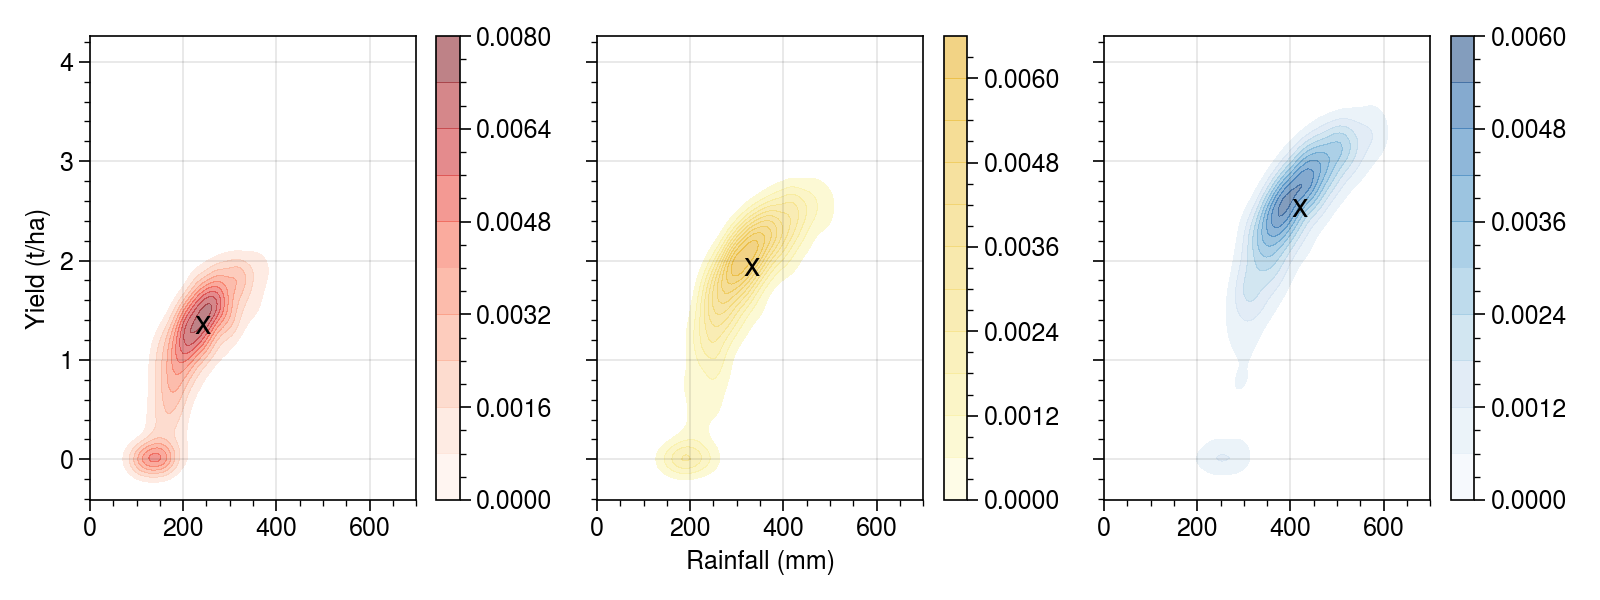

In [29]:
# Can I get these three on the same plot?

# I dont know how to do this with proplot - to get nice abcd, put in an issue
fig, axes = plt.subplots(ncols=3,nrows=1,figsize=(8,3), sharey=True, sharex=True) 


# this is so janky
sns.kdeplot(early.RF, early.Yield, xlim=(0,700),alpha=0.5, kind='kde',cmap="reds", shade=True, 
                shade_lowest=False, cbar=True, ax=axes[0])
ax1 = axes[0]
ax1.text(e_rf,e_y, "x", size=12, color='k')
#ax1.set(ylim=(-0.5,4.5))
#ax1.set(xlim=(0,700))
ax1.set(ylabel='Yield (t/ha)')
ax1.set(xlabel='')

#plt.show()
ax2 = axes[1]
sns.kdeplot(med.RF, med.Yield, xlim=(0,700),ylim=(-0.5,4.5),alpha=0.5,kind='kde',cmap="orange1", 
                  shade=True, shade_lowest=False, cbar=True,ax=ax2)
ax2.text(m_rf,m_y,"x",size=12,color='k')
#ax2.set(ylim=(-0.5,4.5))
ax2.set(xlim=(0,700))
ax2.set(ylabel='')
ax2.set(xlabel='Rainfall (mm)')


ax3 = axes[2]
#plt.show()
sns.kdeplot(late.RF, late.Yield,xlim=(0,700),ylim=(-0.5,4.5), alpha=0.5,kind='kde',cmap="blues", shade=True, shade_lowest=False, cbar=True, ax=ax3) #greens
ax3.text(l_rf,l_y, "x", size=12, color='k')
#ax3.set(ylim=(-0.5,4.5))
#ax3.set(xlim=(0,700))
ax3.set(ylabel='')
ax3.set(xlabel='')

fig.tight_layout()
plt.savefig('../output/4-cultivar-analysis/varietiesPDFa.png')

AttributeError: 'JointGrid' object has no attribute 'text'

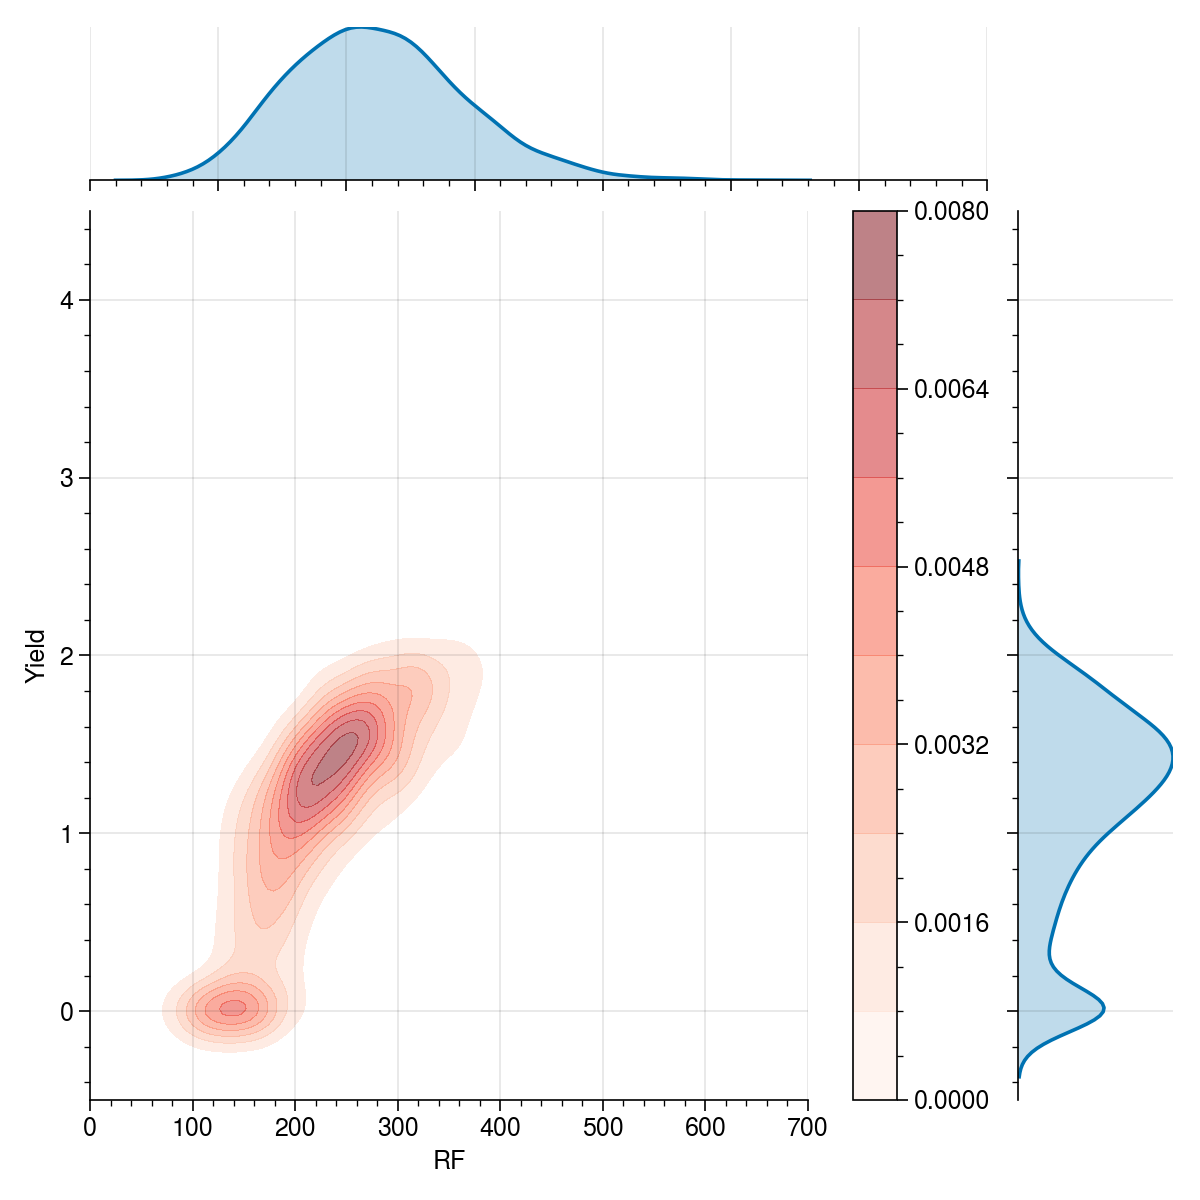

In [18]:
# this is broken

ax1 = sns.jointplot(early.RF, early.Yield, xlim=(0,700),ylim=(-0.5,4.5),alpha=0.5, kind='kde',cmap="reds", shade=True, shade_lowest=False, cbar=True)
ax1.text(e_rf,e_y, "x", size=16, color='k')
#ax1.set(ylim=(-0.5,4.5))
#ax1.set(xlim=(0,700))
#ax1.set(ylabel='Yield (t/ha)')
#ax1.set(xlabel='Rainfall (mm)')
  
ax2 = sns.jointplot(med.RF, med.Yield, xlim=(0,700),ylim=(-0.5,4.5),alpha=0.5,kind='kde',cmap="orange1", shade=True, shade_lowest=False, cbar=True)
#ax2.text(m_rf,m_y,"x",size=16,color='k')
#ax2.set(ylim=(-0.5,4.5))
#ax2.set(xlim=(0,700))
#ax2.set(ylabel='Yield (t/ha)')
#ax2.set(xlabel='Rainfall (mm)')
plt.show()
ax3 = sns.jointplot(late.RF, late.Yield,xlim=(0,700),ylim=(-0.5,4.5), alpha=0.5,kind='kde',cmap="blues", shade=True, shade_lowest=False, cbar=True) #greens
#ax3.text(l_rf,l_y, "x", size=16, color='k')
#ax3.set(ylim=(-0.5,4.5))
#ax3.set(xlim=(0,700))
#ax3.set(ylabel='Yield (t/ha)')
#ax3.set(xlabel='Rainfall (mm)')

In [19]:
# Make the table 

# eventually I will want a table with the following and so I can start to make it here
p_desc = ['Early (< 105 d)','Medium (110 - 140 d)',  'Late (145 + d)']
rf = [e_rf, m_rf, l_rf]
y = [e_y, m_y, l_y]
c = [c_e, c_m, c_l]

table1 = pd.DataFrame({'Maize Variety':p_desc,
                       'Average Rainfall (mm)': rf,
                       'Average Yield (t/ha)': y,
                       'Probability of Crop Failure (%)':c})

table1 = table1.round({'Average Rainfall (mm)':1,'Average Yield (t/ha)':4,
             'Probability of Crop Failure (%)':2})
#table1.to_csv('table1.csv',sep=',')

print(table1.to_latex(index=False))
table1

\begin{tabular}{lrrr}
\toprule
        Maize Variety &  Average Rainfall (mm) &  Average Yield (t/ha) &  Probability of Crop Failure (\%) \\
\midrule
      Early (< 105 d) &                  224.6 &                1.2581 &                            12.31 \\
 Medium (110 - 140 d) &                  313.3 &                1.8486 &                             7.09 \\
       Late (145 + d) &                  401.3 &                2.4409 &                             4.34 \\
\bottomrule
\end{tabular}



Maize Variety  Average Rainfall (mm)  Average Yield (t/ha)  \
0       Early (< 105 d)                  224.6                1.2581   
1  Medium (110 - 140 d)                  313.3                1.8486   
2        Late (145 + d)                  401.3                2.4409   

   Probability of Crop Failure (%)  
0                            12.31  
1                             7.09  
2                             4.34

In [22]:
result = r0.fillna(0)

Maybe make these figures before doing the table. Might make it a little easier

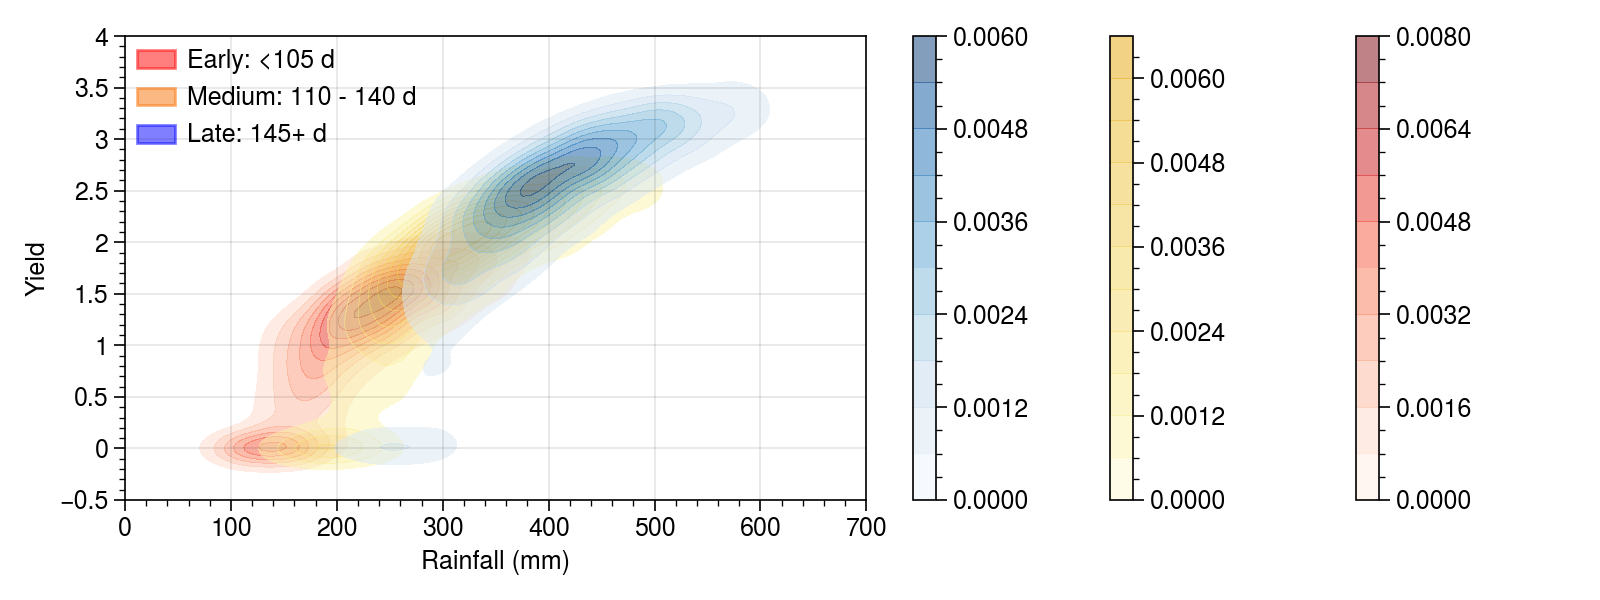

In [23]:
# 2D Density 
# code from here: https://seaborn.pydata.org/examples/multiple_joint_kde.html

#plt.figure(figsize=(8, 3), facecolor='w', edgecolor='k') # dpi=80,

########## Plot 1
#result=r0
# Subset the iris dataset by species
early = result.query("Category == 'Early (< 105 d)'")
med = result.query("Category == 'Medium (110 - 140 d)'")
late = result.query("Category == 'Late (145 + d)'")

# Set up the figure
f, axs = plt.subplots(figsize=(8, 3)) #3, figsize=(6,10), sharex=True, sharey=True) # figsize=(15, 15)
#ax.set_aspect("equal")

# Draw the two density plots
axs = sns.kdeplot(early.RF, early.Yield, alpha=0.5,
                 cmap="reds", shade=True, shade_lowest=False, cbar=True)
axs = sns.kdeplot(med.RF, med.Yield, alpha=0.5,
                 cmap="orange1", shade=True, shade_lowest=False, cbar=True)
axs = sns.kdeplot(late.RF, late.Yield, alpha=0.5,
                 cmap="blues", shade=True, shade_lowest=False, cbar=True) #greens

# Add labels to the plot
red = sns.color_palette("reds")[-2] #greens
yellow = sns.color_palette("orange1")[-3]
blue = sns.color_palette("blues")[-2]
#ax.text(350,.5, "early", size=16, color=red)
#ax.text(550,2,"medium",size=16,color=yellow)
#ax.text(680, 3.3, "late", size=16, color=blue)

plt.xlabel('Rainfall (mm)')
#plt.title('Joint PDF, Unaltered climate')

import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color='red', label='Early: <105 d', alpha=0.5)
orange_patch = mpatches.Patch(color='orange', label='Medium: 110 - 140 d', alpha=0.5)
blue_patch = mpatches.Patch(color='blue', label='Late: 145+ d', alpha=0.5)
plt.legend(handles=[red_patch, orange_patch, blue_patch],loc='upper left', frameon=False) #,  bbox_to_anchor=(0.9, 0.9)
plt.ylim(-.5,4)
plt.xlim(0,700)


f.tight_layout()
#plt.savefig('../output/4-cultivar-analysis/varietiesPDFb.png')

# Need the dimensions to match up with the other plot

<ipython-input-28-d73665541d66>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  early['Yield_norm'] = early.Yield/max(early.Yield)
<ipython-input-28-d73665541d66>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  med['Yield_norm'] = med.Yield/max(med.Yield)
<ipython-input-28-d73665541d66>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

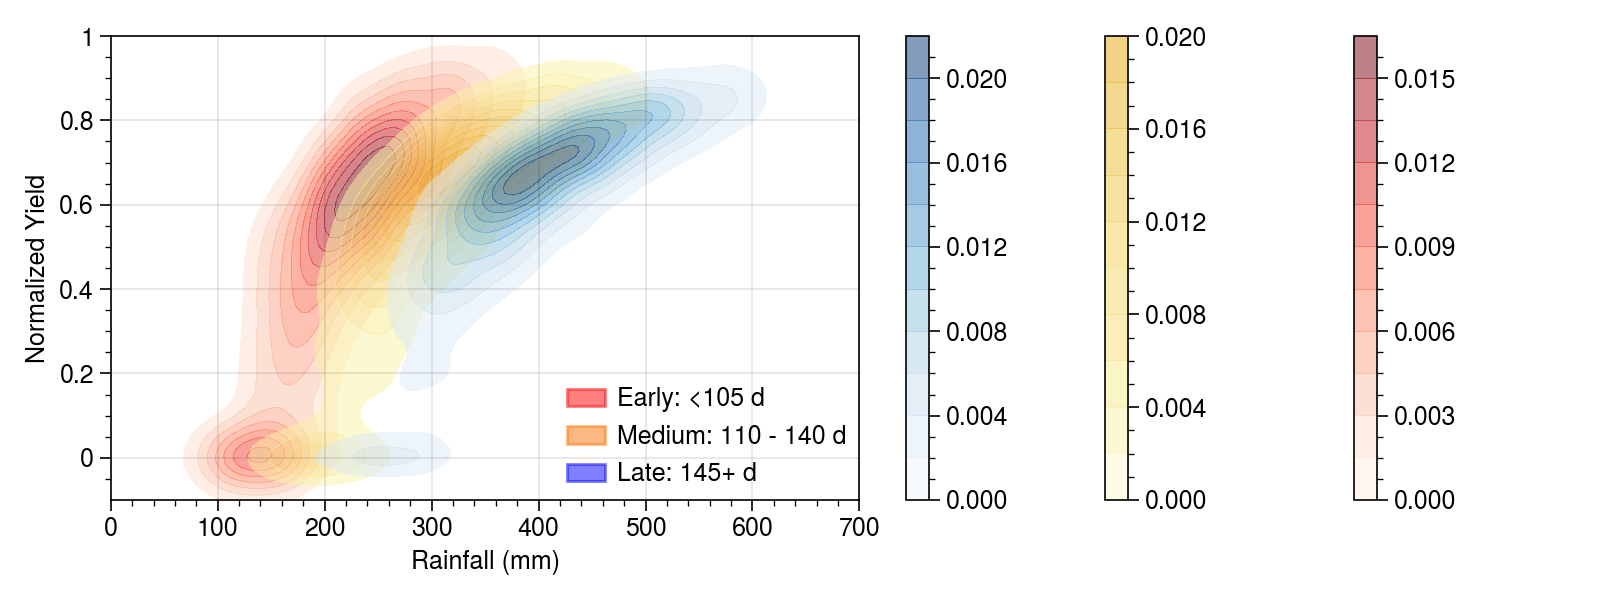

In [28]:
# make with normalized yields

# 2D Density 
# code from here: https://seaborn.pydata.org/examples/multiple_joint_kde.html

#plt.figure(figsize=(8, 3), facecolor='w', edgecolor='k') # dpi=80,

########## Plot 1
#result=r0
# Subset the iris dataset by species
early = result.query("Category == 'Early (< 105 d)'")
med = result.query("Category == 'Medium (110 - 140 d)'")
late = result.query("Category == 'Late (145 + d)'")

# set normalized yields
early['Yield_norm'] = early.Yield/max(early.Yield)
med['Yield_norm'] = med.Yield/max(med.Yield)
late['Yield_norm'] = late.Yield/max(late.Yield)

# Set up the figure
f, axs = plt.subplots(figsize=(8, 3)) #3, figsize=(6,10), sharex=True, sharey=True) # figsize=(15, 15)
#ax.set_aspect("equal")

# Draw the two density plots
axs = sns.kdeplot(early.RF, early.Yield_norm, alpha=0.5,
                 cmap="reds", shade=True, shade_lowest=False, cbar=True)
axs = sns.kdeplot(med.RF, med.Yield_norm, alpha=0.5,
                 cmap="orange1", shade=True, shade_lowest=False, cbar=True)
axs = sns.kdeplot(late.RF, late.Yield_norm, alpha=0.5,
                 cmap="blues", shade=True, shade_lowest=False, cbar=True) #greens

# Add labels to the plot
red = sns.color_palette("reds")[-2] #greens
yellow = sns.color_palette("orange1")[-3]
blue = sns.color_palette("blues")[-2]
#ax.text(350,.5, "early", size=16, color=red)
#ax.text(550,2,"medium",size=16,color=yellow)
#ax.text(680, 3.3, "late", size=16, color=blue)

plt.xlabel('Rainfall (mm)')
plt.ylabel('Normalized Yield')
#plt.title('Joint PDF, Unaltered climate')

import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color='red', label='Early: <105 d', alpha=0.5)
orange_patch = mpatches.Patch(color='orange', label='Medium: 110 - 140 d', alpha=0.5)
blue_patch = mpatches.Patch(color='blue', label='Late: 145+ d', alpha=0.5)
plt.legend(handles=[red_patch, orange_patch, blue_patch],loc='lower right', frameon=False) #,  bbox_to_anchor=(0.9, 0.9)
plt.ylim(-.1,1)
plt.xlim(0,700)


f.tight_layout()
plt.savefig('../output/4-cultivar-analysis/varietiesPDFc.png')

# Need the dimensions to match up with the other plot

### Eventually, may try to do this the right way with proplot
Four plots on the same figure. 

It would be wise of me to give up on this (I did.)

In [ ]:
# # Change the reference subplot in a complex grid 

# fig, axs = plot.subplots( # 0 is empty spaces
#         [[1, 1,1], [2,3,4]], # [1,2], [2,2],[2,2]
#     ref=2, span=False, journal='agu4' # axwidth=1.8, 
#     )
# axs[0].plot(early.RF)
# axs[]
# #sns.kdeplot(early.RF, early.Yield, alpha=0.5,cmap="reds", shade=True, shade_lowest=False, cbar=True, ax=axs[1])
# #ax = sns.kdeplot(med.RF, med.Yield, alpha=0.5,
# #                 cmap="orange1", shade=True, shade_lowest=False, cbar=True)
# #ax = sns.kdeplot(late.RF, late.Yield, alpha=0.5,
# #                 cmap="blues", shade=True, shade_lowest=False, cbar=True) #greens
        
# axs[0].format(
#         suptitle='Effect of reference subplot on figure size',
#         title='reference', titleweight='bold',
#         titleloc='uc', titlecolor='red9'
#     )


In [ ]:
# # Change the reference subplot in presence of unequal width/height ratios
# for ref in (1, 2):
#     fig, axs = plot.subplots(
#         ref=ref, nrows=2, ncols=3, # wratios=(3, 2, 2)
#         axwidth=1.1,
#     )
#     #axs[ref - 1].format(
#     #    suptitle='Effect of reference subplot on figure size',
#     #    title='reference', titleweight='bold',
#     #    titleloc='uc', titlecolor='red9')

## 2. Start here if need to run simulations <a id='run_sims'></a>


### Import DTMs-Yield info for evolved calc_yield

Eventually want to factor evolved calc yield into model, but not going to do that now. That will make this section irrelevant.

0.8821342568671495
m 0.03820972194249297
b -2.572222327532083
0.3905396783804279
m 0.01875098888679605
b 0.29946317573930376
0.4632651596531201
m 0.03967089952345481
b 0.974653472394682


1.17

<Figure size 500x400 with 0 Axes>

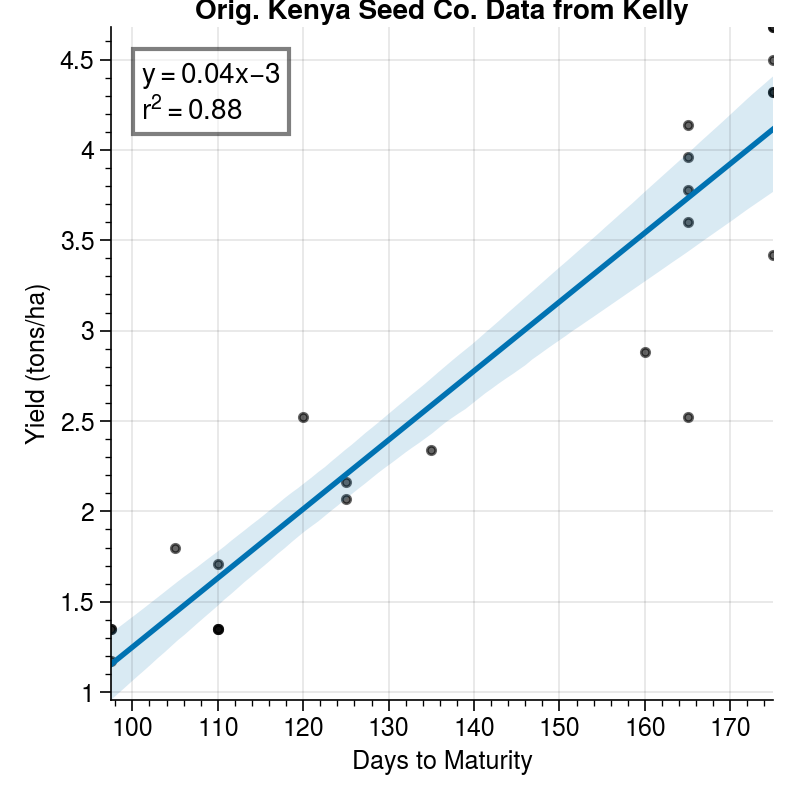

<Figure size 500x400 with 0 Axes>

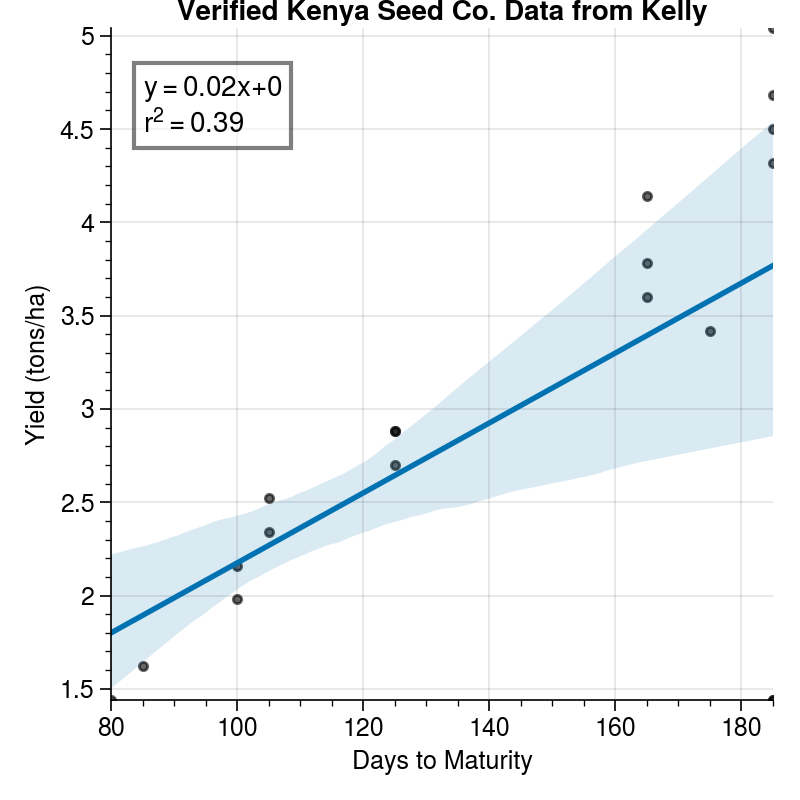

<Figure size 500x400 with 0 Axes>

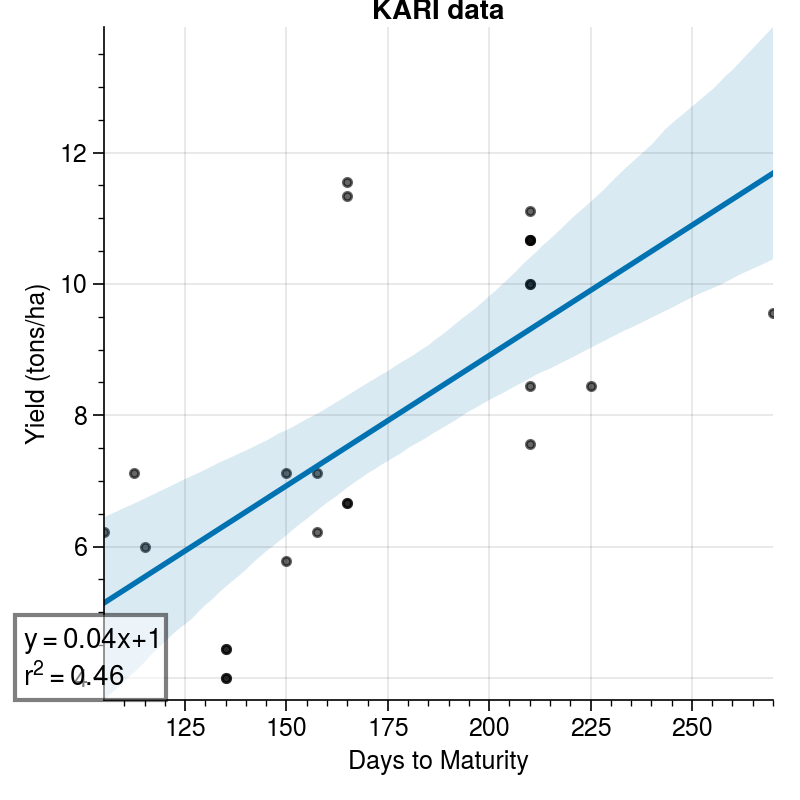

In [2]:
# First set of data
# Original data
hybrid_data = pd.read_csv('../data/Yields/hybrid_yields.csv')

# convert to metric tons
hybrid_data['yield_metric_tons'] = hybrid_data.yield_kg_ha/1000
hybrid_data

#sns.set(font_scale=1)
#sns.set_style("whitegrid")

p, m, b = plot_lin_regression(hybrid_data.days_to_maturity, hybrid_data.yield_metric_tons, 'days_to_maturity', 'yield_metric_tons', hybrid_data, 101, 4.5, 'Days to Maturity', 'Yield (tons/ha)', 
                    'Orig. Kenya Seed Co. Data from Kelly', positive=False)

# verified using Kenya Seed Co. - https://web.archive.org/web/20190819125927/http://kenyaseed.com/gallery/maize/
verified_hybrid_data = pd.read_csv('../data/Yields/hybrid_yields_verified.csv')
verified_hybrid_data


# convert to metric tons
verified_hybrid_data['yield_metric_tons'] = verified_hybrid_data.verified_yield_kg_acre/1000
verified_hybrid_data

p, m, b = plot_lin_regression(verified_hybrid_data.verified_days_to_maturity, verified_hybrid_data.yield_metric_tons, 
                              'verified_days_to_maturity', 'yield_metric_tons', verified_hybrid_data, 
                              85, 4.8, 'Days to Maturity', 'Yield (tons/ha)', 
                              'Verified Kenya Seed Co. Data from Kelly', positive=True)

# what's the max yield
hybrid_data.yield_metric_tons.min()

# KARI data - this is from the PDF: Details on crop information to calibrate crop models for Kenya
k_data = pd.read_csv('../data/Yields/hybrid_yields_KARI.csv')
k_data

p, m, b = plot_lin_regression(k_data.dtm_avg, k_data.yield_t_ha, 
                              'dtm_avg', 'yield_t_ha', k_data, 
                              85, 4.8, 'Days to Maturity', 'Yield (tons/ha)', 
                              'KARI data', positive=True)

# what's the max yield
hybrid_data.yield_metric_tons.min()

0.8040310879769121
m 0.027790555171045016
b -0.8277162088258405
0.6109750761024614
m 0.022698167046130428
b -0.11460070582872361


(0.6109750761024614, 0.022698167046130428, -0.11460070582872361)

<Figure size 500x400 with 0 Axes>

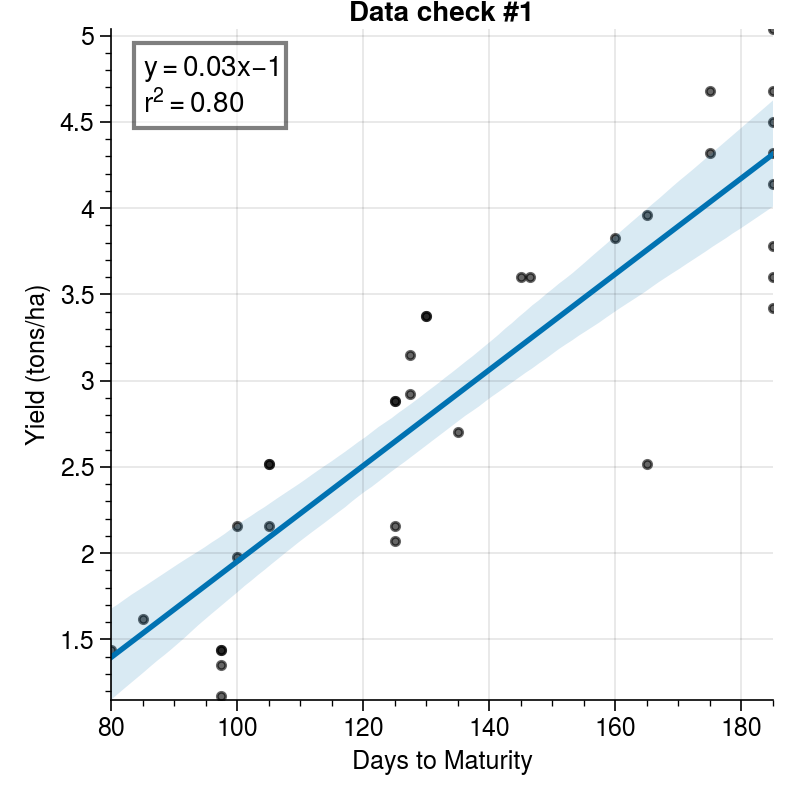

<Figure size 500x400 with 0 Axes>

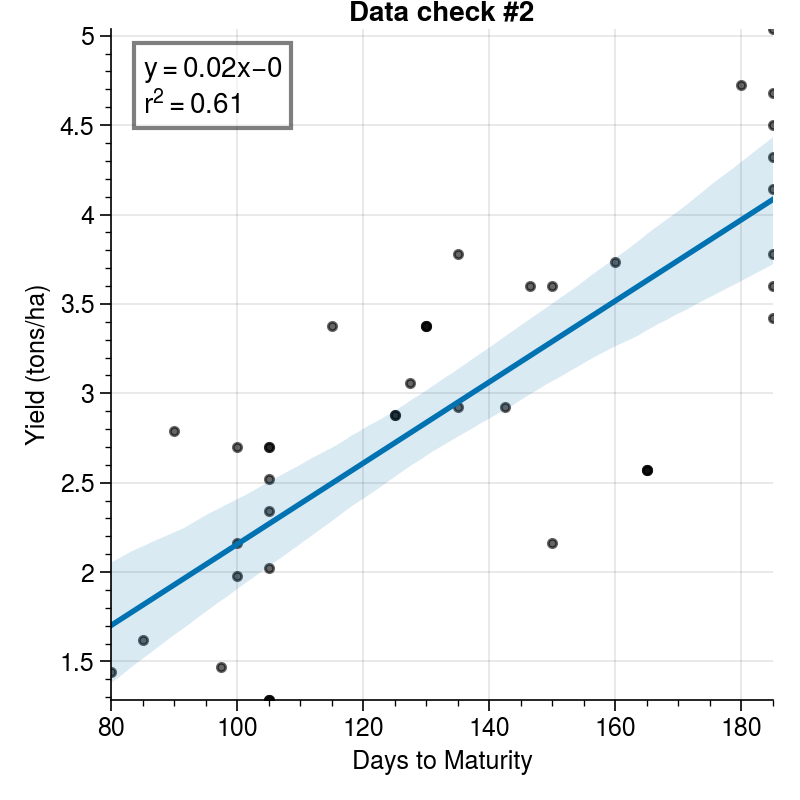

In [3]:
# Second set of data
hybrid_data = pd.read_csv('../data/Yields/hybrid_yields_v2.csv',usecols = ['Variety','Yield_kg_acre','DTM_Avg']).dropna()

# convert to metric tons
hybrid_data['yield_metric_tons'] = hybrid_data.Yield_kg_acre/1000
hybrid_data

plot_lin_regression(hybrid_data.DTM_Avg, hybrid_data.yield_metric_tons, 'DTM_Avg','yield_metric_tons', hybrid_data, 85, 4.9,'Days to Maturity', 'Yield (tons/ha)', 
                    'Data check #1', positive=False)

# Third group of varieties

hybrid_data = pd.read_csv('../data/Yields/hybrid_yields_v3.csv', usecols = ['VARIETY','Yield_kg_acre','Avg_DTM']).dropna()

# convert to metric tons
hybrid_data['yield_metric_tons'] = hybrid_data.Yield_kg_acre/1000
hybrid_data


hybrid_data
plot_lin_regression(hybrid_data.Avg_DTM, hybrid_data.yield_metric_tons, 'Avg_DTM','yield_metric_tons', hybrid_data, 85, 4.9,'Days to Maturity', 'Yield (tons/ha)', 
                    'Data check #2', positive=False)

Okay a couple of decisions here:
- Do we want the DTMs to go above 175? If so do we just make an assumption
- Is it okay to use the linear relationship rather than the data themselves
- Is 4680 kg/ha a reasonable max. value? Maybe this should this be lower.

In [4]:
def evolved_calc_yield(dtm=None, m = None, b = None):
    yield_kg_ha = m*dtm + b
    
    if dtm > 175:
        raise ValueError("days to maturity, {dtm} is larger than 175".format(
                dtm=dtm))
    if dtm < 68:
        raise ValueError("days to maturity, {dtm} is less than 68".format(
                dtm=dtm))
    
    return yield_kg_ha

evolved_calc_yield(100, m, b)
evolved_calc_yield(175,m,b)

7.9170608889992735

Now use this function to run the model which uses evolved_calc_yield in crop.calc_dstress

Also am including the different stations that would make sense to use.

In [13]:
# station options
s = ['OL JOGI FARM','EL KARAMA','JACOBSON FARM']

def run_model(n_sim = 500, burn_in=60, station = 'JACOBSON FARM', texture = 'clay loam', lgp=180, pd_sim=60): 
    """ Run simulations for a specific climate, soil, and crop.

    Usage: total_rf_corr(n_sim, pd_ic, station, texture, lgp, pd_sim)
           
    Default values:
        n_sim = 500 # Number of Simulations to Remove Initial Conditions [integer]
        pd_ic = 1 # Planting Date for Initial Conditions [Julian day]
        station = 'OL JOGI FARM' # Climatology [string]
        texture = 'loam' # Soil Type [string]
        lgp = 180 # Length of Growing Period [Days]
        pd_sim 100 # Planting Date for Simulation [Julian day]

    """
    # Part 1. Set conditions for IC runs
    doy=abs(pd_sim-burn_in)

    # Part 2. Initialize model with a climate, soil and crop
    climate = Climate(station=station)
    soil = Soil(texture=texture)
    crop = Crop(soil=soil, lgp=lgp)
    soil.set_nZr(crop)

    model = CropModel(crop=crop, climate=climate, soil=soil)
    model.run()
    o = model.output()

    # Part 3. Get the mean, SD soil moisture and run the simulations to remove IC
    s0_mean, s0_std = average_soil_moisture(model, n_sims=n_sim, doy=doy)
    models = [CropModel(crop=crop, climate=Climate(), soil=soil) for i in np.arange(n_sim)]
    
    # Part 4. Run the actual simulations
    planting_date=pd_sim
    output = [model.run(s0=s0_mean, do_output=True, planting_date=planting_date) for model in models]

    # Part 5. Subset the growing period because model starts 21 days before planting
    start = burn_in
    end = start + lgp

    # dont need this but helpful for debugging
    avg_stress = [df[start:end]['stress'].mean() for df in output]
    total_stress = [df[start:end]['stress'].sum() for df in output]
    total_rf = [df[start:end]['R'].sum() for df in output]
    avg_s = [df[start:end]['s'].mean() for df in output]
    kc = output[1][start:end]['kc'].tolist() # get kc values for one simulation
    
    o = output
    
    # Part 6. Output the dynamic stress and yield values
    x = [crop.calc_dstress(s=df.s, stress=df.stress, Y_MAX = evolved_calc_yield(i, m, b)) for df in o] # I have no clue whether this will work
    
    return x, total_rf, kc

In [19]:
# Now I have to re-run the simulations using the max yields from this relationship

varieties = np.arange(75,180,5) # 21 is a better number to work with because it divides by three
len(varieties)

result = []

for i in varieties:
    # note: bumping up to 200 sims per cultivar type takes several minutes to run
    # whereas 100 sims where varieties = np.arange(70,200,5) takes less than a minute.
    data, rf, kc = run_model(n_sim = 10, station = 'OL JOGI FARM', texture = 'clay loam', lgp=i, pd_sim=60)
    df = pd.DataFrame.from_records(data, columns =['AvgStress','DynamicStress','Yield'])
    df['RF'] = rf
    df['Cultivar'] = i
    result.append(df)
    
result = pd.concat(result)
result

AvgStress  DynamicStress     Yield          RF  Cultivar
0    0.263392       0.115546  3.493567   99.412776        75
1    0.081314       0.091287  3.589391  200.589045        75
2    0.032256       0.049711  3.753614  257.768332        75
3    0.251745       0.261385  2.917509  120.891860        75
4    0.063418       0.079665  3.635295  212.167008        75
..        ...            ...       ...         ...       ...
5    0.189656       0.184874  6.453404  414.013701       175
6    0.114641       0.088428  7.216969  525.920451       175
7    0.243247       0.162305  6.632085  410.980565       175
8    0.244391       0.221523  6.163253  407.542300       175
9    0.156512       0.127370  6.908661  456.718866       175

[210 rows x 5 columns]

False

In [62]:
result



False

In [8]:
data

NameError: name 'data' is not defined

In [16]:
# Add categorical values for early, medium and late maturing
# There is probably a way more efficient way to do this

def category(x):
    if x < 110:
        return "Early (< 105 d)"
    if 110 <= x <= 140:
        return "Medium (110 - 140 d)"
    else:
        return "Late (145 + d)"
    
for row in result.Cultivar:
    result['Category'] = result.Cultivar.apply(lambda x: category(x))

result.Category.value_counts()

Early (< 105 d)         700
Medium (110 - 140 d)    700
Late (145 + d)          700
Name: Category, dtype: int64

In [20]:
# It worked! Okay not going to worry too much about it now, but might need Kelly's help refactoring into model

# export result so that I can access more easily
#result.to_csv('../output/4-cultivar-analysis/result.csv',sep=',')

If needed, make the boxplot figure with binned rainfall

In [21]:
# TODO check this but I might need rainfall to be grouped into equal bins?

# roughly how many groups if in 50 mm incremements?
print((result.RF.max() - result.RF.min())/50)

#labels = ['< 110 mm','110 - 160 mm','160 - 210 mm', '210 - 260 mm','260 - 310 mm', '310 - 360 mm', '360 - 410 mm', 
#          '410 - 460 mm','460 - 510 mm','510 - 560 mm', '560 - 610 mm','610 - 660 mm', '660 - 710 mm', '710 - 760 mm', 
#         '760 +']

# result['RF_bins'] = pd.cut(result.RF, 15, labels=labels) # 15 bins
result['RF_bins_orig'] = pd.cut(result.RF, 12) # labels aren't 100% accurate but okay for now
result.RF_bins_orig.value_counts()


14.97548163465433


(252.925, 315.322]    473
(315.322, 377.72]     407
(190.527, 252.925]    377
(377.72, 440.118]     308
(128.129, 190.527]    239
(440.118, 502.516]    164
(502.516, 564.914]     62
(64.982, 128.129]      46
(564.914, 627.312]     16
(627.312, 689.709]      5
(689.709, 752.107]      2
(752.107, 814.505]      1
Name: RF_bins_orig, dtype: int64

## Generate Figures: Box plot and Joint PDF

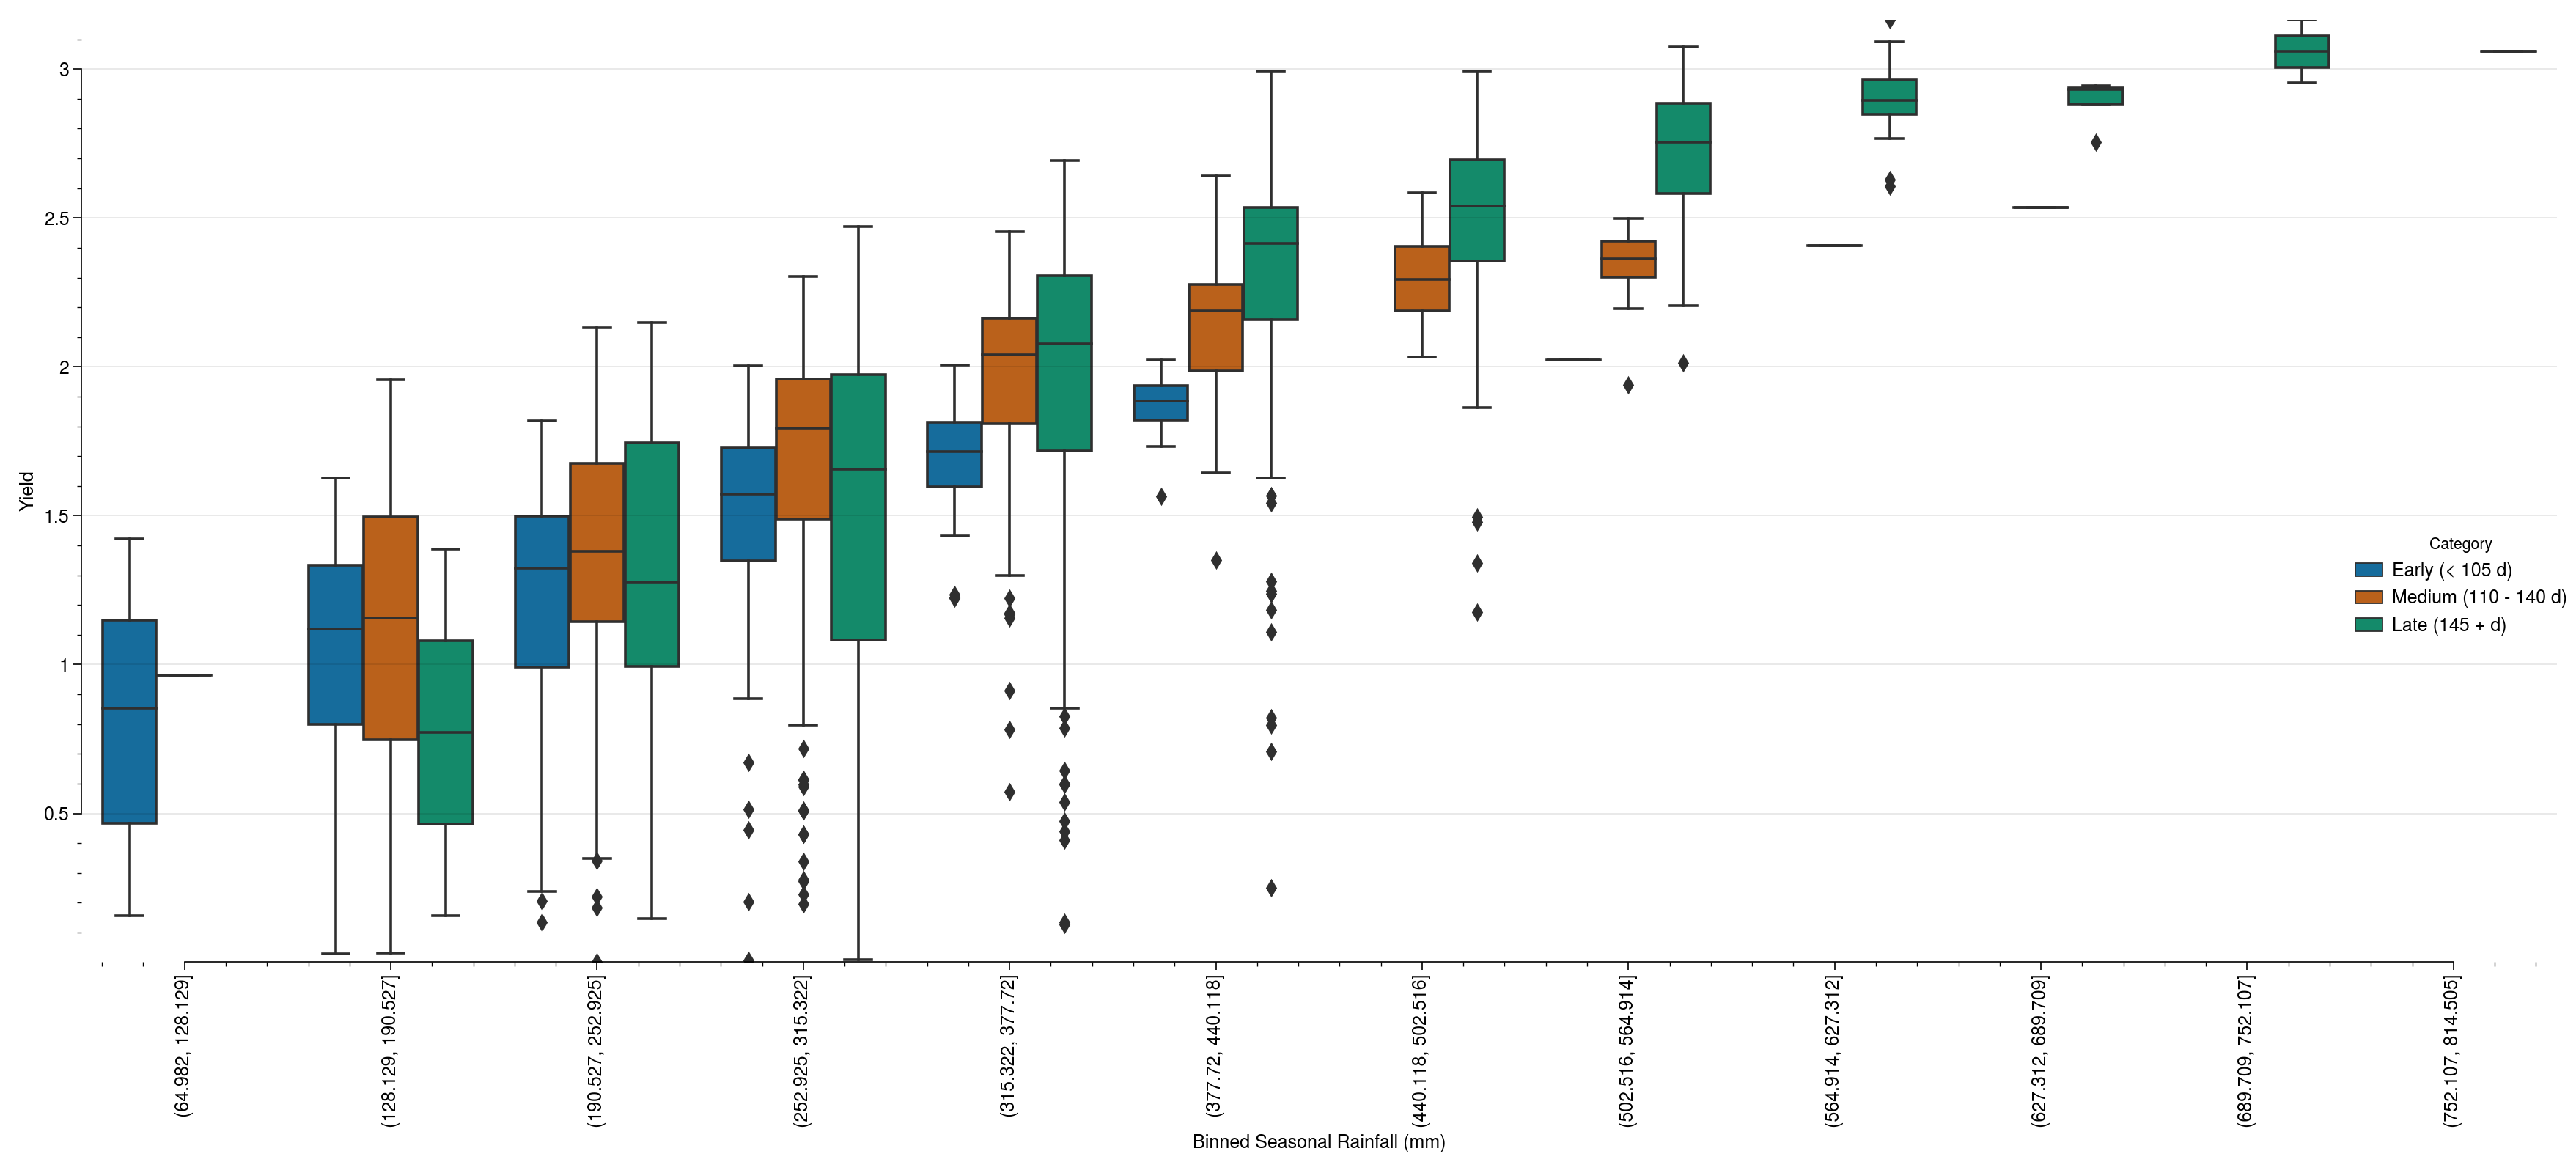

In [22]:
# Make box plot with yield statistics
# Note: to have better labels just edit the labels in the previous cell

#sns.set(font_scale=1.3)
#sns.set_style("whitegrid")
#sns.set_palette("colorblind") #blues bhm green3 reds colorblind set3

g = sns.catplot(x="RF_bins_orig", y="Yield", hue="Category", data=result, kind="box", height=8, aspect=2) # height=15, aspect=8
g.set_axis_labels("Binned Seasonal Rainfall (mm)") # , ""
g.despine(trim=True)
plt.setp(g.ax.get_xticklabels(), rotation=90);
plt.tight_layout()

### Heat check on whether these values are reasonable. 

Two parts:
    
1. Add in more maize varieties to see if the linear regression holds -- looks fine
2. Compare with external datasets for relative validation -- EWX & Frank's paper. We could reduce the max value by 50% to be more realistic. Or look at our yield data.. Just quickly going to do that. 

## Heat check: Relationship looks like empirical data

0.6343509378487664
m 0.01648898016961473
b 0.05313849175101751


<Figure size 500x400 with 0 Axes>

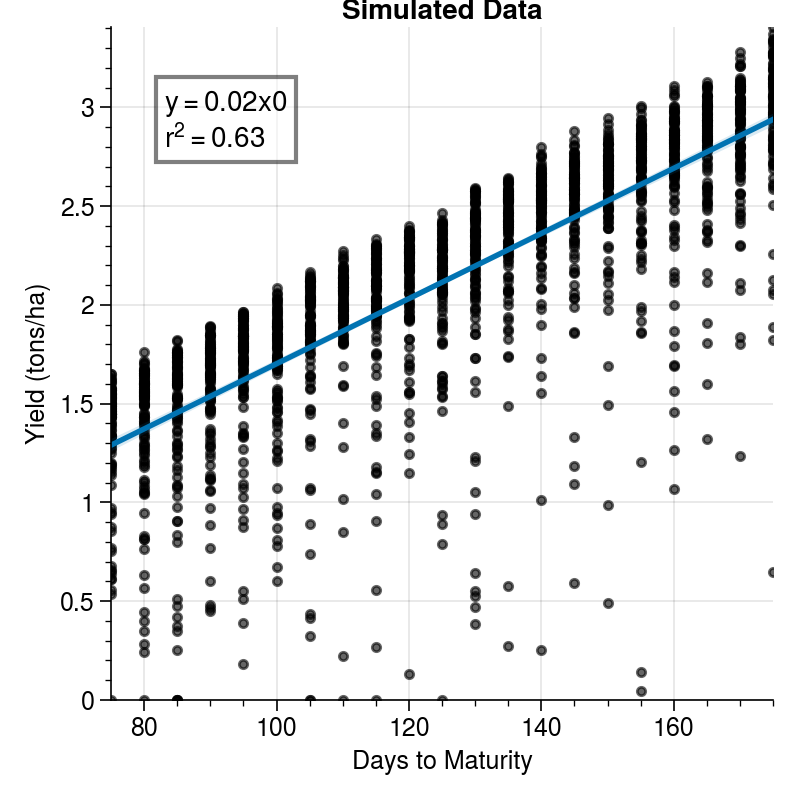

In [20]:
p, m, b = plot_lin_regression(result.Cultivar, result.Yield, 'Cultivar','Yield', result, 83, 3.1,'Days to Maturity', 'Yield (tons/ha)', 
                    'Simulated Data', positive=False)

## 3. Extra figures/code <a id='warning'></a>


Want to move this elsewhere eventually, but want to make climate variability figure

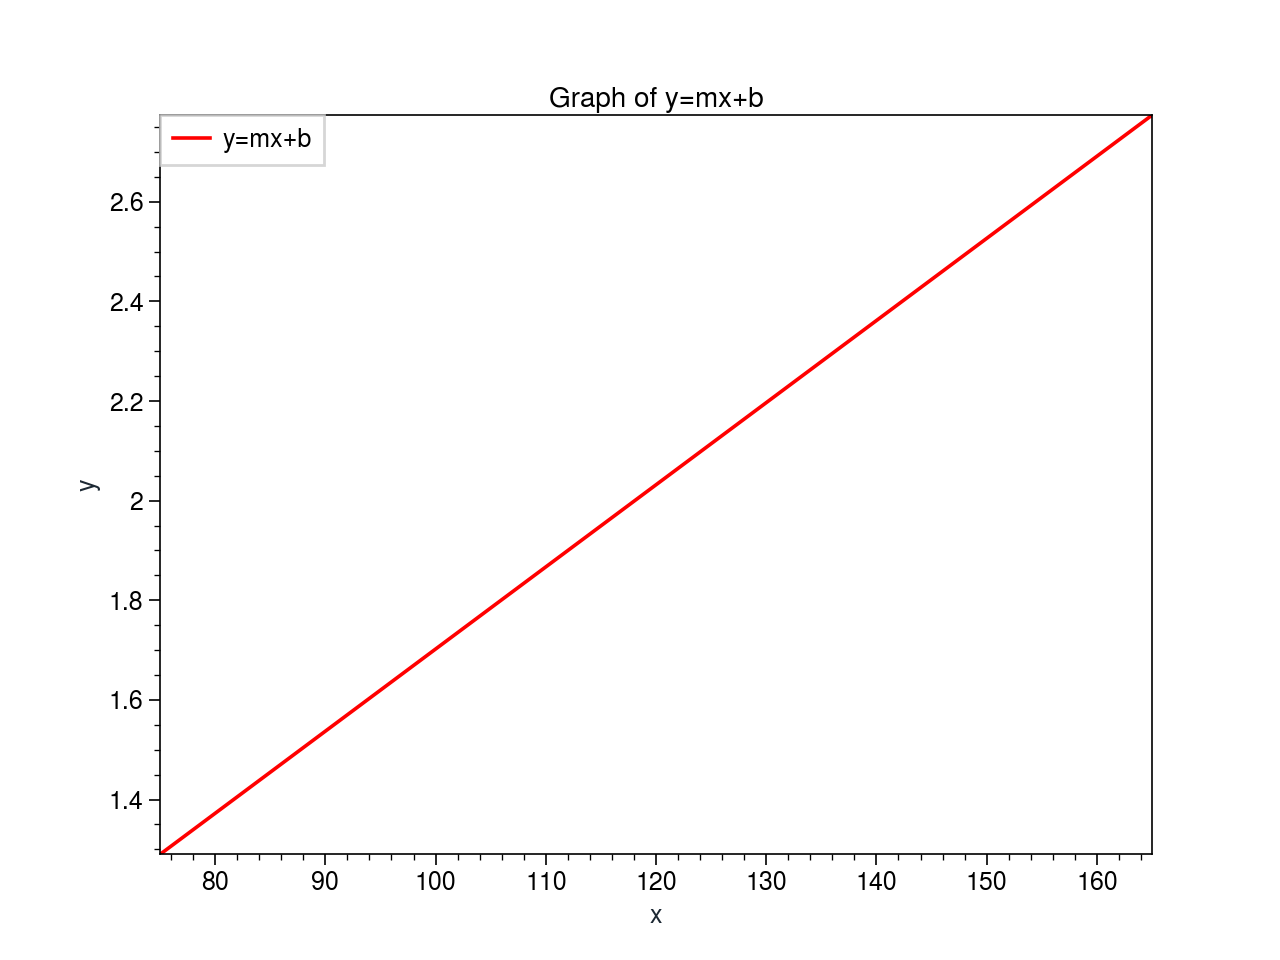

array([ 75.        ,  75.90909091,  76.81818182,  77.72727273,
        78.63636364,  79.54545455,  80.45454545,  81.36363636,
        82.27272727,  83.18181818,  84.09090909,  85.        ,
        85.90909091,  86.81818182,  87.72727273,  88.63636364,
        89.54545455,  90.45454545,  91.36363636,  92.27272727,
        93.18181818,  94.09090909,  95.        ,  95.90909091,
        96.81818182,  97.72727273,  98.63636364,  99.54545455,
       100.45454545, 101.36363636, 102.27272727, 103.18181818,
       104.09090909, 105.        , 105.90909091, 106.81818182,
       107.72727273, 108.63636364, 109.54545455, 110.45454545,
       111.36363636, 112.27272727, 113.18181818, 114.09090909,
       115.        , 115.90909091, 116.81818182, 117.72727273,
       118.63636364, 119.54545455, 120.45454545, 121.36363636,
       122.27272727, 123.18181818, 124.09090909, 125.        ,
       125.90909091, 126.81818182, 127.72727273, 128.63636364,
       129.54545455, 130.45454545, 131.36363636, 132.27

In [24]:
# normal climate
x = np.linspace(75,165,100)
y = m*x+b
plt.plot(x, y, '-r', label='y=mx+b')
plt.title('Graph of y=mx+b')
plt.xlabel('x', color='#1C2833')
plt.ylabel('y', color='#1C2833')
plt.legend(loc='upper left')
plt.grid()
plt.show()


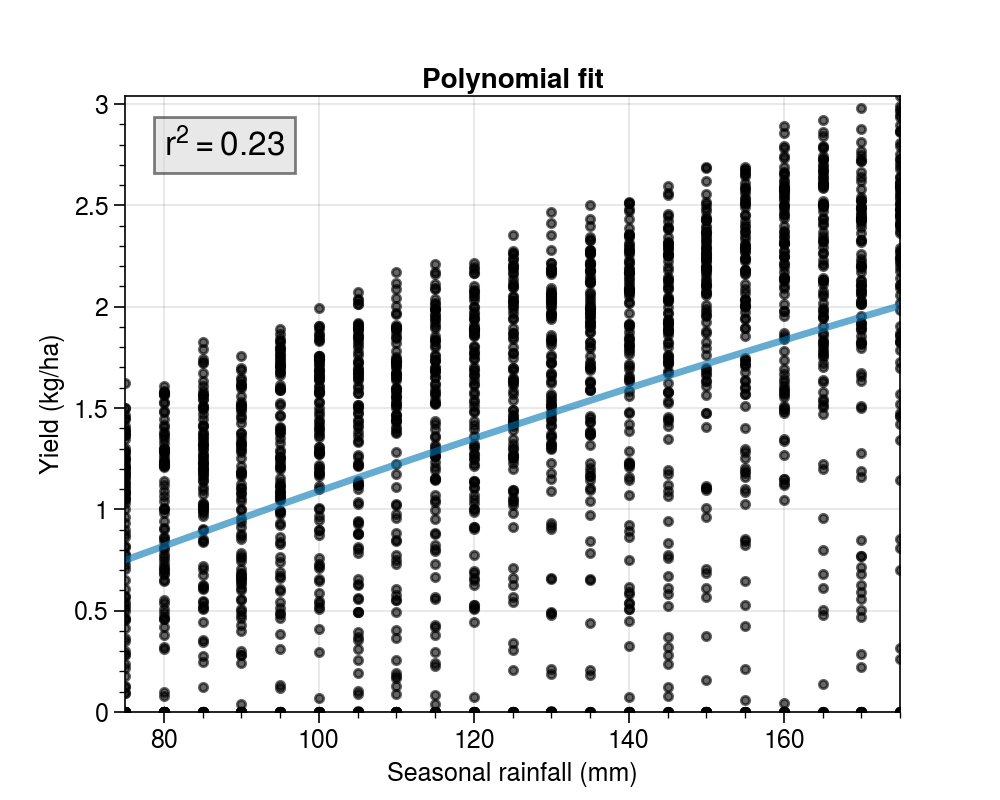

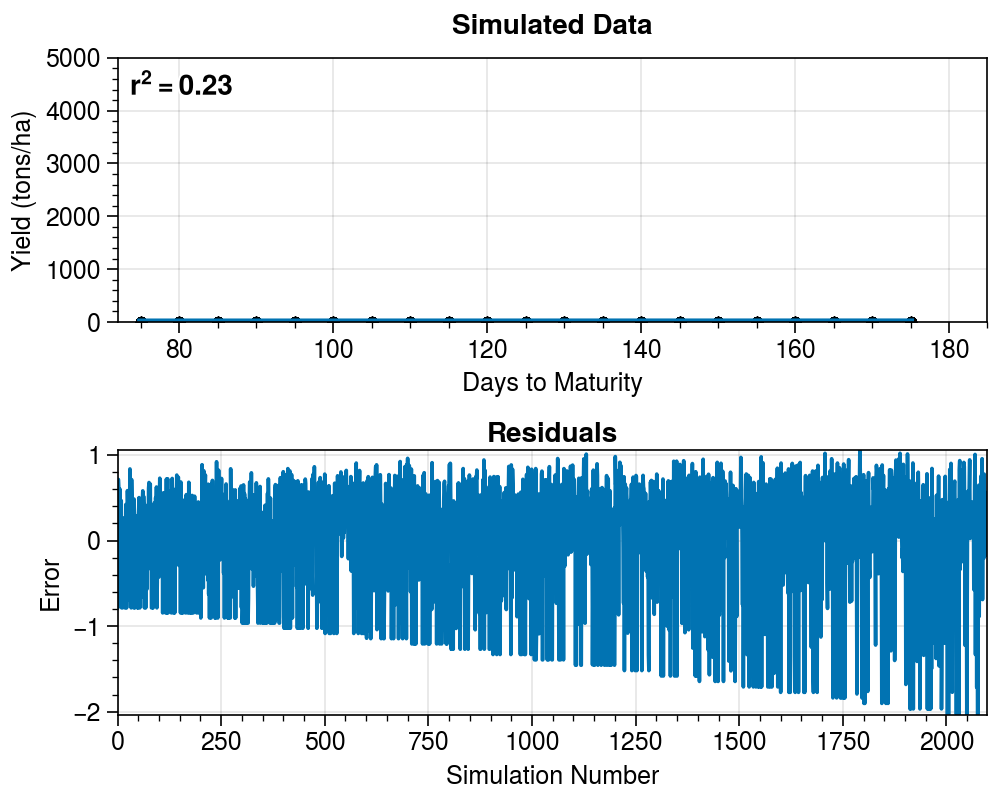

In [35]:
# import previous results

df = pd.read_csv('../output/2-rainfall-variability/r25_output.csv',sep=',').drop('Unnamed: 0',axis=1)

#p1, m1, b1 = plot_lin_regression(df.Cultivar, df.Yield, 'Cultivar','Yield', result, 83, 3.1,'Days to Maturity', 'Yield (tons/ha)', 
#                    'Simulated Data', positive=False)

plot_polyfit(df.Cultivar, df.Yield, 2)


power_law_fit(df.Cultivar, df.Yield, 'Days to Maturity', 'Yield (tons/ha)', 
                    'Simulated Data')

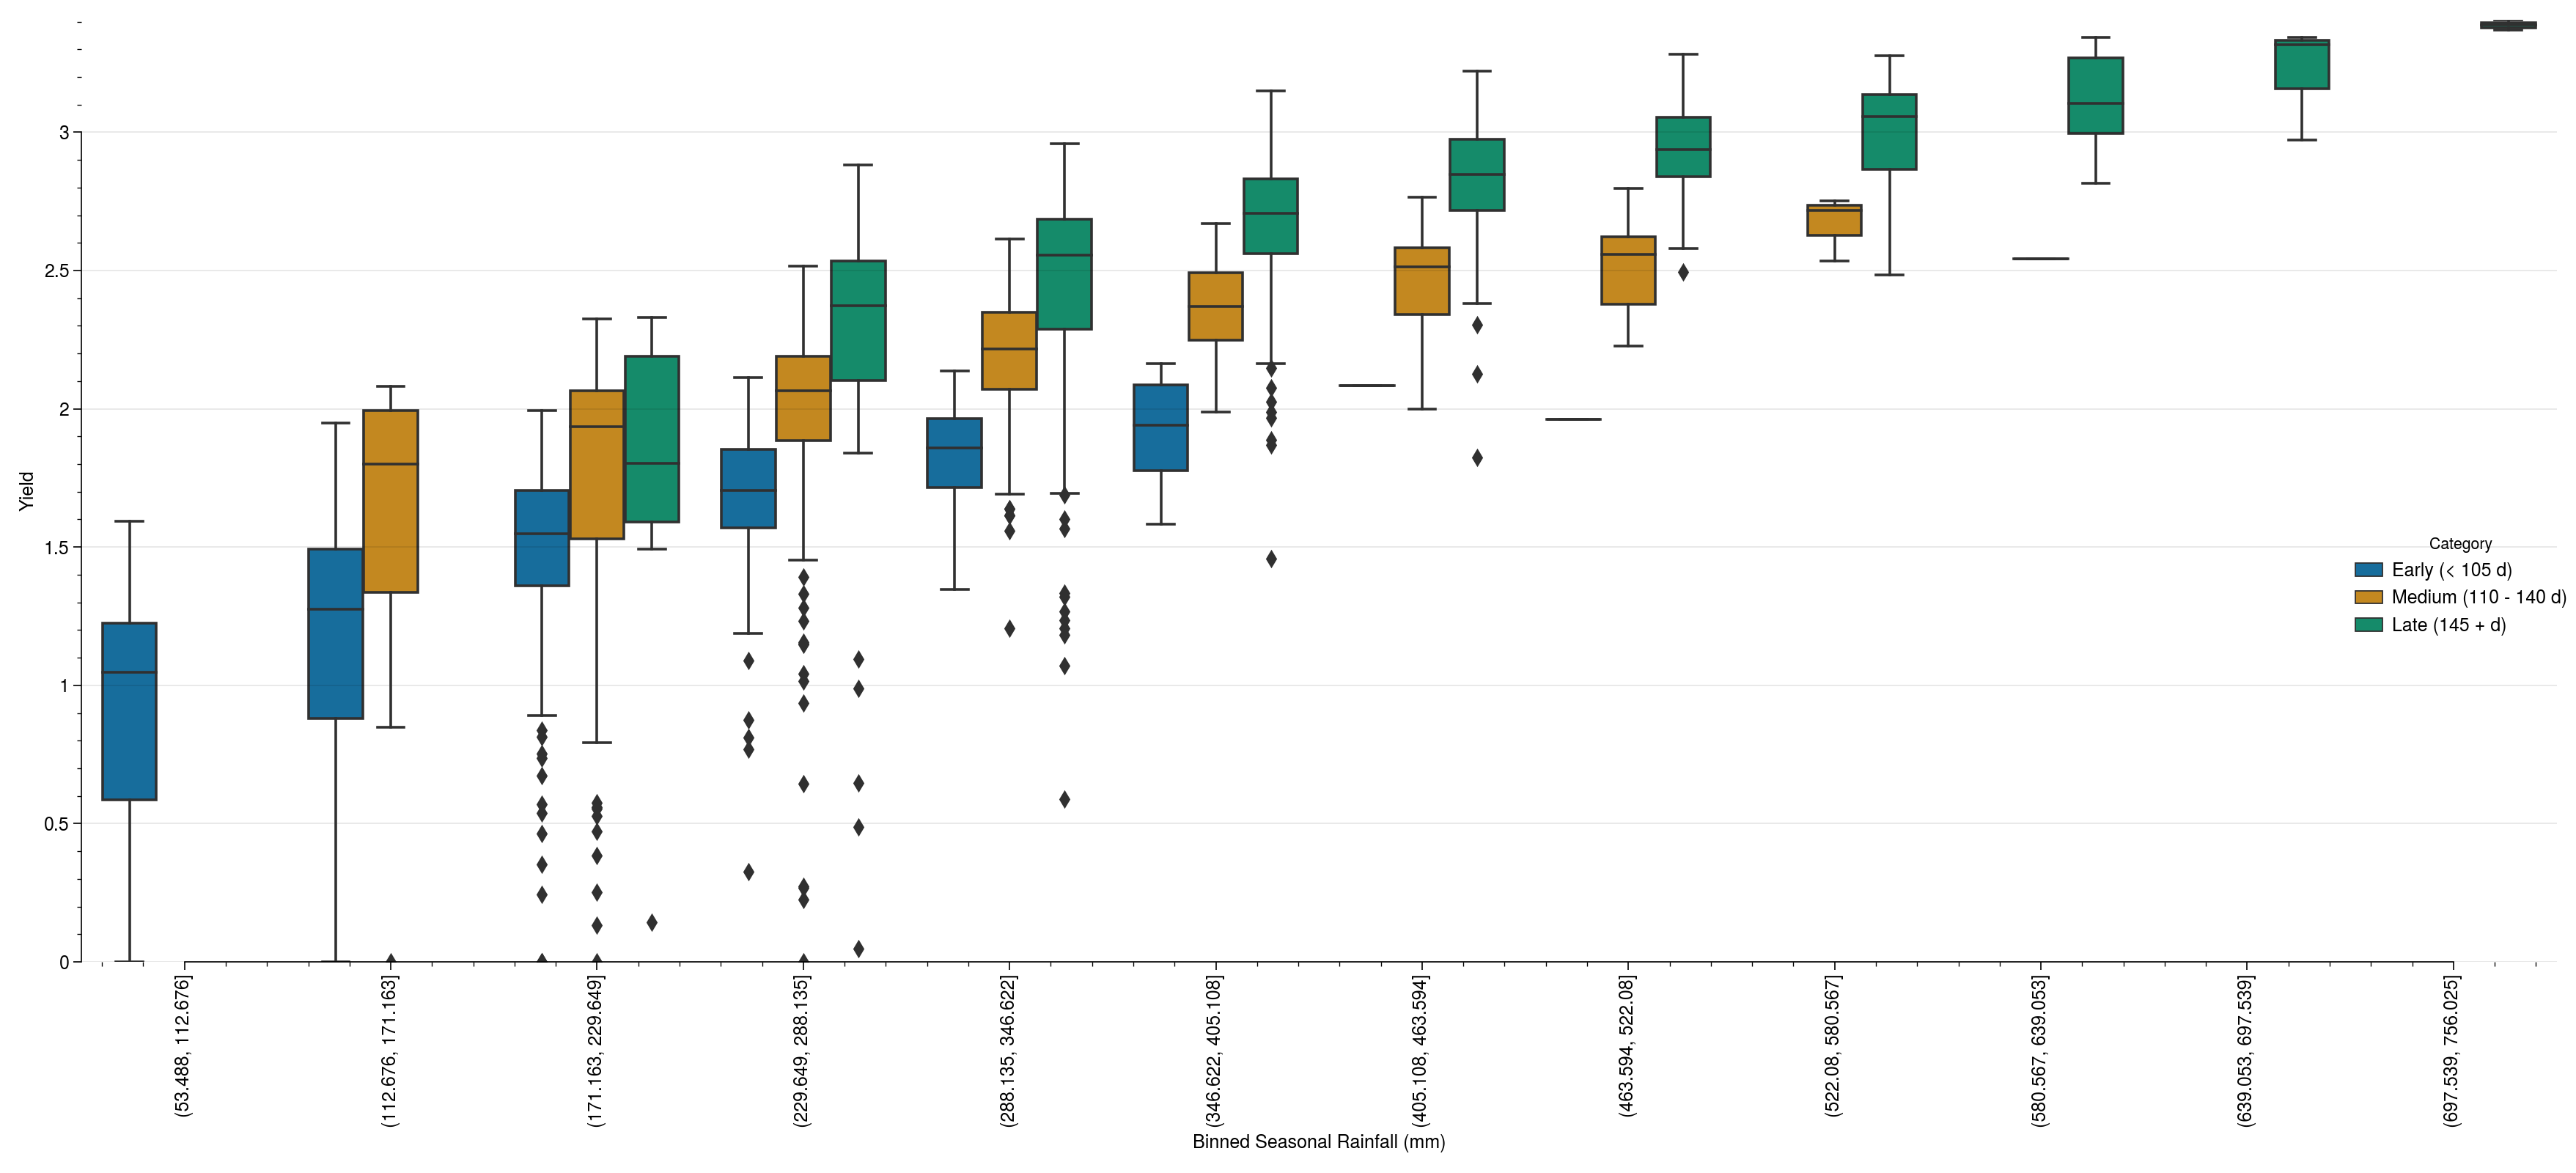

In [19]:
# Here's the box plot

#sns.set(font_scale=1.3)
#sns.set_style("whitegrid")
sns.set_palette("colorblind") #blues bhm green3 reds colorblind set3

g = sns.catplot(x="RF_bins_orig", y="Yield", hue="Category", data=result, kind="box", height=8, aspect=2) # height=15, aspect=8
g.set_axis_labels("Binned Seasonal Rainfall (mm)") # , ""
g.despine(trim=True)
plt.setp(g.ax.get_xticklabels(), rotation=90);
plt.tight_layout()

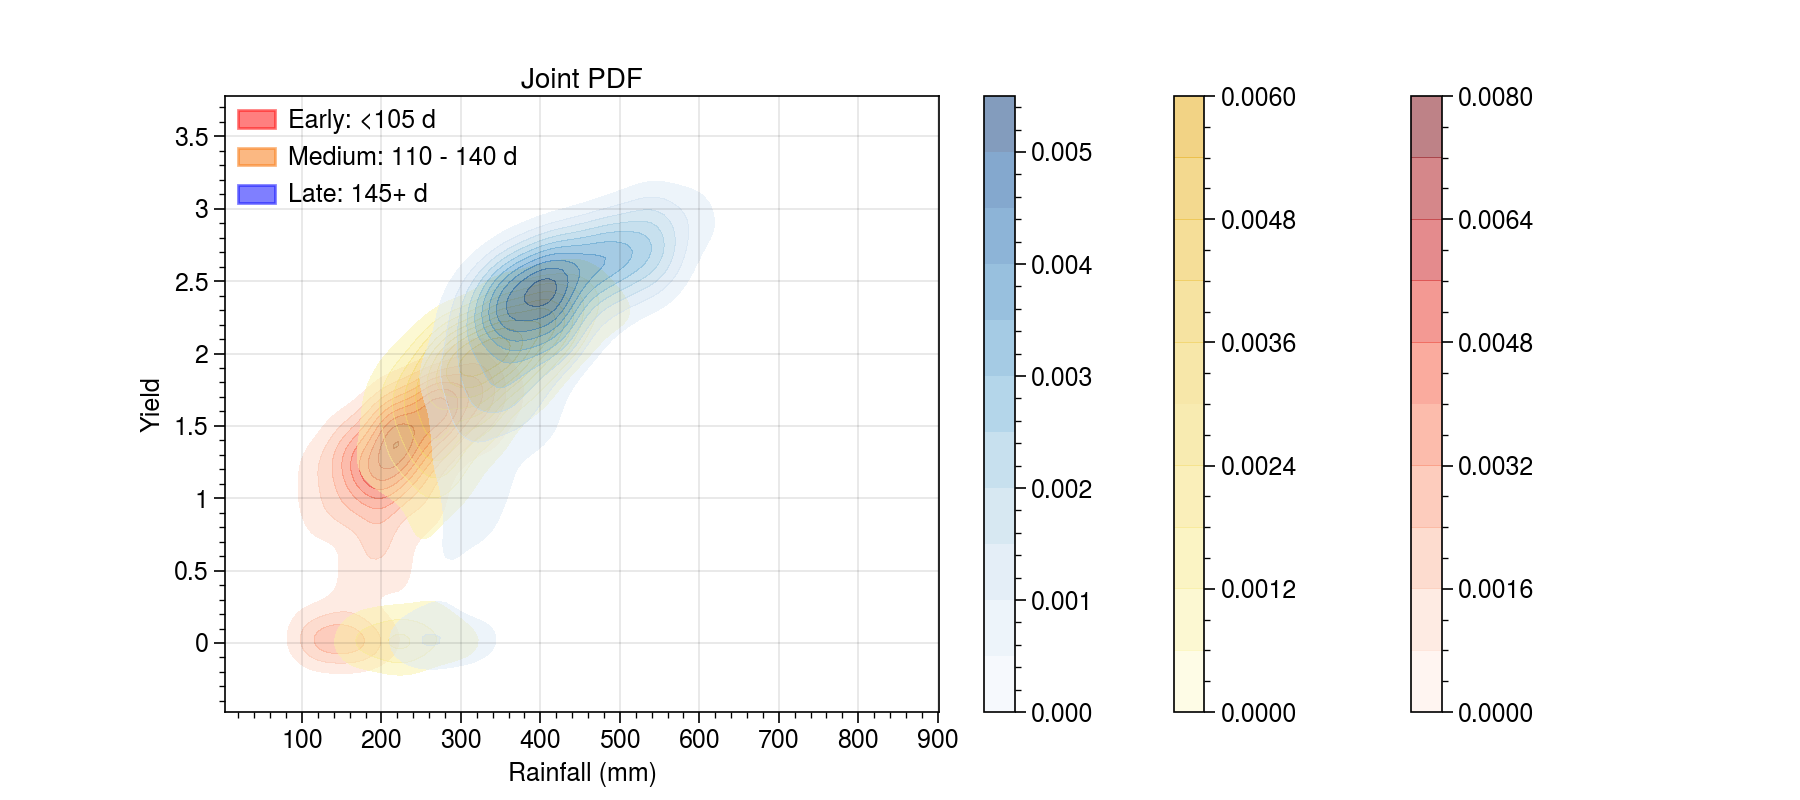

In [20]:
# 2D Density 
# code from here: https://seaborn.pydata.org/examples/multiple_joint_kde.html

result

# Subset the iris dataset by species
early = result.query("Category == 'Early (< 105 d)'")
med = result.query("Category == 'Medium (110 - 140 d)'")
late = result.query("Category == 'Late (145 + d)'")

# Set up the figure
f, ax = plt.subplots(figsize=(9, 4))
#ax.set_aspect("equal")

# Draw the two density plots
ax = sns.kdeplot(early.RF, early.Yield, alpha=0.5,
                 cmap="reds", shade=True, shade_lowest=False, cbar=True)
ax = sns.kdeplot(med.RF, med.Yield, alpha=0.5,
                 cmap="orange1", shade=True, shade_lowest=False, cbar=True)
ax = sns.kdeplot(late.RF, late.Yield, alpha=0.5,
                 cmap="blues", shade=True, shade_lowest=False, cbar=True) #greens

# Add labels to the plot
red = sns.color_palette("reds")[-2] #greens
yellow = sns.color_palette("orange1")[-3]
blue = sns.color_palette("blues")[-2]
#ax.text(350,.5, "early", size=16, color=red)
#ax.text(550,2,"medium",size=16,color=yellow)
#ax.text(680, 3.3, "late", size=16, color=blue)

plt.xlabel('Rainfall (mm)')
plt.title('Joint PDF')

import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color='red', label='Early: <105 d', alpha=0.5)
orange_patch = mpatches.Patch(color='orange', label='Medium: 110 - 140 d', alpha=0.5)
blue_patch = mpatches.Patch(color='blue', label='Late: 145+ d', alpha=0.5)
plt.legend(handles=[red_patch, orange_patch, blue_patch],loc='upper left', frameon=False) #,  bbox_to_anchor=(0.9, 0.9)


#plt.legend(['Early (<105 d)', 'Medium (110 - 140 d)', 'Late (145+ d)'])

Text(0.5, 1.0, 'Joint PDF')

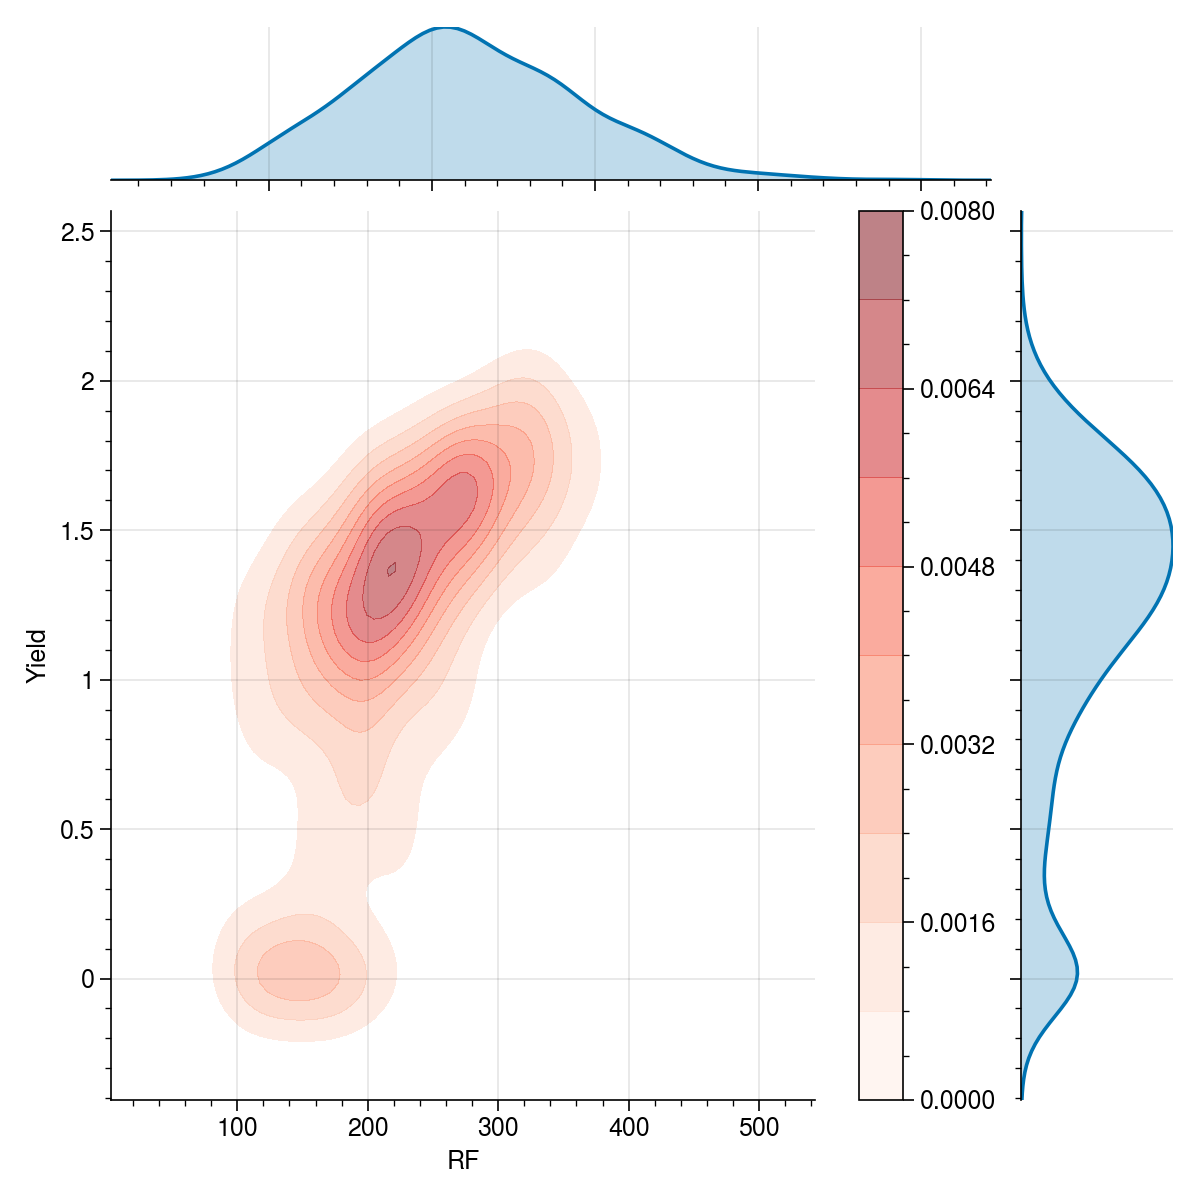

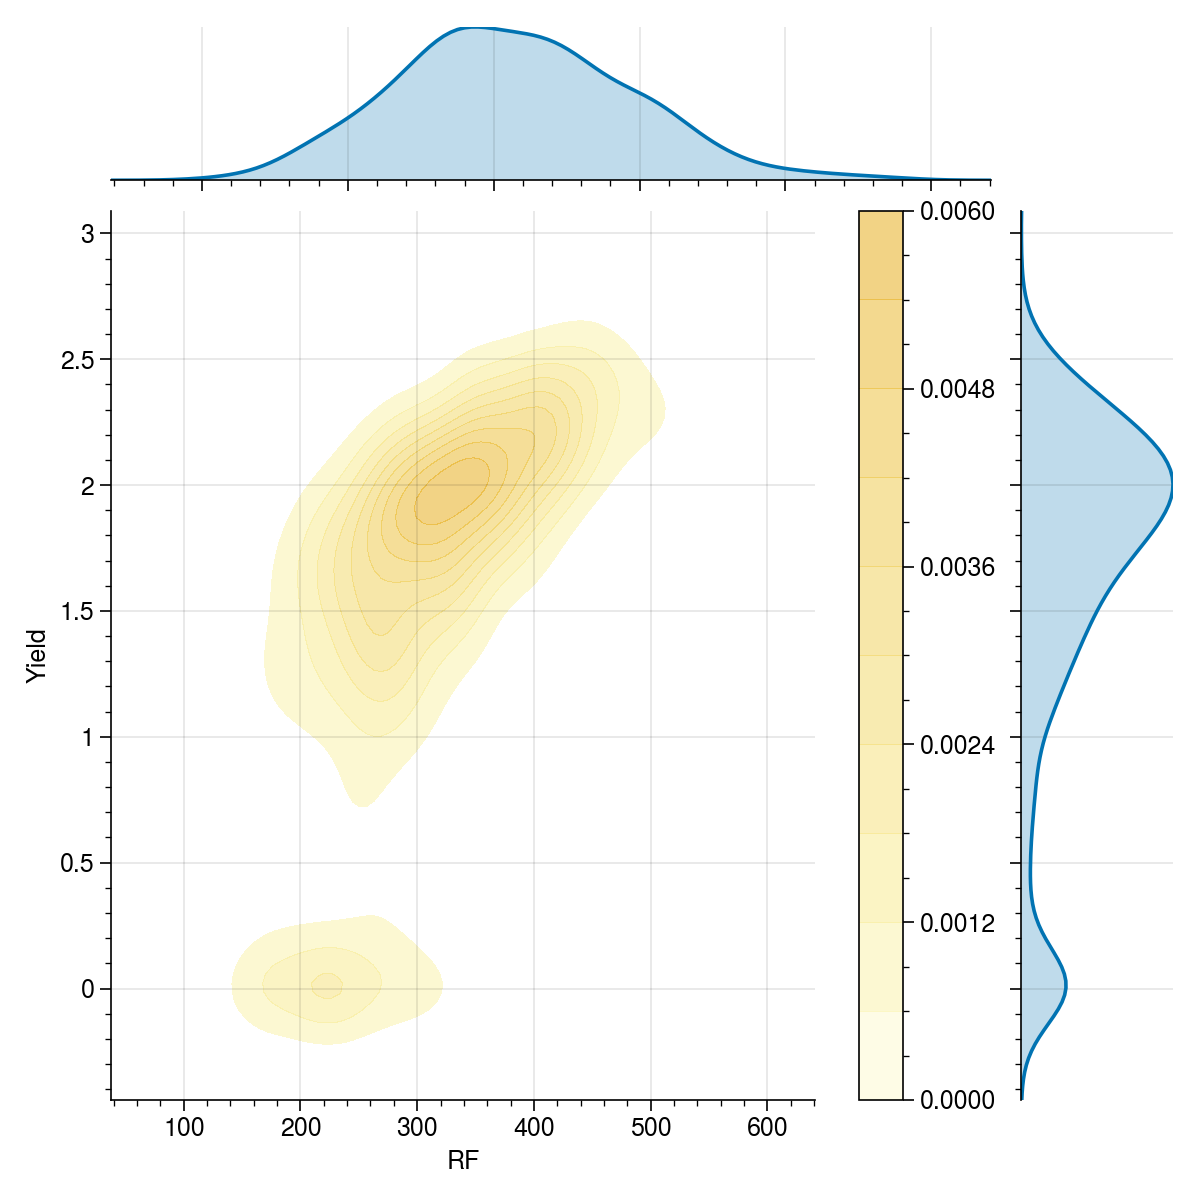

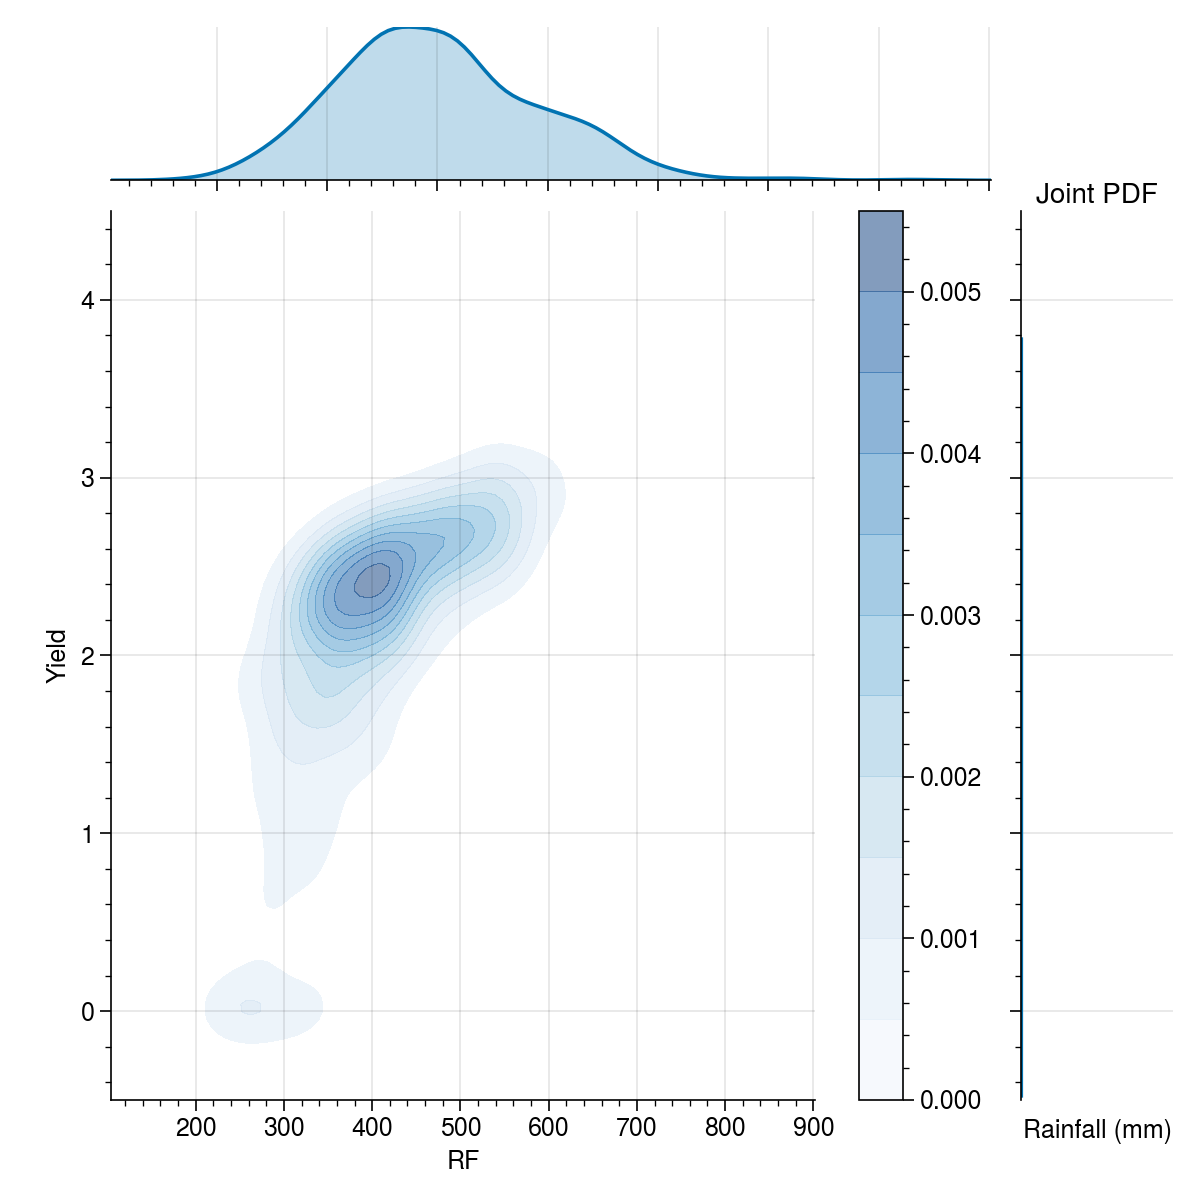

In [21]:
# seperate plots

ax = sns.jointplot(early.RF, early.Yield, alpha=0.5, kind='kde',
                 cmap="reds", shade=True, shade_lowest=False, cbar=True)
ax = sns.jointplot(med.RF, med.Yield, alpha=0.5,kind='kde',
                 cmap="orange1", shade=True, shade_lowest=False, cbar=True)
ax = sns.jointplot(late.RF, late.Yield, alpha=0.5,kind='kde',
                 cmap="blues", shade=True, shade_lowest=False, cbar=True) #greens

# Add labels to the plot
red = sns.color_palette("reds")[-2] #greens
yellow = sns.color_palette("orange1")[-3]
blue = sns.color_palette("blues")[-2]
#ax.text(350,.5, "early", size=16, color=red)
#ax.text(550,2,"medium",size=16,color=yellow)
#ax.text(680, 3.3, "late", size=16, color=blue)
plt.ylim(-0.5, 4.5)
plt.xlim(0,700)

plt.xlabel('Rainfall (mm)')
plt.title('Joint PDF')
  

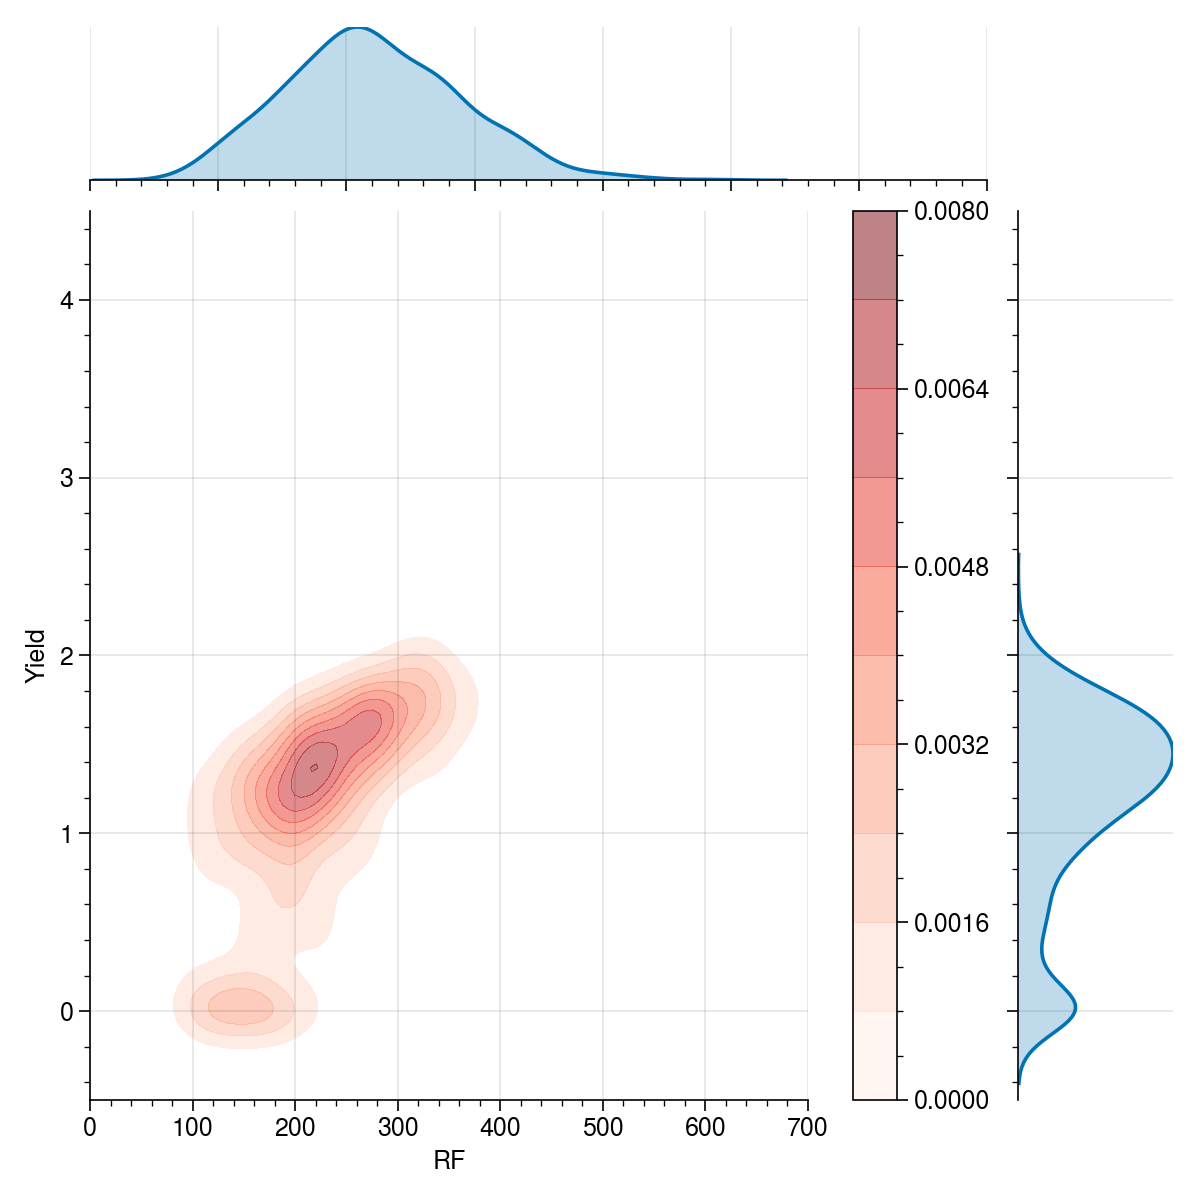

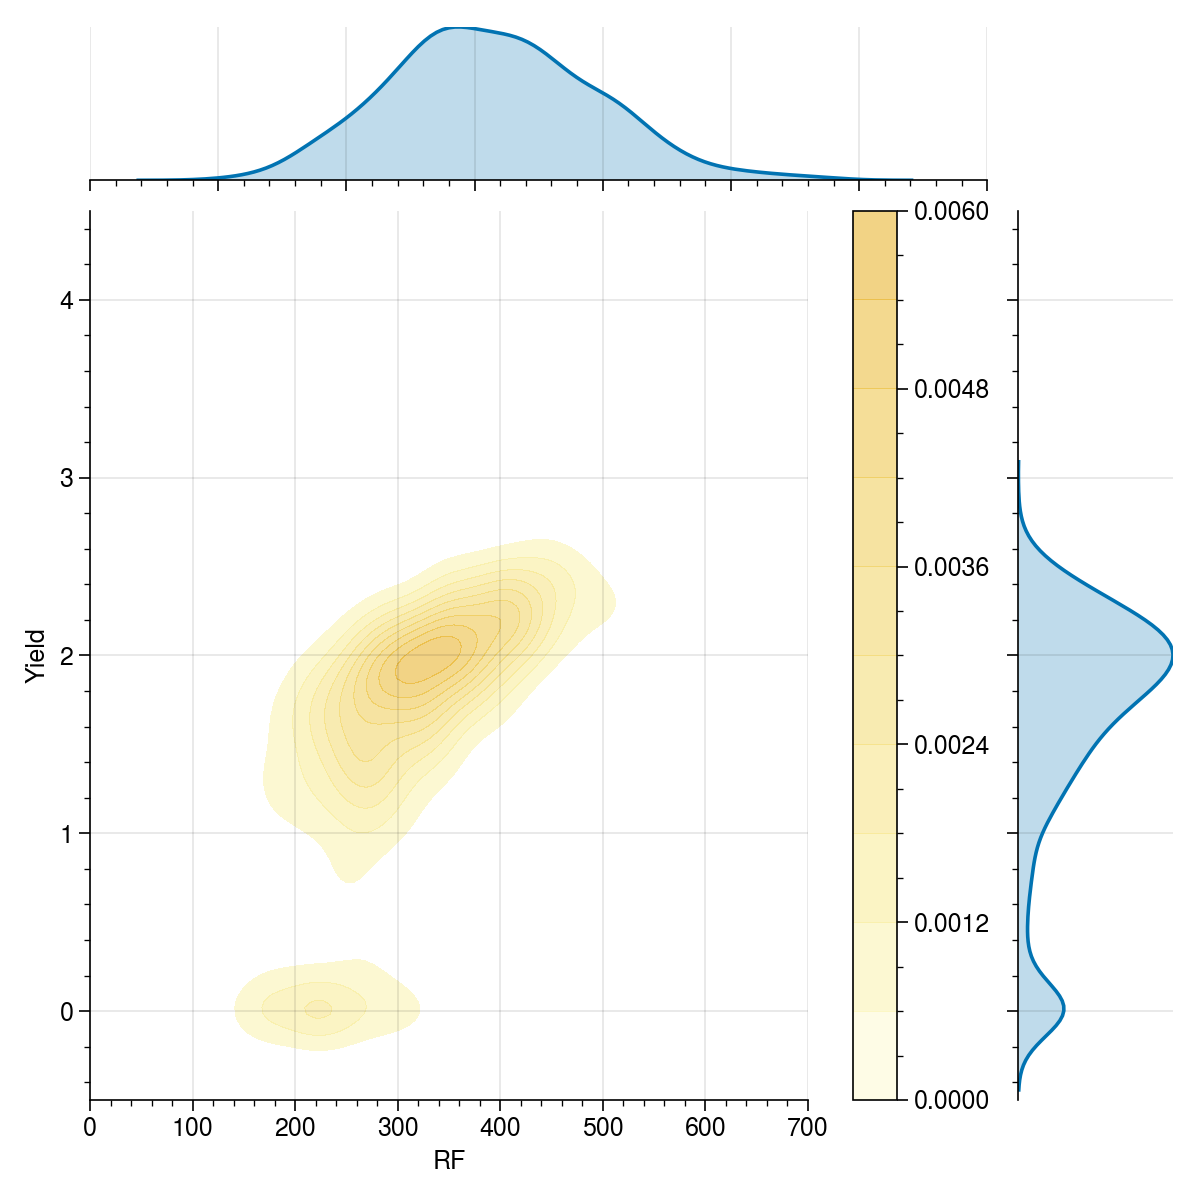

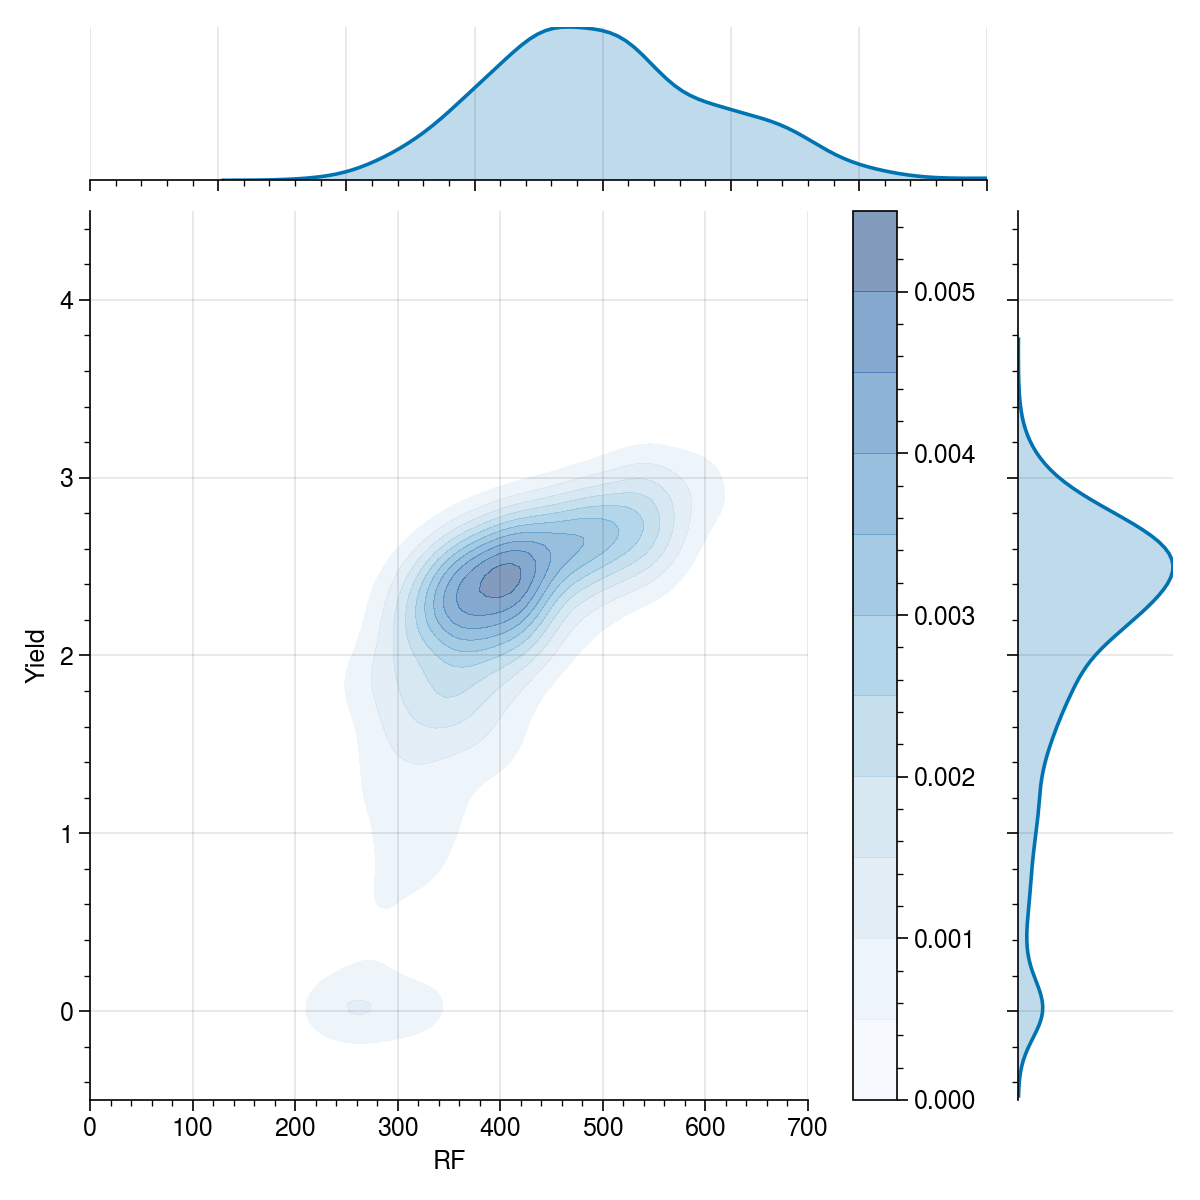

In [22]:
ax = sns.jointplot(early.RF, early.Yield, xlim=(0,700),ylim=(-0.5,4.5),alpha=0.5, kind='kde',cmap="reds", shade=True, shade_lowest=False, cbar=True)
ax = sns.jointplot(med.RF, med.Yield, xlim=(0,700),ylim=(-0.5,4.5),alpha=0.5,kind='kde',cmap="orange1", shade=True, shade_lowest=False, cbar=True)
ax = sns.jointplot(late.RF, late.Yield,xlim=(0,700),ylim=(-0.5,4.5), alpha=0.5,kind='kde',cmap="blues", shade=True, shade_lowest=False, cbar=True) #greens
    

Text(0.5, 0, 'Rainfall (mm)')

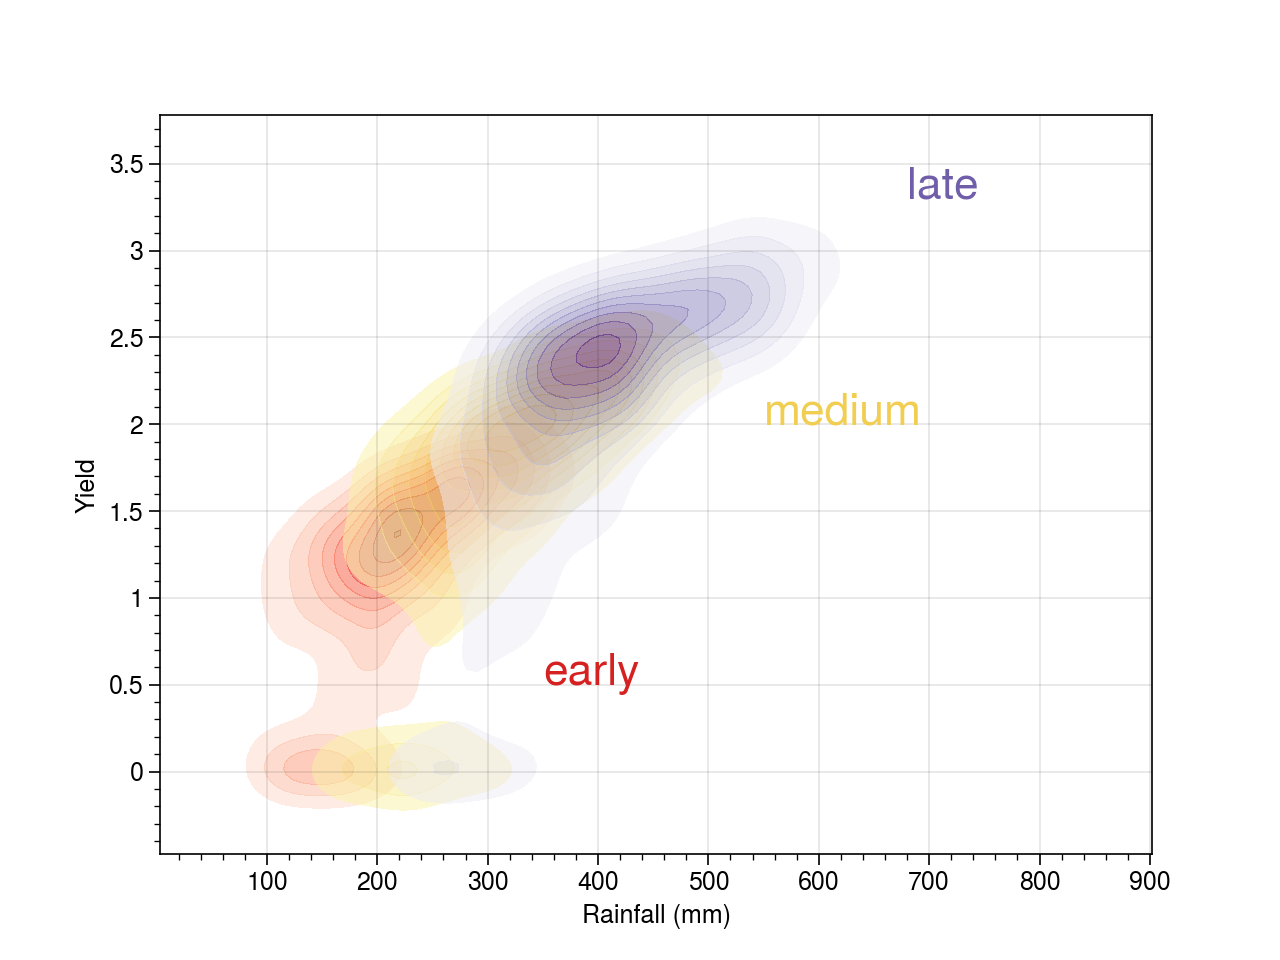

In [23]:
# 2D Density 
# code from here: https://seaborn.pydata.org/examples/multiple_joint_kde.html

result

# Subset the iris dataset by species
early = result.query("Category == 'Early (< 105 d)'")
med = result.query("Category == 'Medium (110 - 140 d)'")
late = result.query("Category == 'Late (145 + d)'")

# Set up the figure
f, ax = plt.subplots() # figsize=(15, 15)
#ax.set_aspect("equal")

# Draw the two density plots
ax = sns.kdeplot(early.RF, early.Yield, alpha=0.5,
                 cmap="reds", shade=True, shade_lowest=False)
ax = sns.kdeplot(med.RF, med.Yield, alpha=0.5,
                 cmap="orange1", shade=True, shade_lowest=False)
ax = sns.kdeplot(late.RF, late.Yield, alpha=0.5,
                 cmap="purples", shade=True, shade_lowest=False) #greens

# Add labels to the plot
red = sns.color_palette("reds")[-2] #greens
yellow = sns.color_palette("orange1")[-3]
blue = sns.color_palette("purples")[-2]
ax.text(350,.5, "early", size=16, color=red)
ax.text(550,2,"medium",size=16,color=yellow)
ax.text(680, 3.3, "late", size=16, color=blue)

plt.xlabel('Rainfall (mm)')

## Different options for density plot

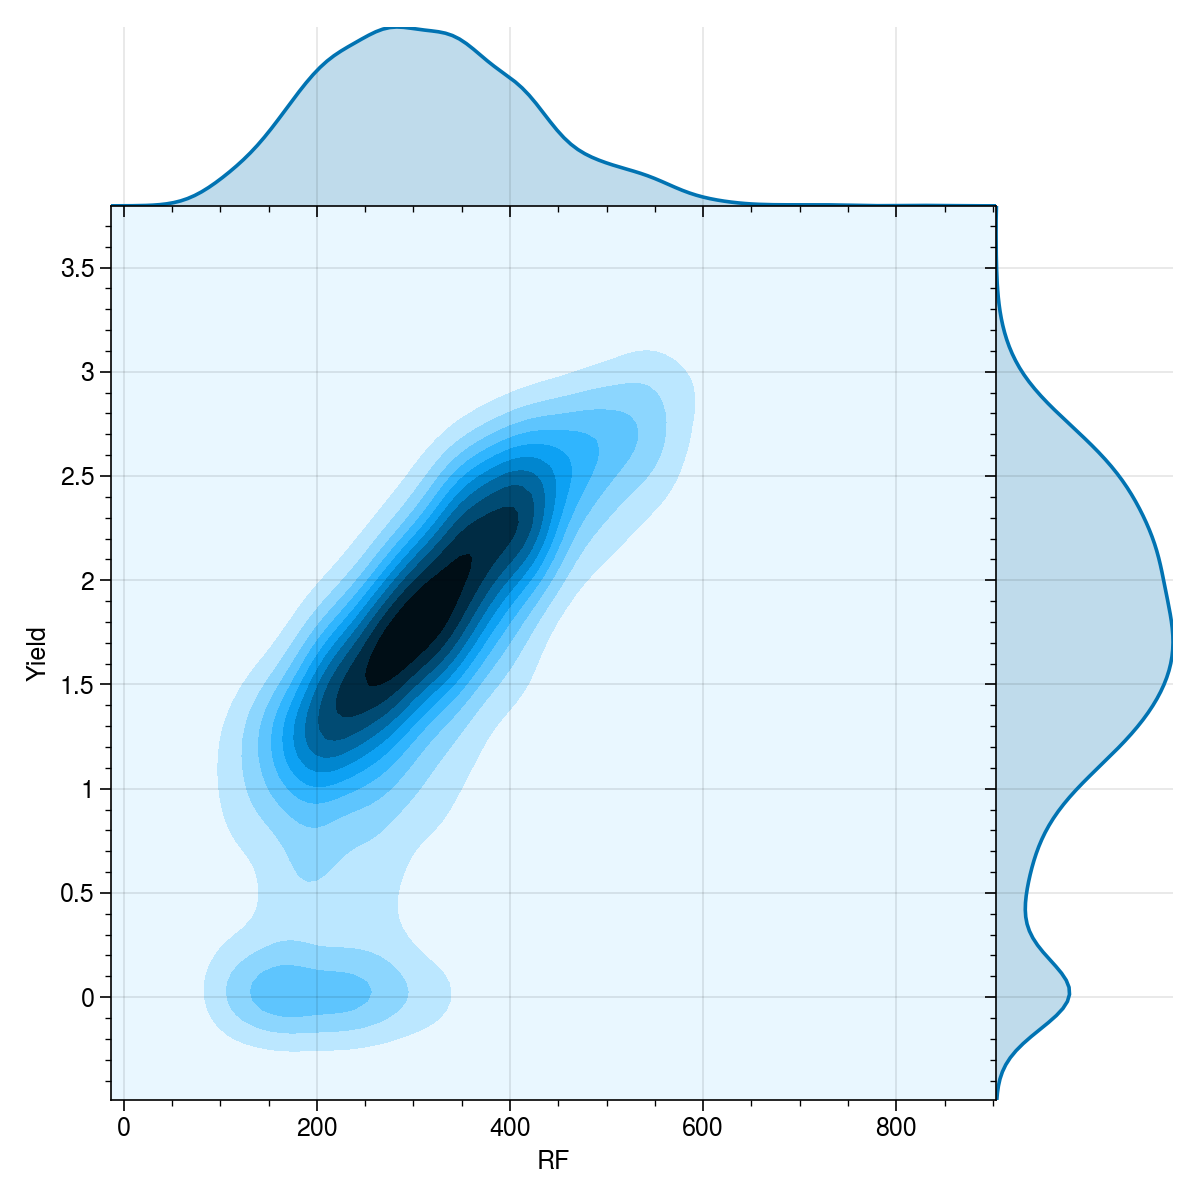

In [24]:
g = sns.jointplot("RF","Yield", data=result, kind="kde", space=0) #color=green

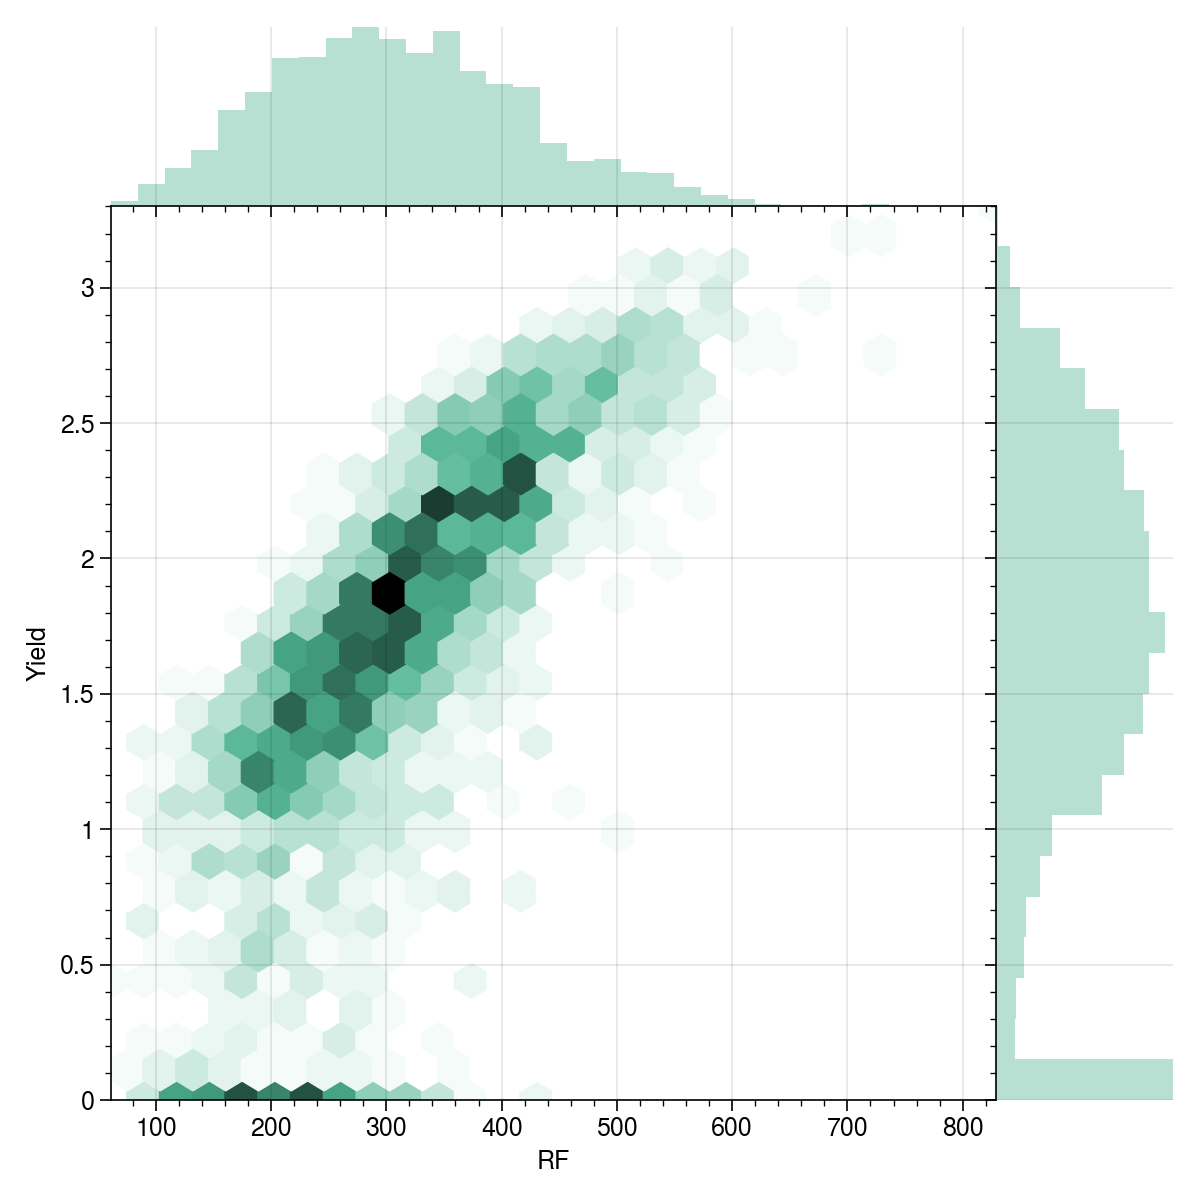

In [25]:
g = sns.jointplot("RF","Yield", data=result, kind="hex", space=0, color="#4CB391") #color=green

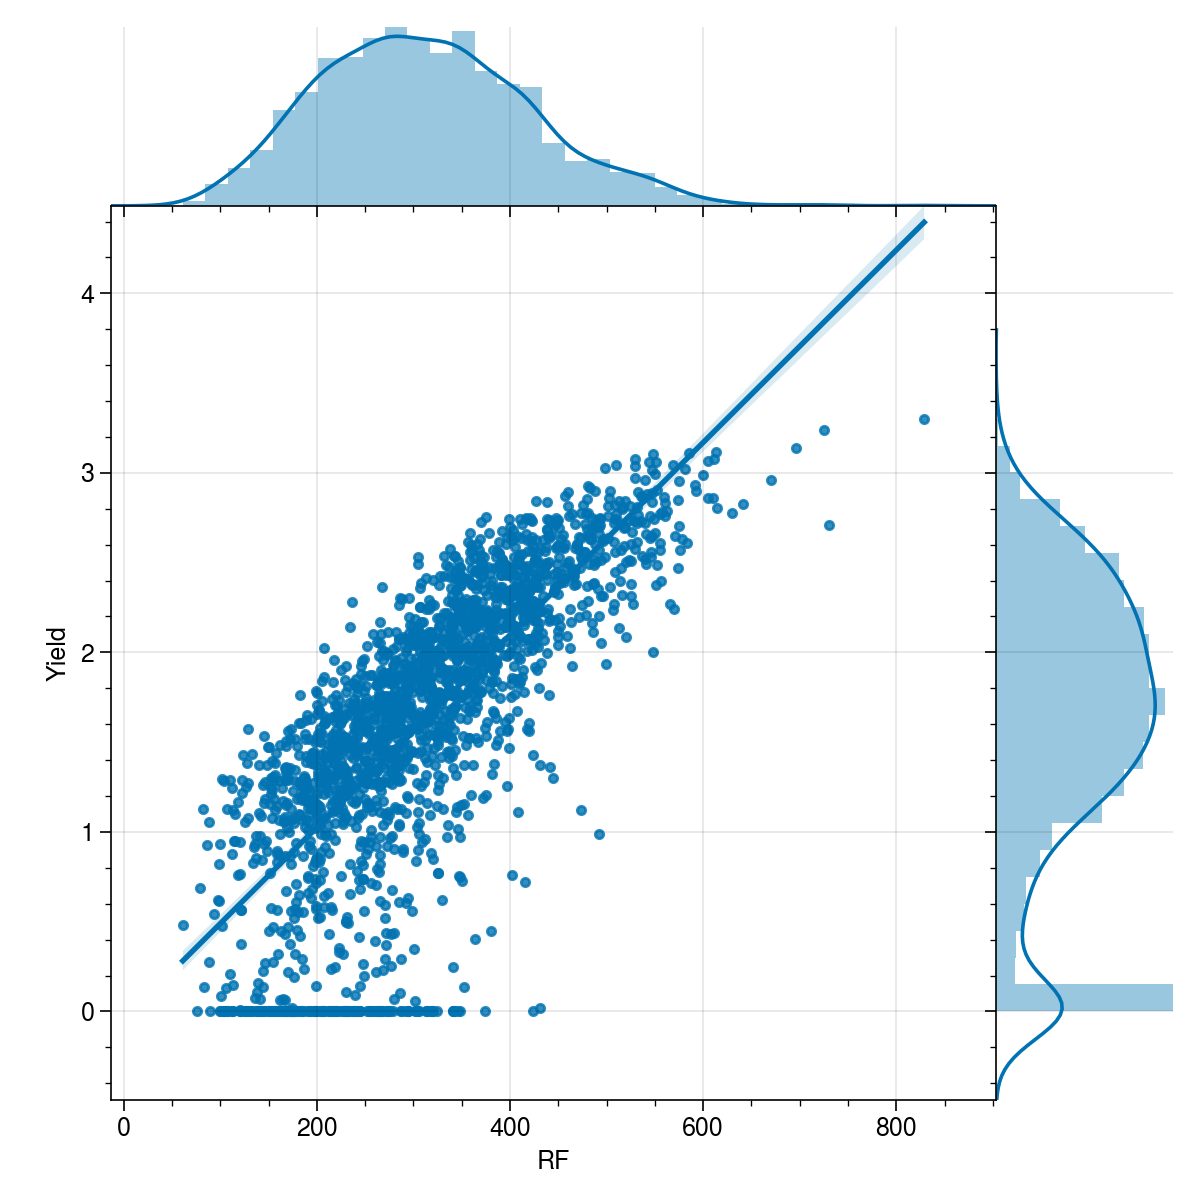

In [26]:
p = sns.jointplot("RF","Yield", data=result, kind="reg", space=0) #color=green

from: http://alanpryorjr.com/visualizations/seaborn/jointplot/jointplot/
`stat_func can be used to provide a function for computing a summary statistic from the data. The full x, y data vectors are passed in, so the function must provide one value or a tuple from many. As an example, I’ll provide tmin, which when used in this way will return the smallest value of x that was greater than its corresponding value of y.`


/opt/anaconda3/envs/maize-Toff/lib/python3.8/site-packages/seaborn/axisgrid.py:1848: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


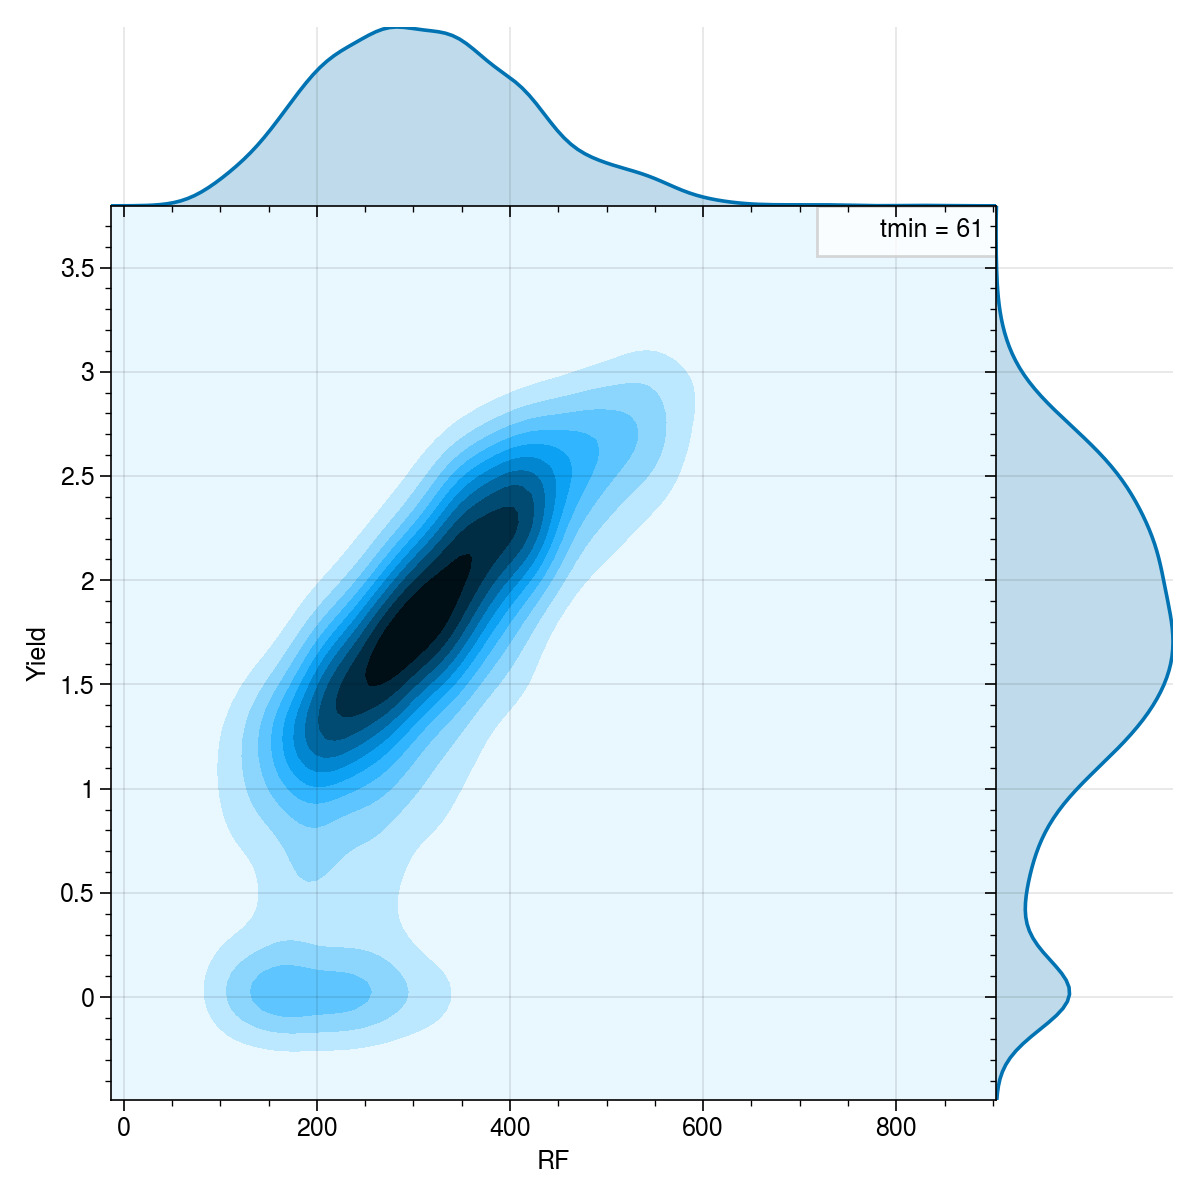

In [27]:
from scipy.stats import tmin
p = sns.jointplot("RF","Yield", data=result, kind="kde", space=0,stat_func=tmin)

# tmin is computing roughly the equivalent of the following
#print(df.loc[df.x>df.y,'x'].min())

`The dotted line shows where someone's time would lie if they ran the marathon at a perfectly steady pace. The fact that the distribution lies above this indicates (as you might expect) that most people slow down over the course of the marathon. If you have run competitively, you'll know that those who do the opposite—run faster during the second half of the race—are said to have "negative-split" the race.`
https://jakevdp.github.io/PythonDataScienceHandbook/04.14-visualization-with-seaborn.html

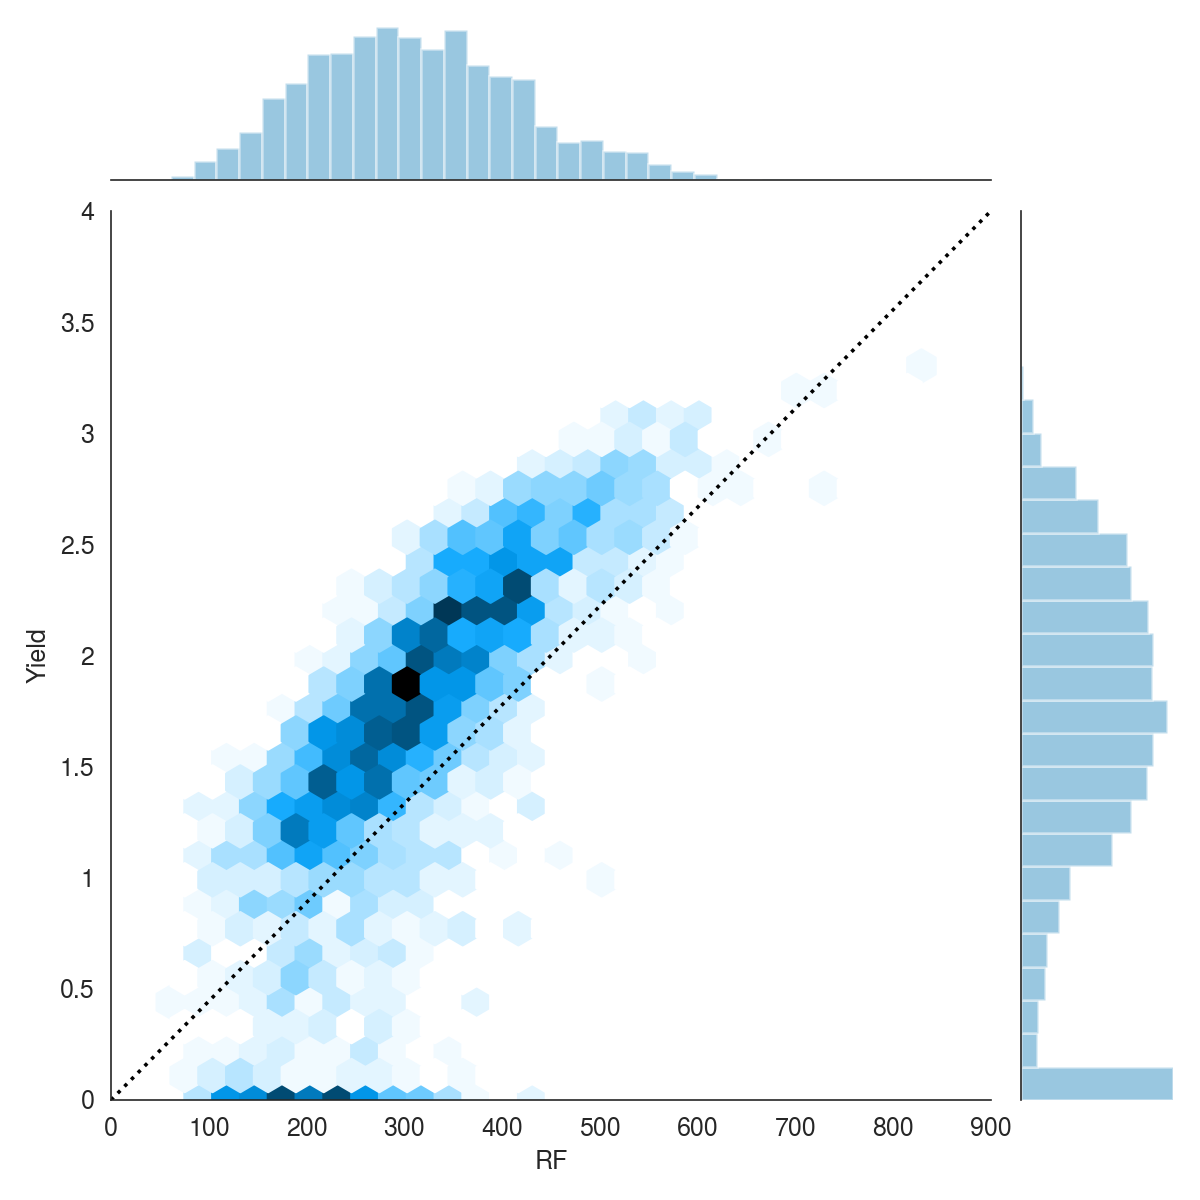

In [28]:
with sns.axes_style('white'):
    g = sns.jointplot("RF","Yield", data=result, kind='hex')
    g.ax_joint.plot(np.linspace(0, 900),
                    np.linspace(0, 4), ':k')

## Marcus' question: Are the varieties getting an equivalent amount of exposure?
How can we show that early-maturation variety minimizes exposure?

In order to get the distribution of rainfalls in each of these groupings, I would need to get back to the step we're they are summed.

In [29]:
# can mess around with output
output

lgp = 180
start = 21 
end = start + lgp

# this no longer works when output is a different var than the output from model run
#lists = [df[start:end]['R'] for df in output]
#sum_list = [sum(x) for x in zip(*lists)] # this is not the total rainfall of each sim. It's the rainfall for each day, summed.
#total_rf = [df[start:end]['R'].sum() for df in output] # this is the total_rf for sim

#plt.plot(sum_list)
#plt.plot(total_rf)

#plt.bar(range(0, len(sum_list)), sum_list)
#plt.bar(range(0, len(total_rf)), total_rf)

Basically what i want is to group the time series by the 50mm divisions and  then visualize those distributions

In [30]:
temp = pd.concat(output)
rf = temp['RF']
cl = temp['Cultivar']

In [31]:
# remove RF and Cultivar from temp dataframe and transpose
temp = temp.drop(['RF','Cultivar'], axis = 1).T

In [32]:
# this takes a really long time to run
#temp.diff().hist(alpha=0.5, bins=50)

In [33]:
# here are the cuts
print((rf.min() + rf.max())/50)

16.635194470478655


In [34]:
pd.cut(rf, 16)
rf = rf.to_frame()
rf['binned'] = pd.cut(rf['RF'], 16)

In [35]:
# maybe now give a new ID to each row in rf and each column in temp
rf.insert(0, 'New_ID', range(1, 1 + len(rf)))

temp.columns = range(1, 1 + len(rf))
temp

1         2         3         4         5         6          7    \
60   8.789951   0.00000  0.473451  8.120533  0.000000  0.000000   0.000000   
61   0.000000   0.00000  7.144679  0.000000  0.000000  0.000000   0.000000   
62   0.000000  20.67938  0.000000  0.000000  0.000000  4.146959  23.799307   
63   0.000000   0.00000  0.000000  0.000000  6.681432  3.143046   0.000000   
64   0.000000   0.00000  0.000000  0.000000  0.000000  0.000000   0.000000   
..        ...       ...       ...       ...       ...       ...        ...   
270       NaN       NaN       NaN       NaN       NaN       NaN        NaN   
271       NaN       NaN       NaN       NaN       NaN       NaN        NaN   
272       NaN       NaN       NaN       NaN       NaN       NaN        NaN   
273       NaN       NaN       NaN       NaN       NaN       NaN        NaN   
274       NaN       NaN       NaN       NaN       NaN       NaN        NaN   

          8          9         10   ...  291        292        293        294  \
60   0.000000   0.000000  0.593032  ...  0.0   0.000000   0.000000   2.940788   
61   0.445488   0.000000  0.000000  ...  0.0   0.000000   0.000000  26.250461   
62   0.000000  13.006731  0.000000  ...  0.0   0.000000   0.000000   1.997651   
63   5.617433   4.962770  0.000000  ...  0.0  12.706554   0.000000   0.000000   
64   0.000000  31.112626  0.000000  ...  0.0   6.595694  15.025709   0.000000   
..        ...        ...       ...  ...  ...        ...        ...        ...   
270       NaN        NaN       NaN  ...  0.0   0.000000   0.000000  10.142179   
271       NaN        NaN       NaN  ...  0.0   9.060264  19.052532   0.000000   
272       NaN        NaN       NaN  ...  0.0   0.000000   4.668306  10.665777   
273       NaN        NaN       NaN  ...  0.0   0.000000   0.000000   0.000000   
274       NaN        NaN       NaN  ...  0.0   0.000000   0.000000   0.000000   

           295       296        297        298        299        300  
60    0.000000  0.000000   0.000000   0.000000   0.000000   0.000000  
61    0.000000  8.530566   0.033065   8.712060  10.707872   0.000000  
62    0.000000  0.000000   5.641138  25.565567   0.000000  37.971814  
63    0.000000  0.000000  14.128128   0.000000   0.000000   0.000000  
64    0.000000  0.000000   0.000000   0.000000   0.000000   0.000000  
..         ...       ...        ...        ...        ...        ...  
270   2.185978  0.000000   0.000000  12.875204   0.000000   7.052006  
271   0.000000  0.000000   0.000000   0.000000   0.000000   0.000000  
272   0.000000  0.000000   0.000000   0.000000   0.000000  12.127895  
273  30.261942  0.000000  26.573961   1.348920   1.135916   0.000000  
274   5.348533  4.173988   0.237678   0.000000   0.000000   0.000000  

[215 rows x 300 columns]

In [36]:
rf.sort_values(by='binned')

New_ID          RF              binned
8       39   81.488719    (80.82, 123.288]
9       30  101.797862    (80.82, 123.288]
7       28  104.414183    (80.82, 123.288]
5        6  109.829418    (80.82, 123.288]
5       26   82.937344    (80.82, 123.288]
..     ...         ...                 ...
3      284  626.840540  (624.874, 666.673]
1      282  688.900294  (666.673, 708.472]
9      290  706.324475  (666.673, 708.472]
5      296  671.429464  (666.673, 708.472]
0      261  750.271004  (708.472, 750.271]

[300 rows x 3 columns]

In [37]:
# say that we want the first bin which is sim 22 and 13
first = [22,13] # need to automate this

# save the simulation numbers associated with each bin as a list
df2 = rf.groupby('binned').apply(lambda x: x['New_ID'].unique()).to_frame().reset_index()

In [38]:
rf.binned.value_counts()


(290.483, 332.282]    43
(332.282, 374.081]    40
(248.684, 290.483]    32
(206.885, 248.684]    30
(415.88, 457.679]     28
(457.679, 499.478]    24
(499.478, 541.277]    23
(374.081, 415.88]     20
(165.087, 206.885]    17
(541.277, 583.075]     9
(123.288, 165.087]     9
(624.874, 666.673]     7
(583.075, 624.874]     7
(80.82, 123.288]       7
(666.673, 708.472]     3
(708.472, 750.271]     1
Name: binned, dtype: int64

In [39]:
temp

1         2         3         4         5         6          7    \
60   8.789951   0.00000  0.473451  8.120533  0.000000  0.000000   0.000000   
61   0.000000   0.00000  7.144679  0.000000  0.000000  0.000000   0.000000   
62   0.000000  20.67938  0.000000  0.000000  0.000000  4.146959  23.799307   
63   0.000000   0.00000  0.000000  0.000000  6.681432  3.143046   0.000000   
64   0.000000   0.00000  0.000000  0.000000  0.000000  0.000000   0.000000   
..        ...       ...       ...       ...       ...       ...        ...   
270       NaN       NaN       NaN       NaN       NaN       NaN        NaN   
271       NaN       NaN       NaN       NaN       NaN       NaN        NaN   
272       NaN       NaN       NaN       NaN       NaN       NaN        NaN   
273       NaN       NaN       NaN       NaN       NaN       NaN        NaN   
274       NaN       NaN       NaN       NaN       NaN       NaN        NaN   

          8          9         10   ...  291        292        293        294  \
60   0.000000   0.000000  0.593032  ...  0.0   0.000000   0.000000   2.940788   
61   0.445488   0.000000  0.000000  ...  0.0   0.000000   0.000000  26.250461   
62   0.000000  13.006731  0.000000  ...  0.0   0.000000   0.000000   1.997651   
63   5.617433   4.962770  0.000000  ...  0.0  12.706554   0.000000   0.000000   
64   0.000000  31.112626  0.000000  ...  0.0   6.595694  15.025709   0.000000   
..        ...        ...       ...  ...  ...        ...        ...        ...   
270       NaN        NaN       NaN  ...  0.0   0.000000   0.000000  10.142179   
271       NaN        NaN       NaN  ...  0.0   9.060264  19.052532   0.000000   
272       NaN        NaN       NaN  ...  0.0   0.000000   4.668306  10.665777   
273       NaN        NaN       NaN  ...  0.0   0.000000   0.000000   0.000000   
274       NaN        NaN       NaN  ...  0.0   0.000000   0.000000   0.000000   

           295       296        297        298        299        300  
60    0.000000  0.000000   0.000000   0.000000   0.000000   0.000000  
61    0.000000  8.530566   0.033065   8.712060  10.707872   0.000000  
62    0.000000  0.000000   5.641138  25.565567   0.000000  37.971814  
63    0.000000  0.000000  14.128128   0.000000   0.000000   0.000000  
64    0.000000  0.000000   0.000000   0.000000   0.000000   0.000000  
..         ...       ...        ...        ...        ...        ...  
270   2.185978  0.000000   0.000000  12.875204   0.000000   7.052006  
271   0.000000  0.000000   0.000000   0.000000   0.000000   0.000000  
272   0.000000  0.000000   0.000000   0.000000   0.000000  12.127895  
273  30.261942  0.000000  26.573961   1.348920   1.135916   0.000000  
274   5.348533  4.173988   0.237678   0.000000   0.000000   0.000000  

[215 rows x 300 columns]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9f0e630eb0>,
      dtype=object)

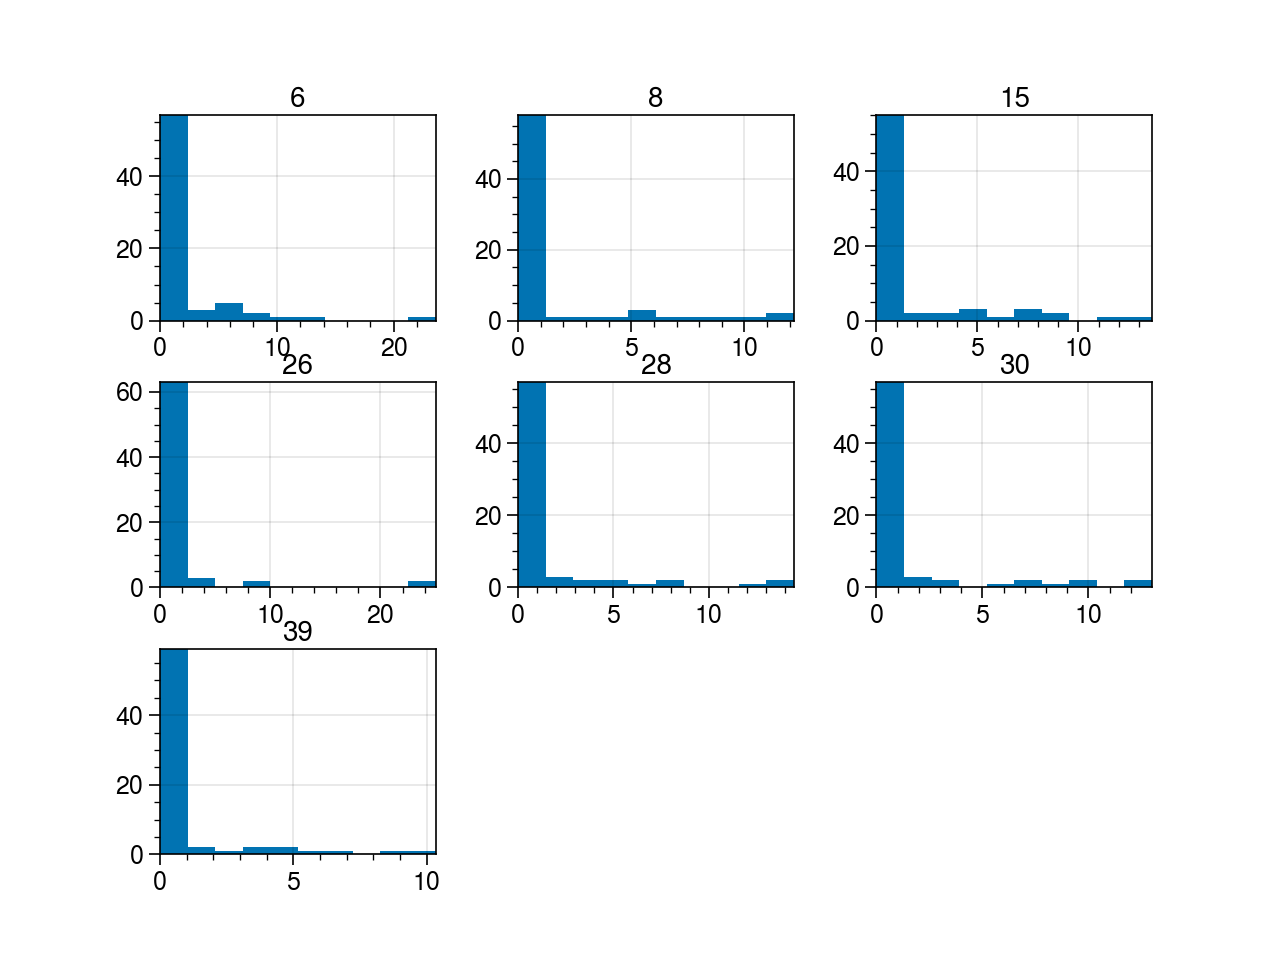

In [40]:
# use this to select first row, first column (zero index)
df2[0].iloc[0]

# now use it to select those columns from temp 
temp[df2[0].iloc[0]]

# plot distribution of these two columns together
df = temp[df2[0].iloc[0]]

#for col in df.columns:
#  sns.distplot(df[[col]], hist=False, rug=True)
df.dropna().hist()

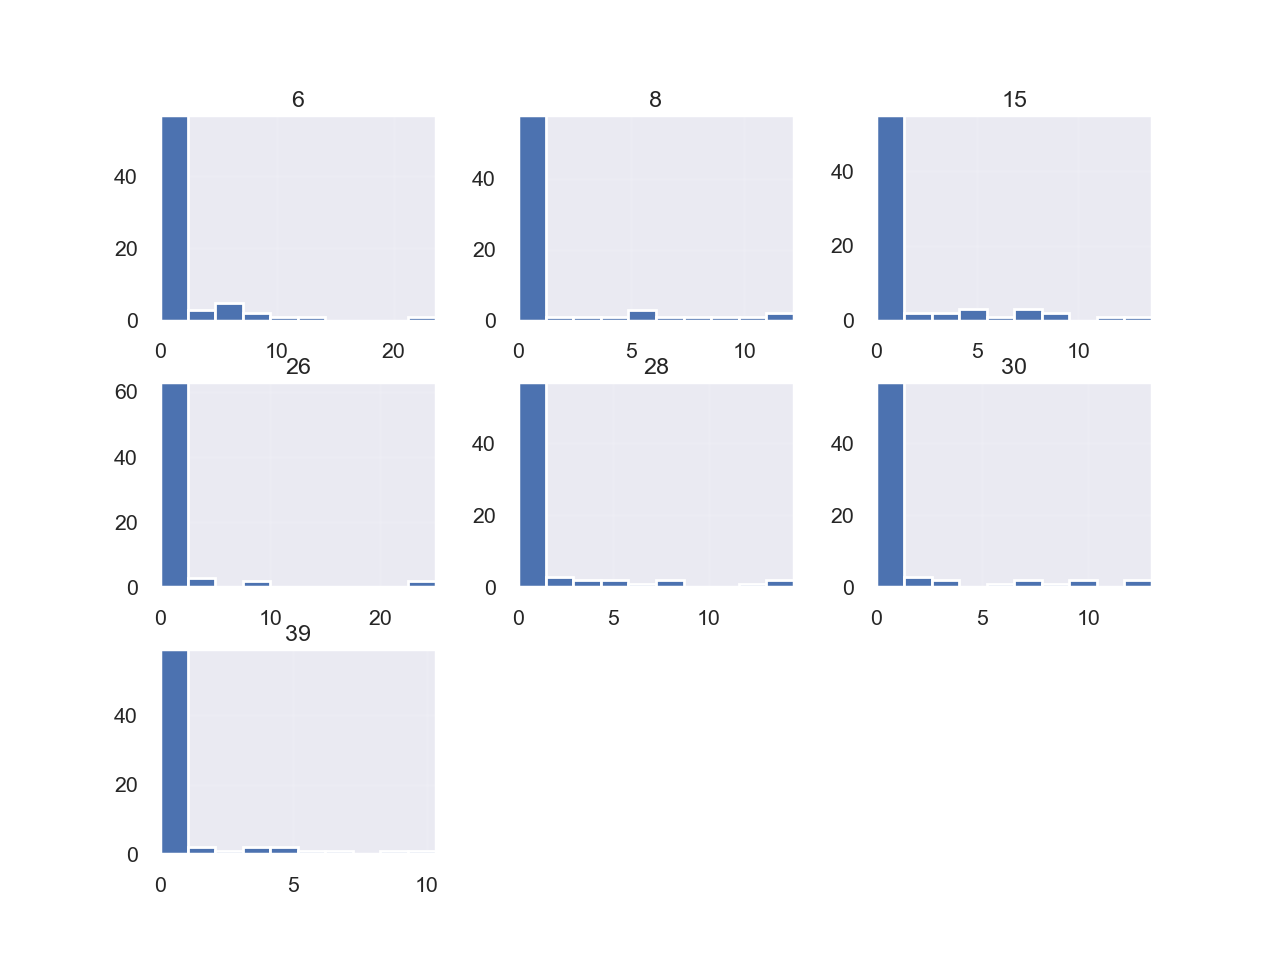

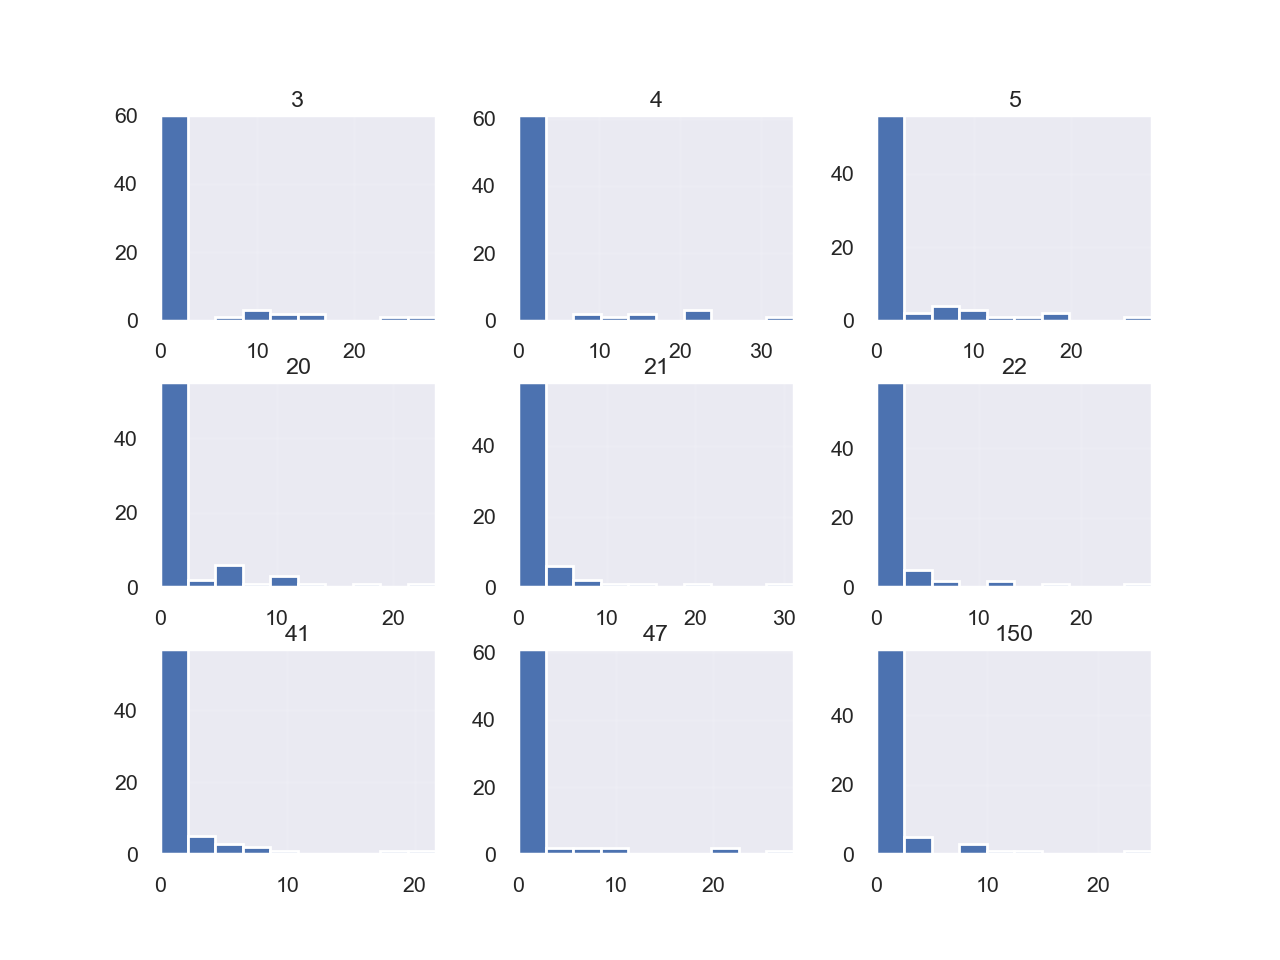

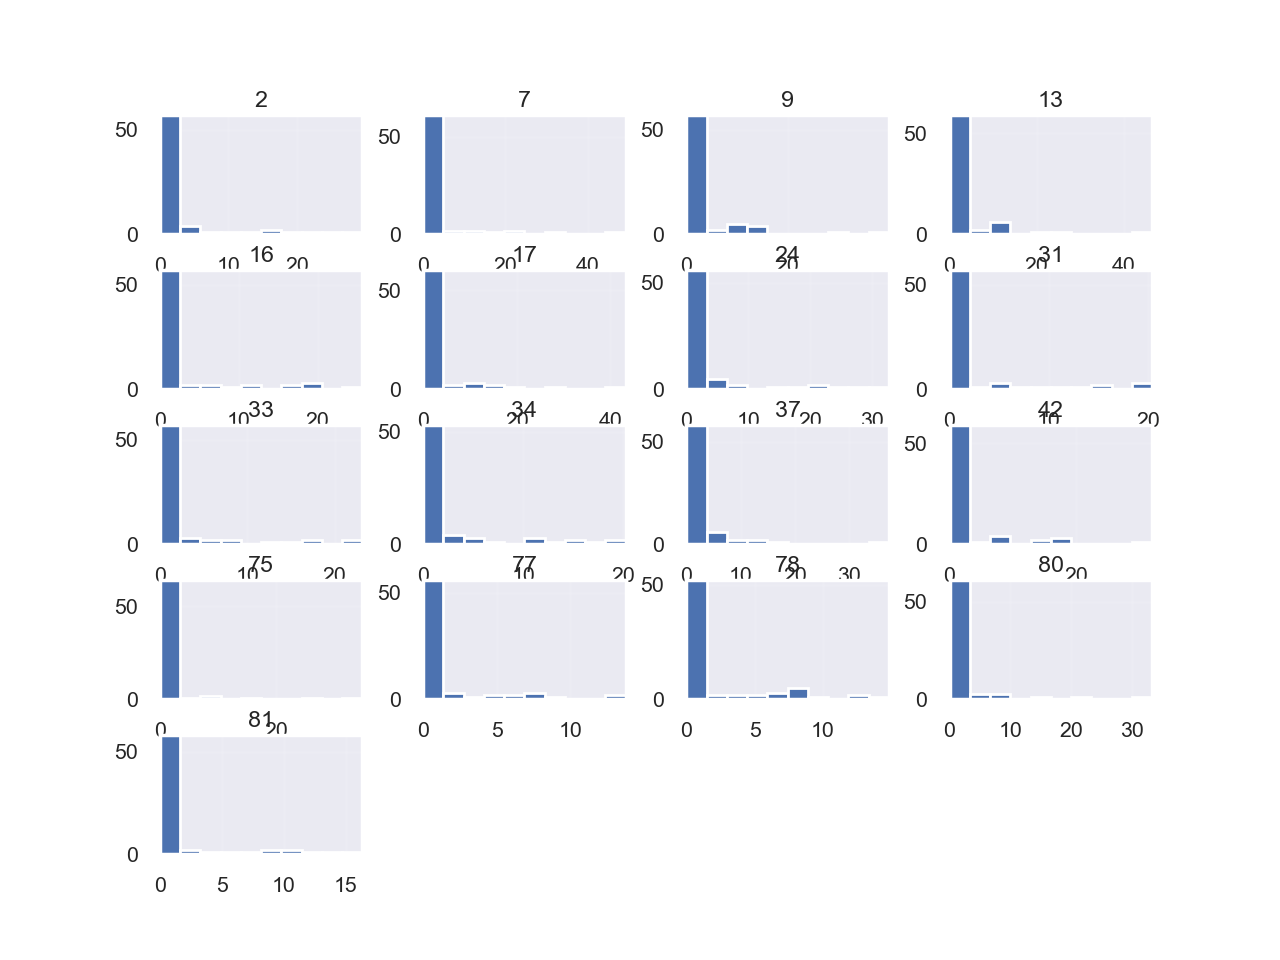

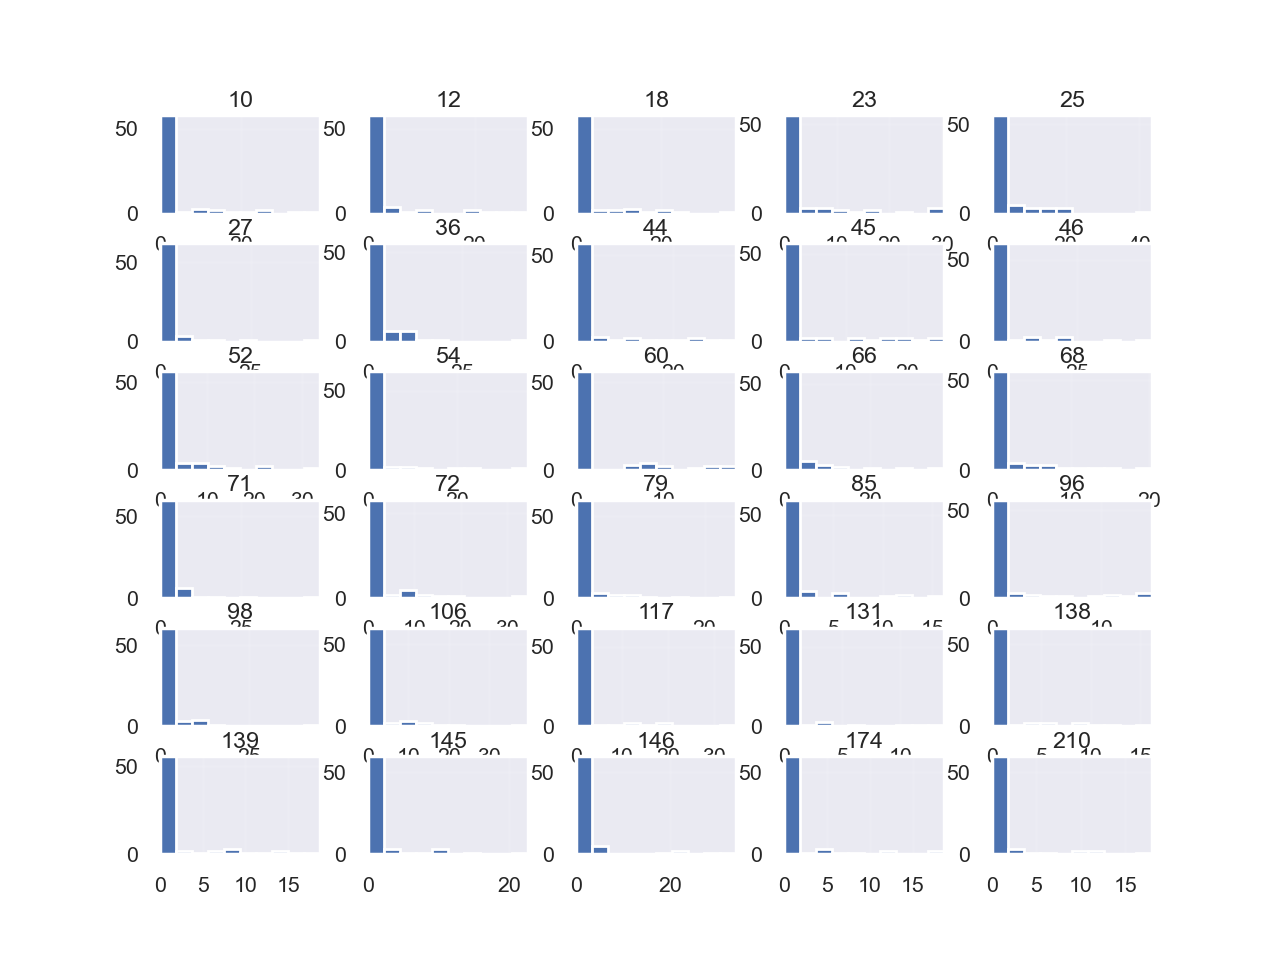

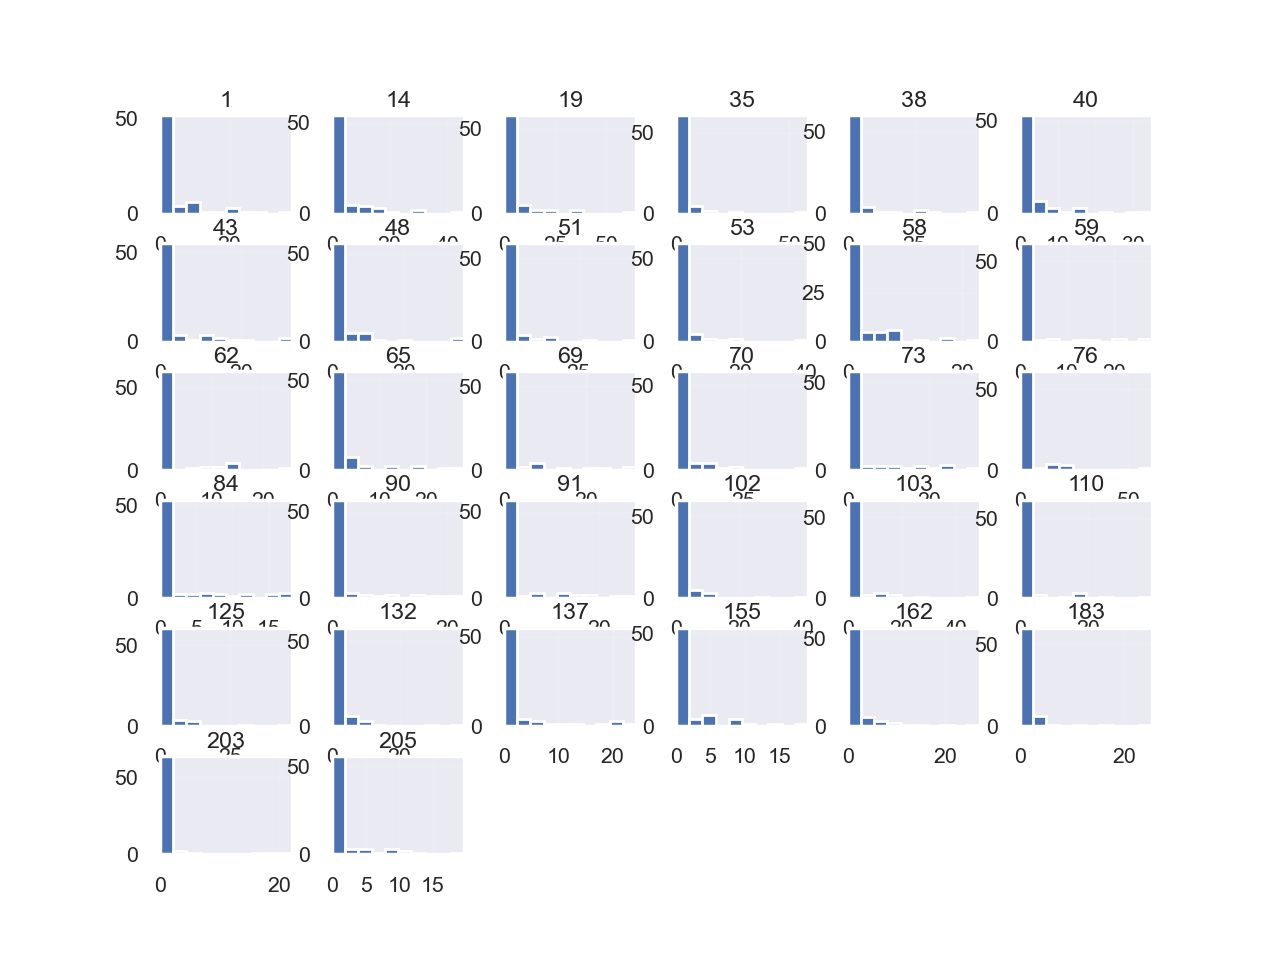

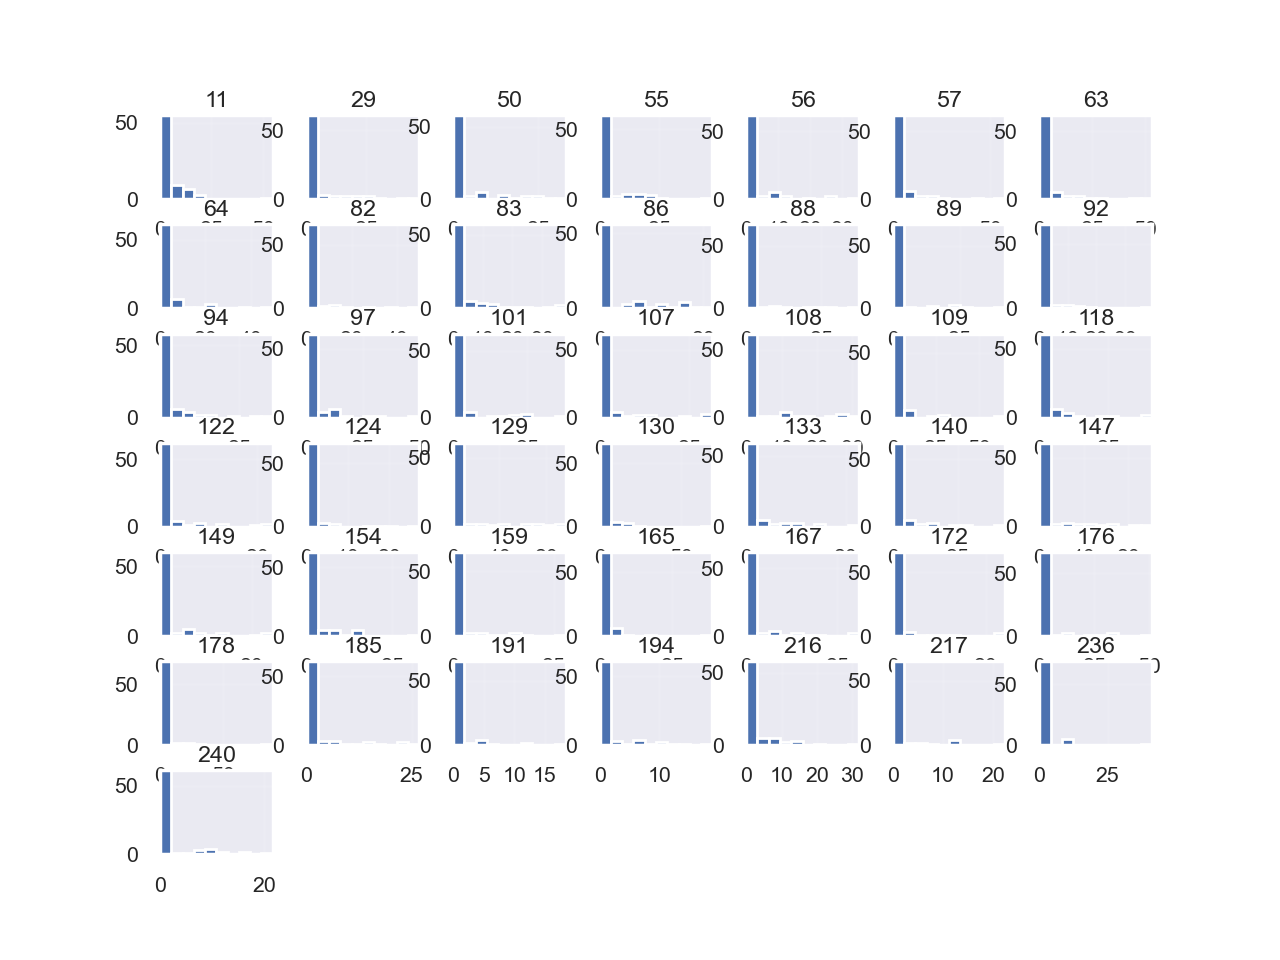

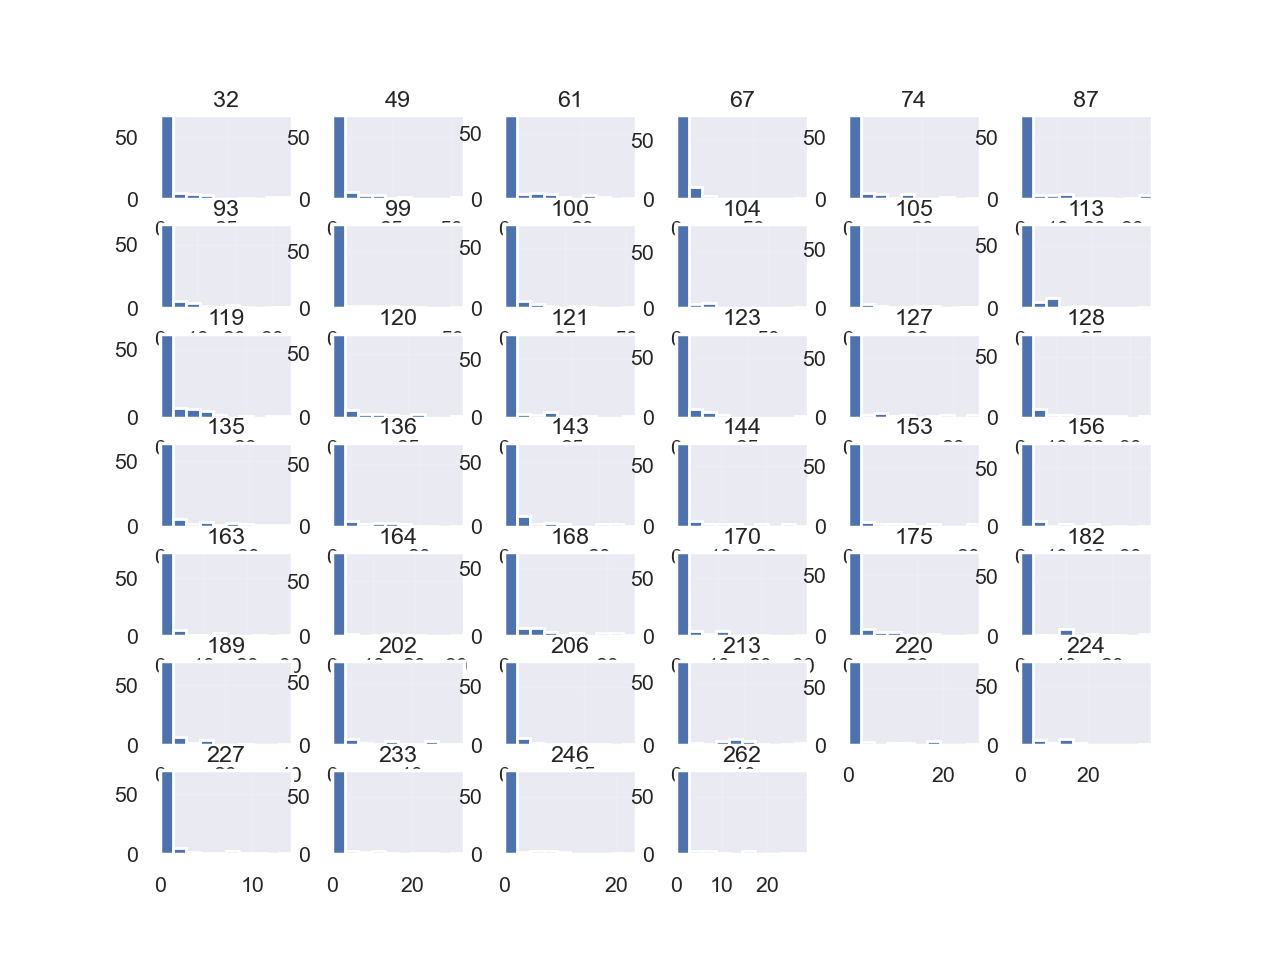

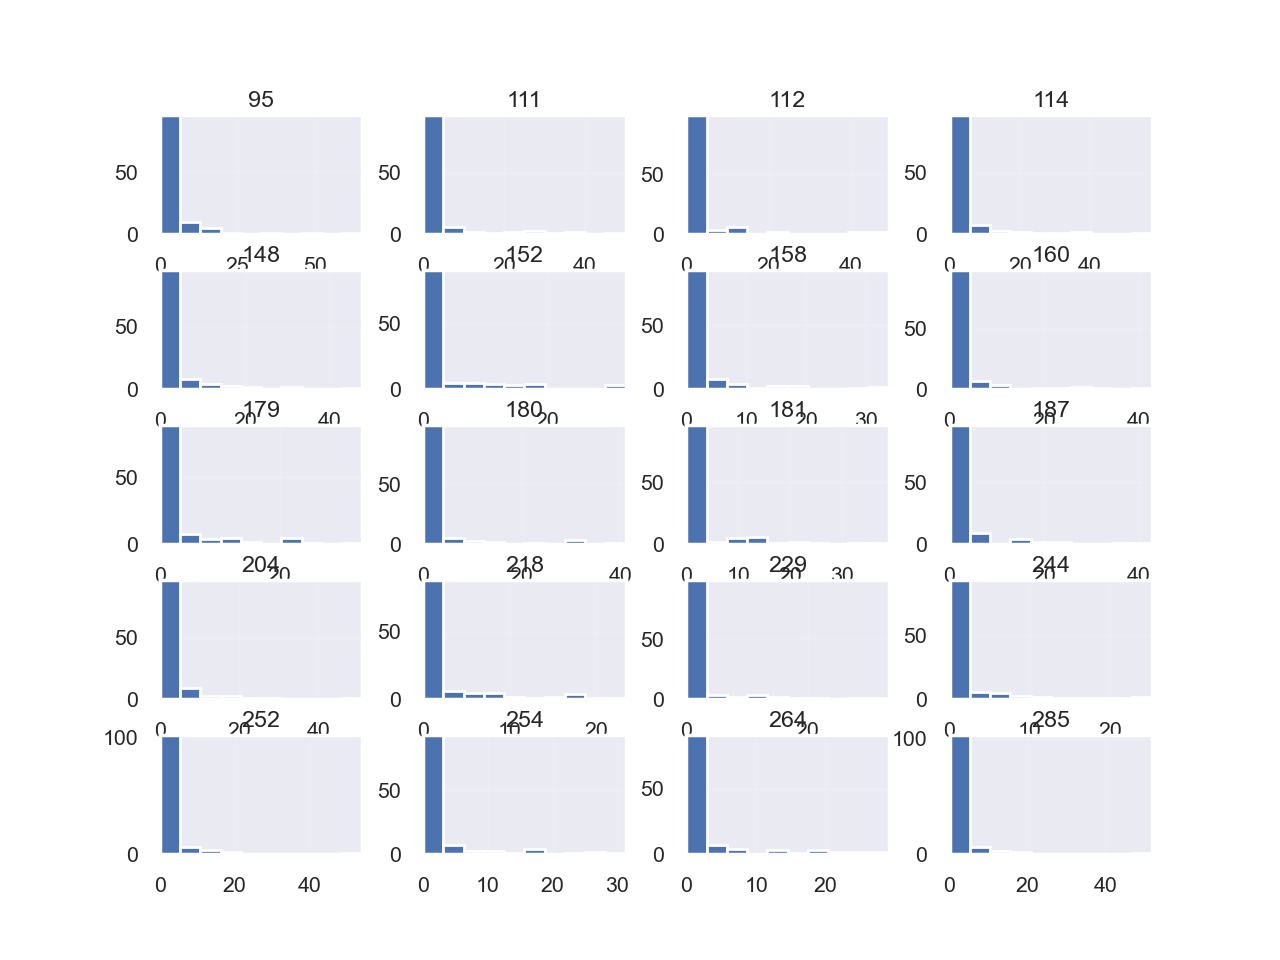

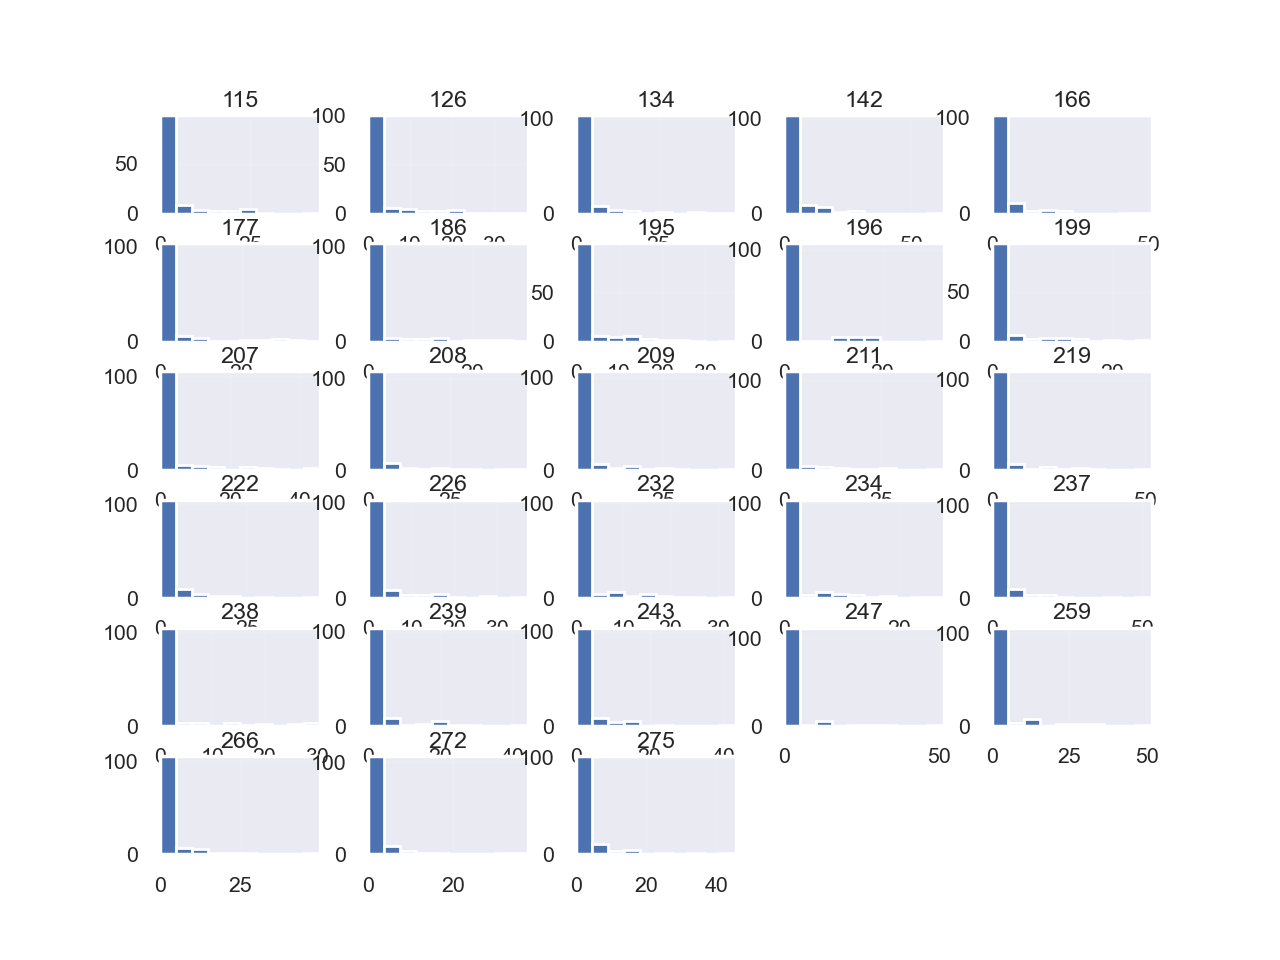

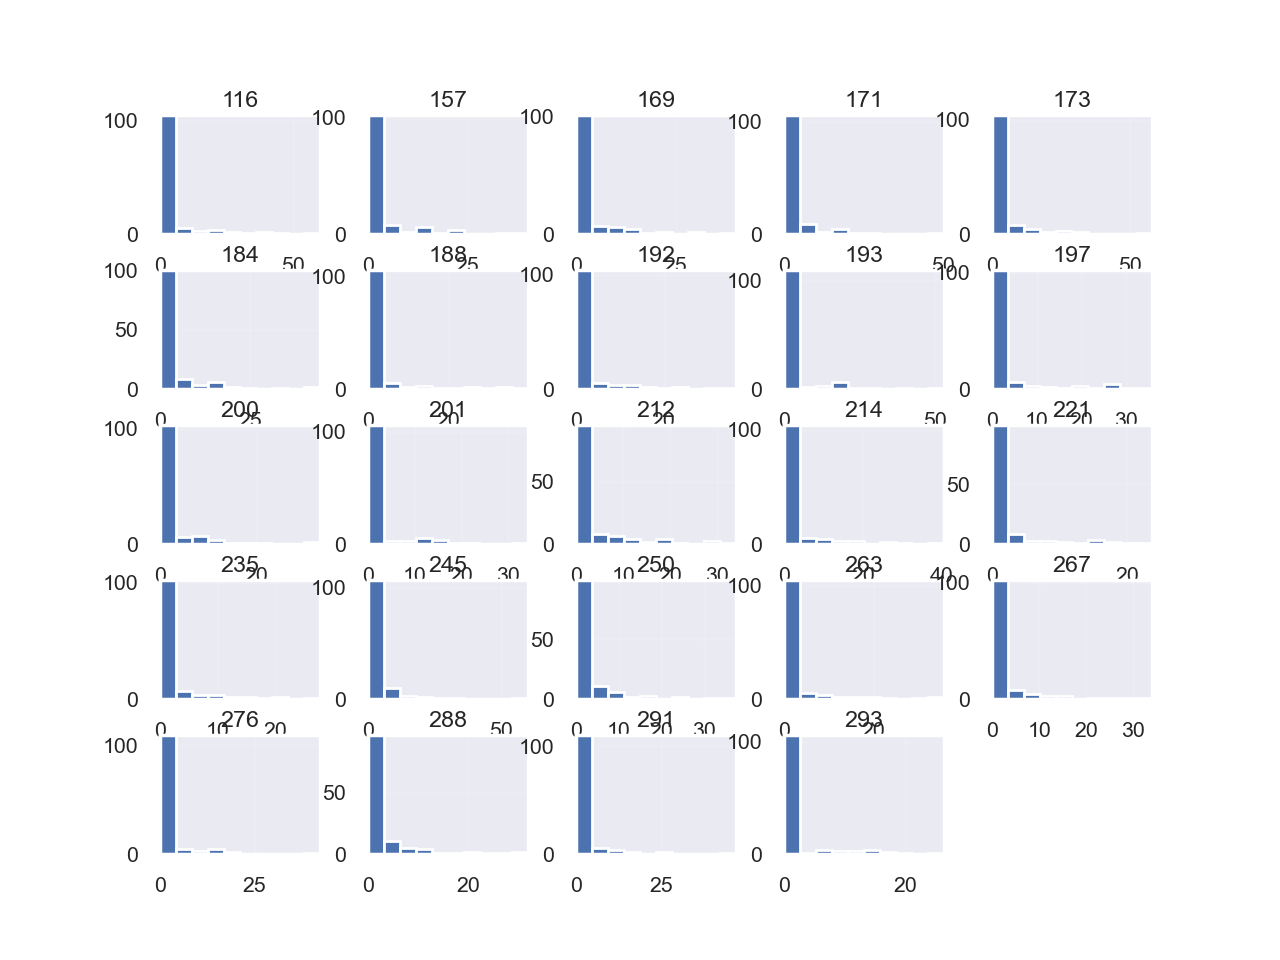

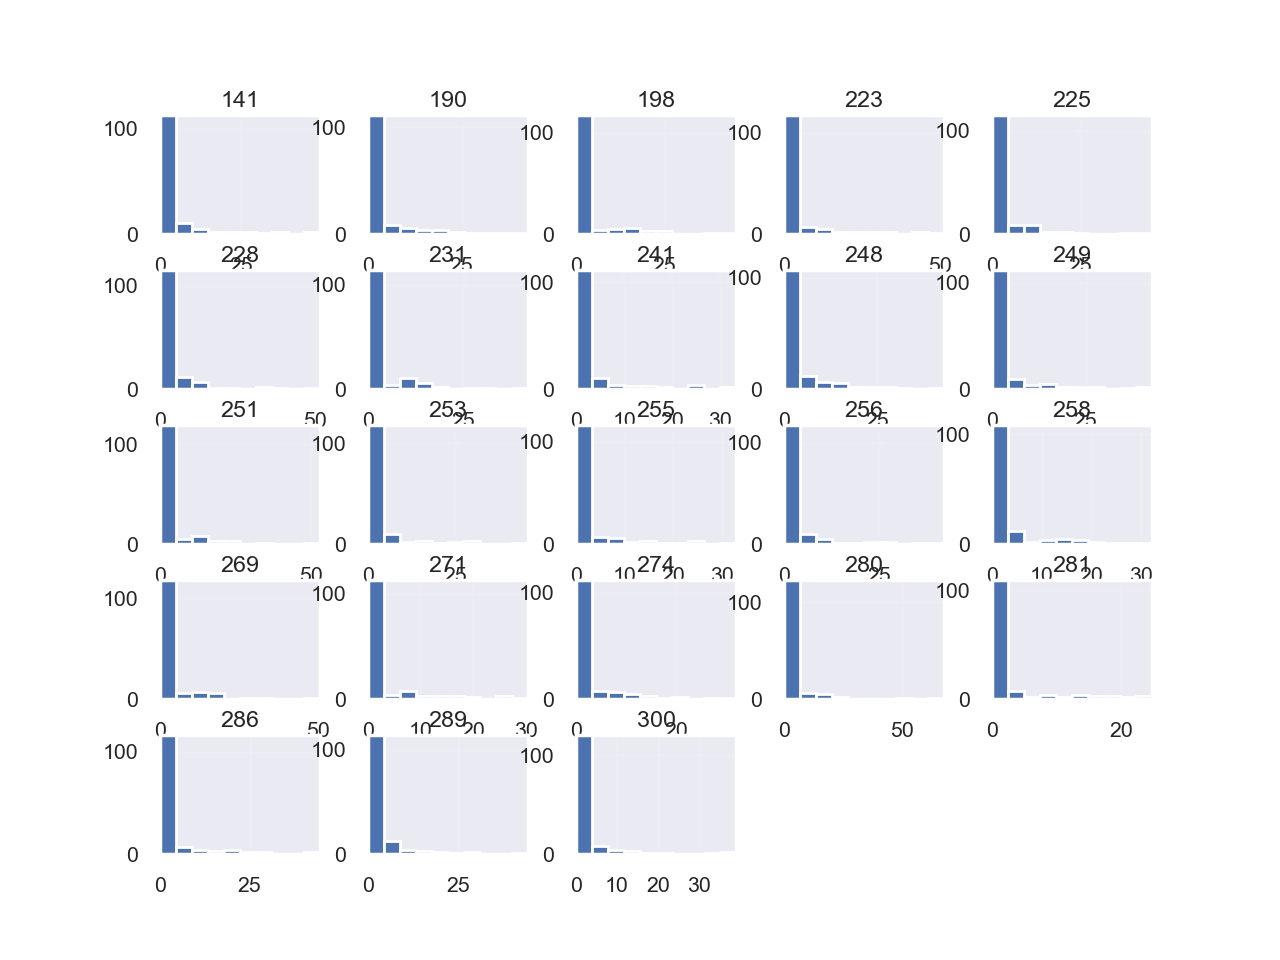

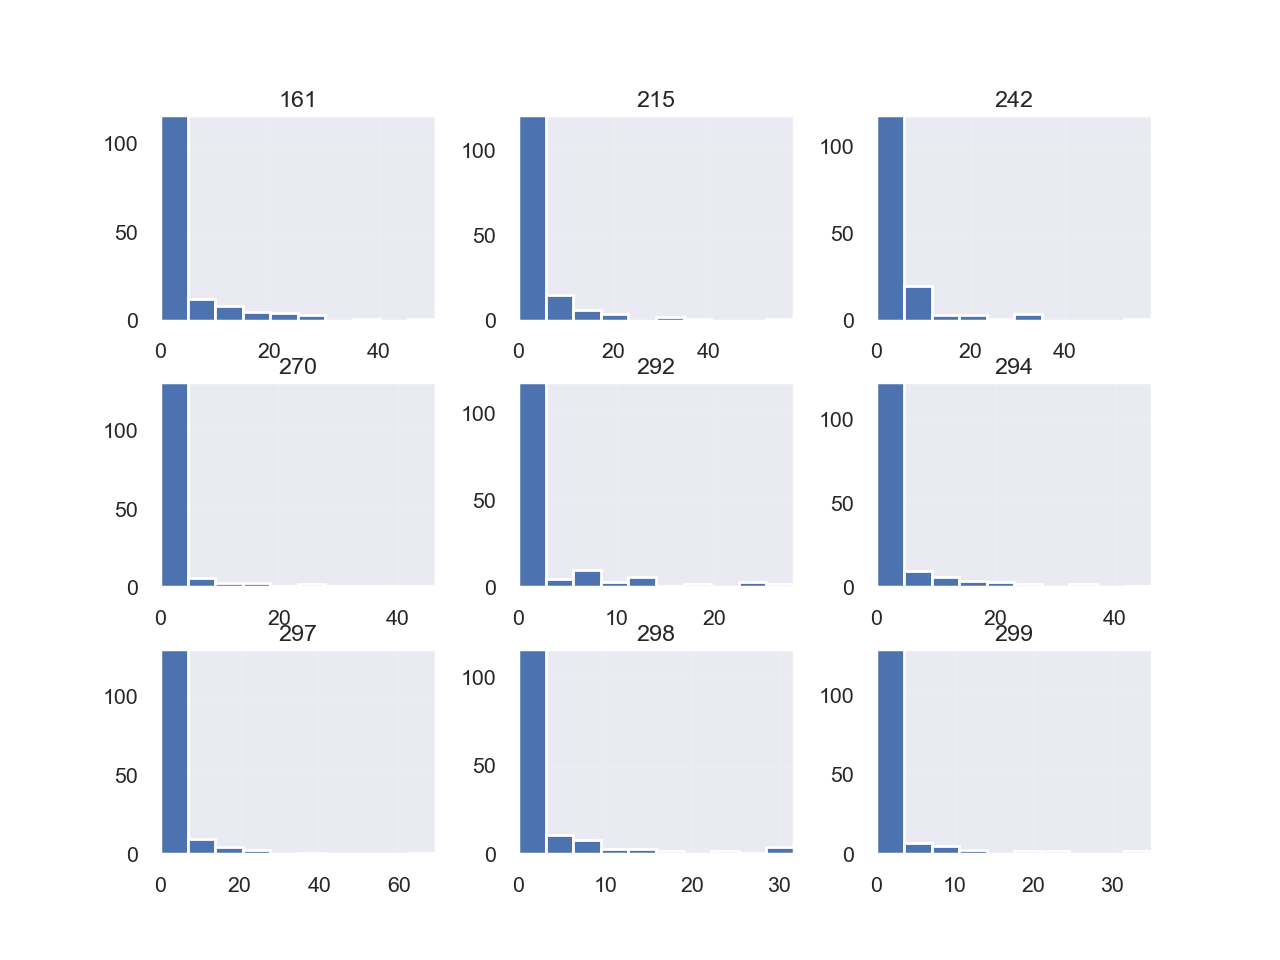

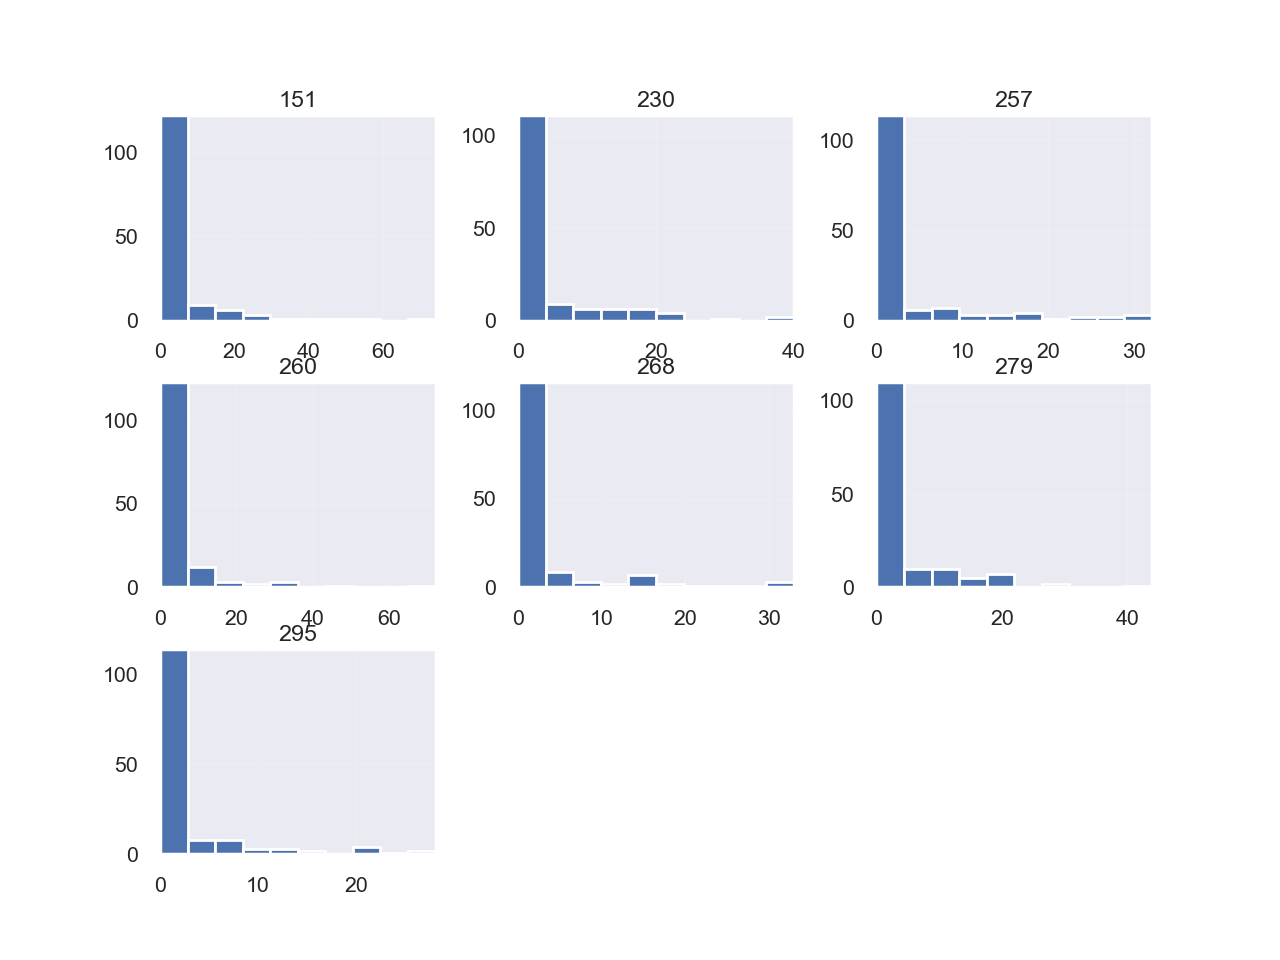

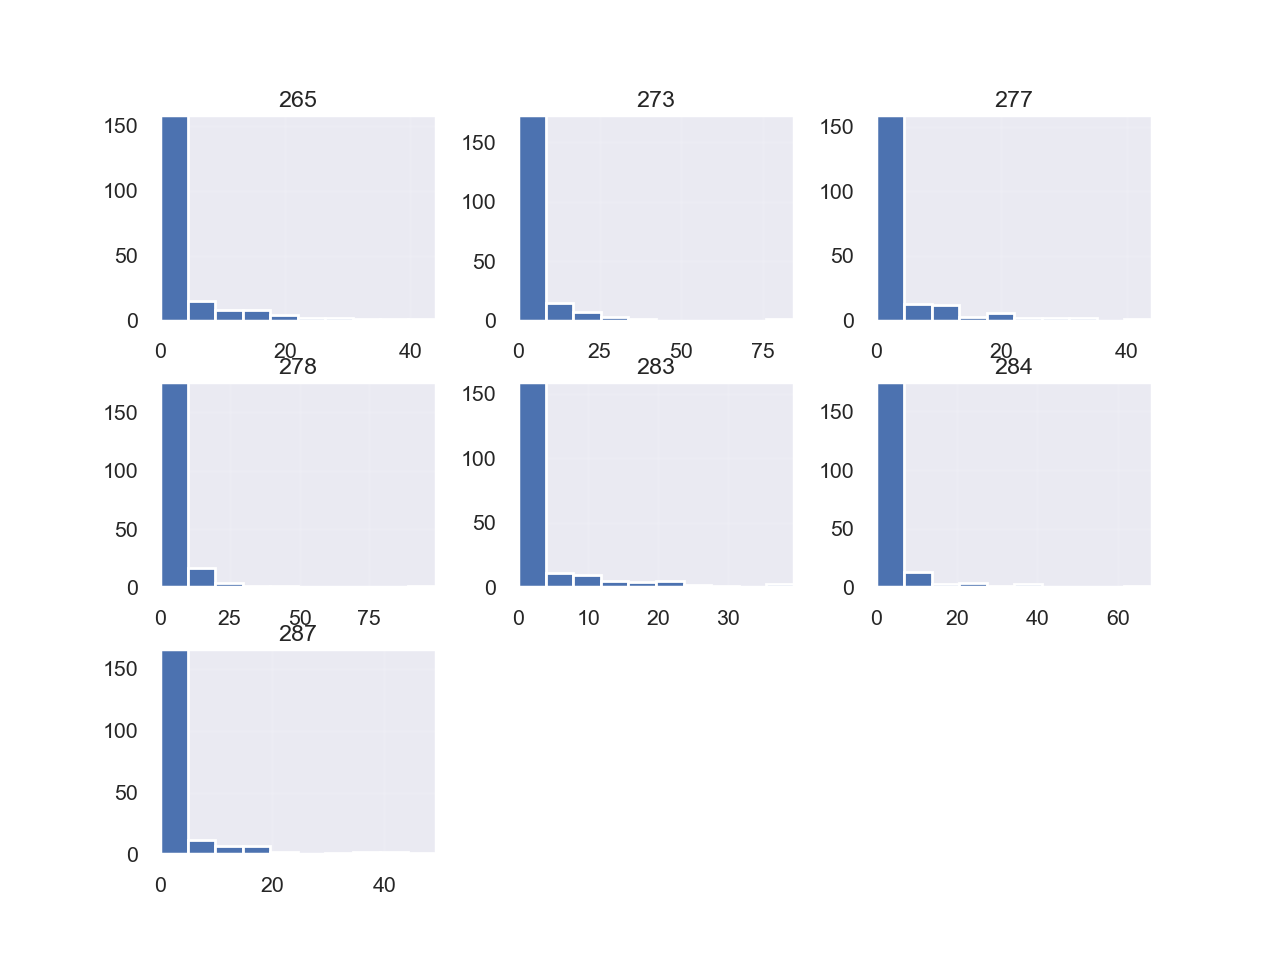

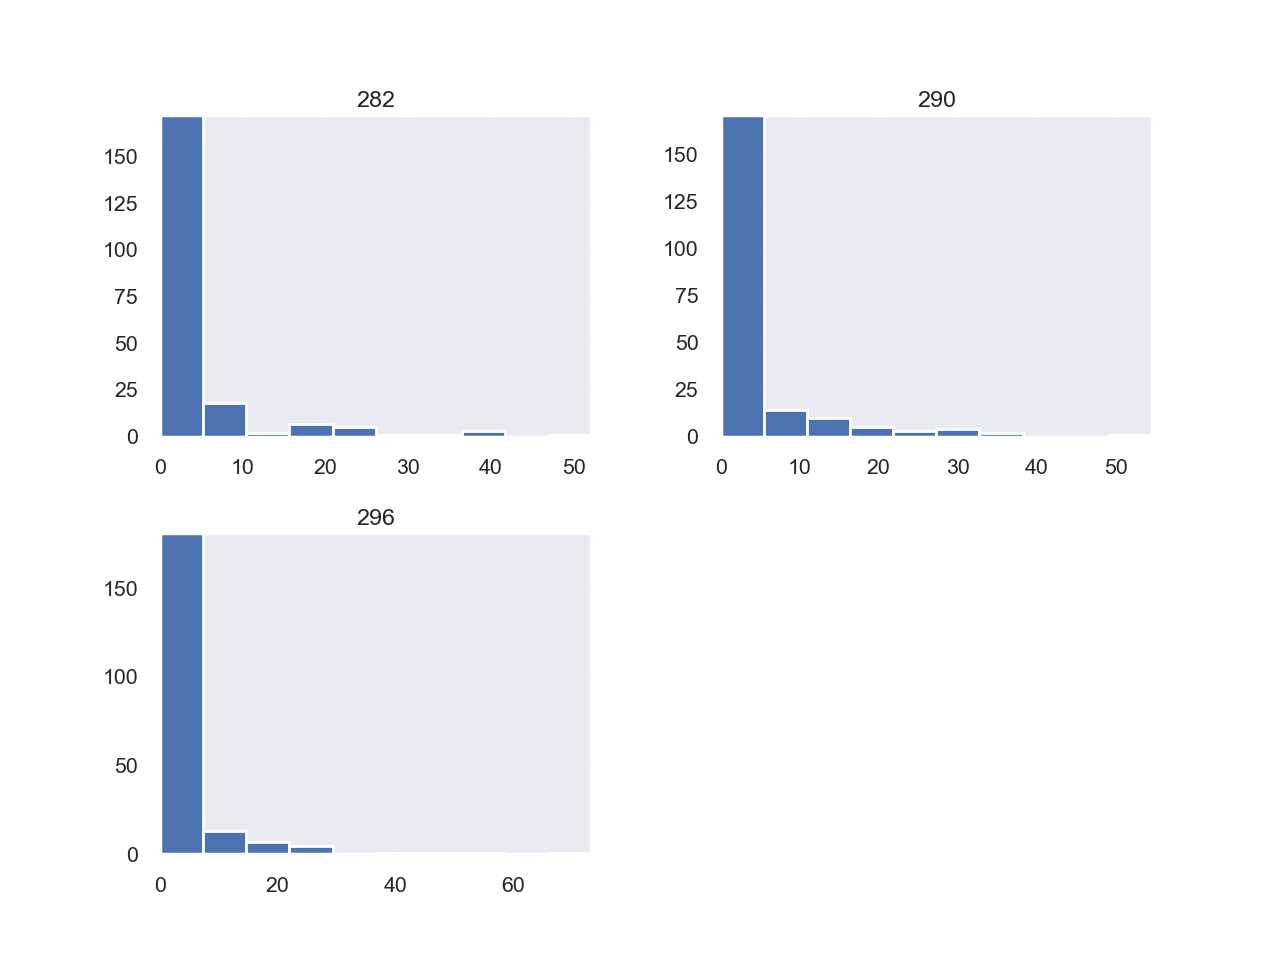

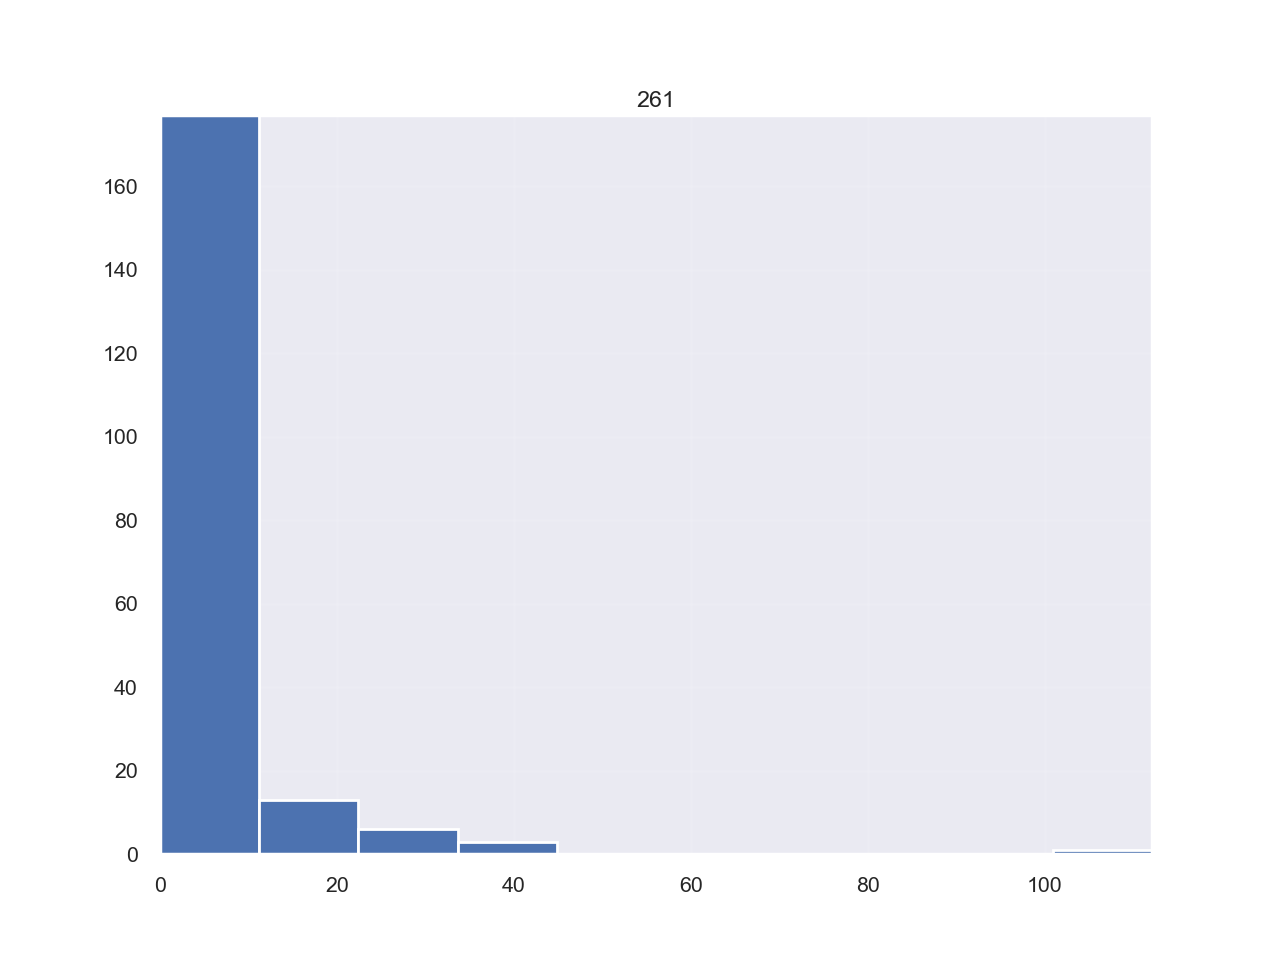

In [41]:
# try to put it in a for loop?
sns.set(font_scale=0.7)

for i in range(len(df2)):
    #print(i)
    # use this to select first row, first column (zero index)    
    # and # perform look up of dataframe for these columns; select those columns from temp 
    temp[df2[0].iloc[i]]

    # plot distribution of these two columns together
    df = temp[df2[0].iloc[i]]
    df.dropna().hist()

# this is just showing us the amounts. Not telling us anything about when it fell 

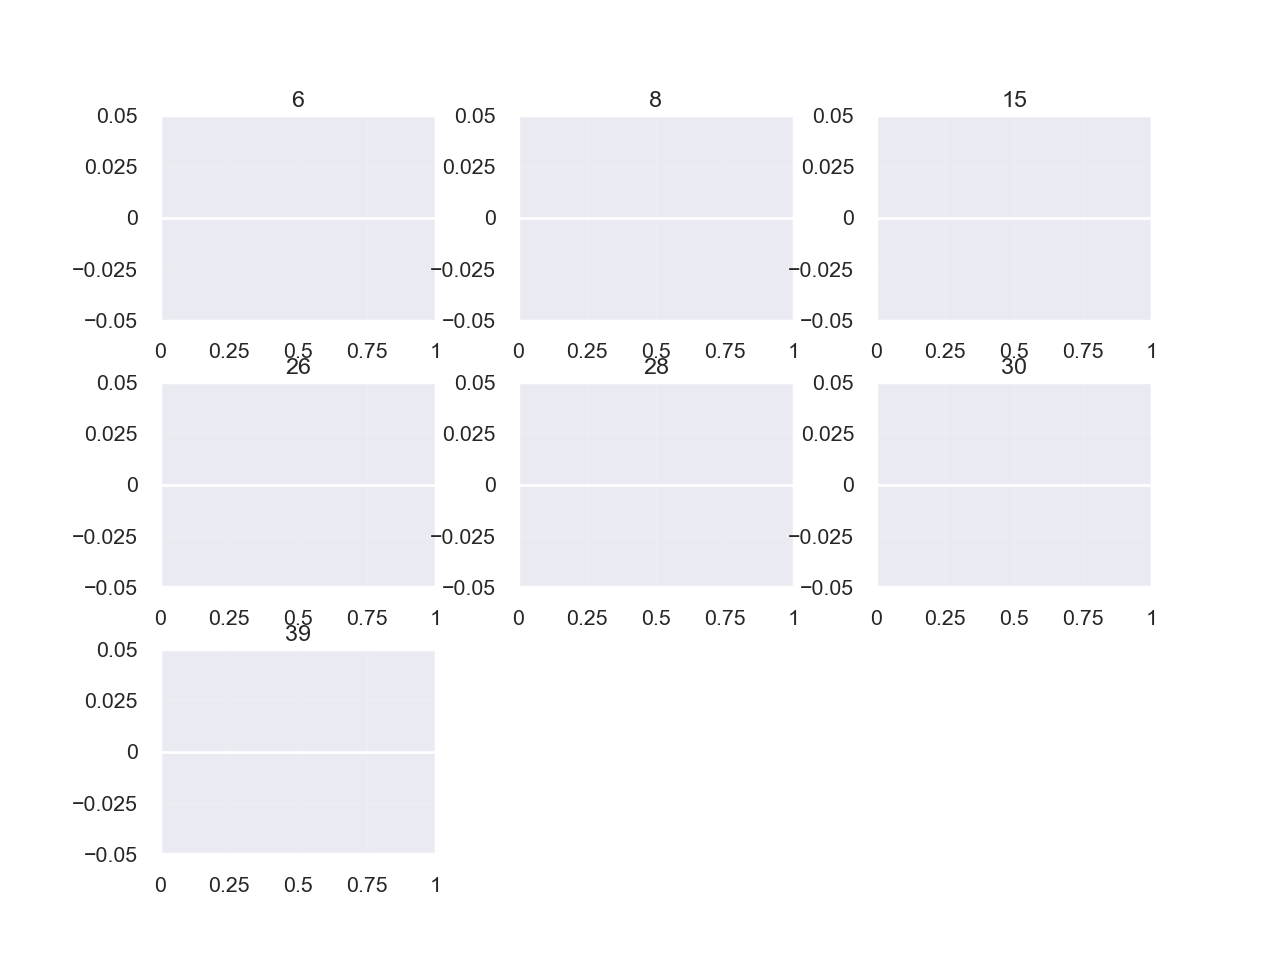

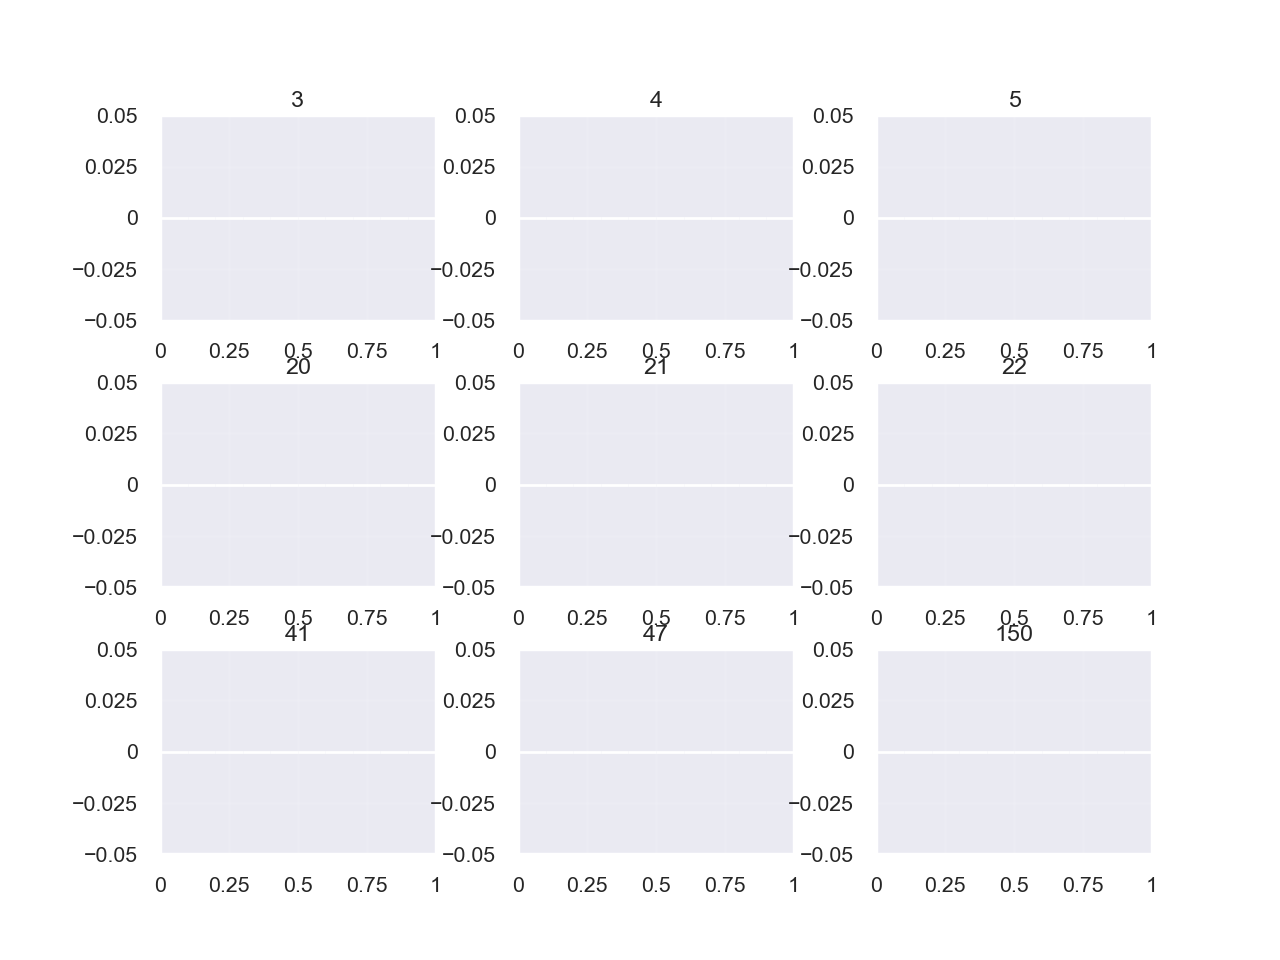

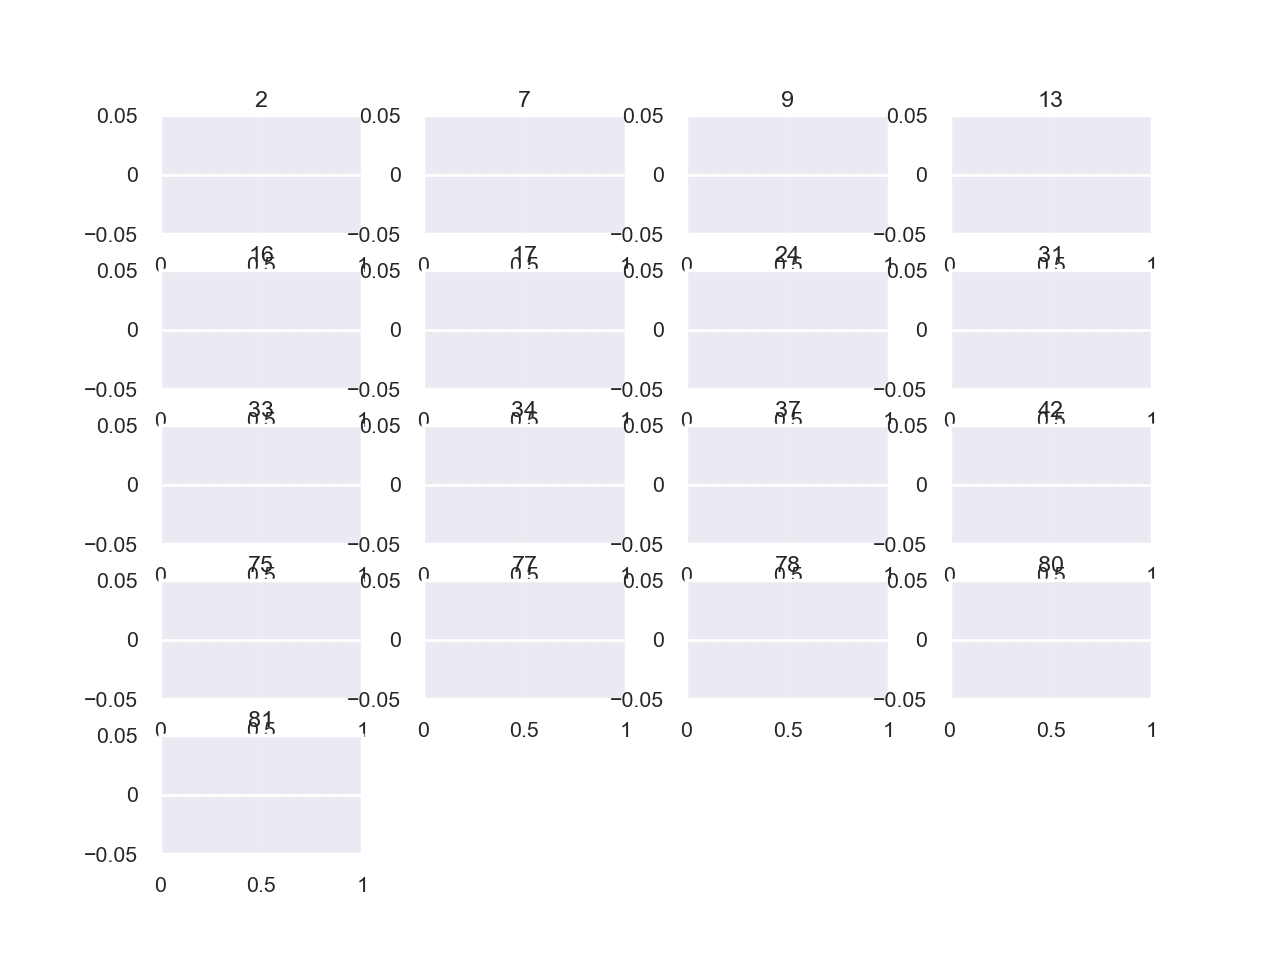

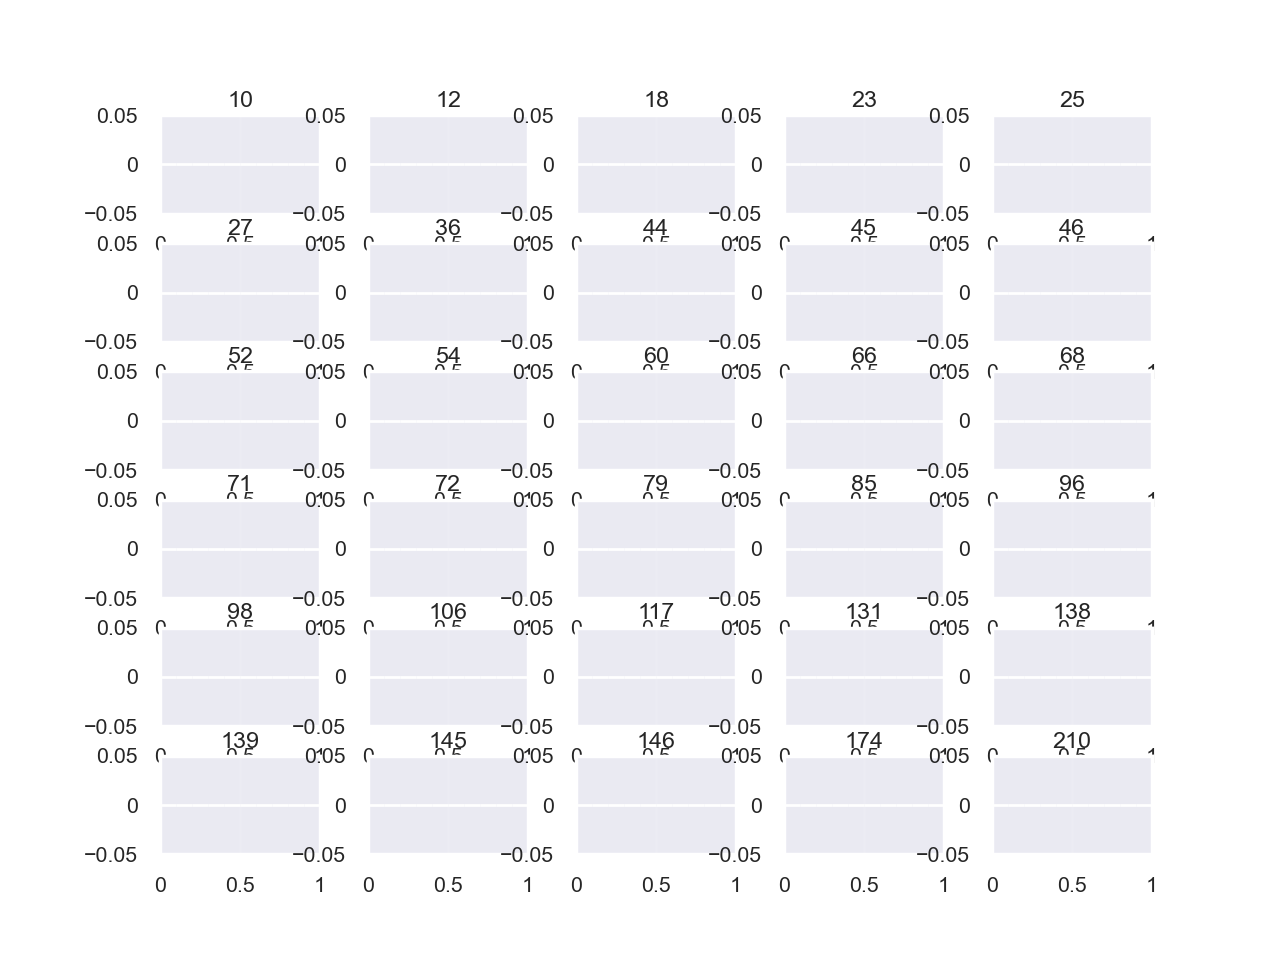

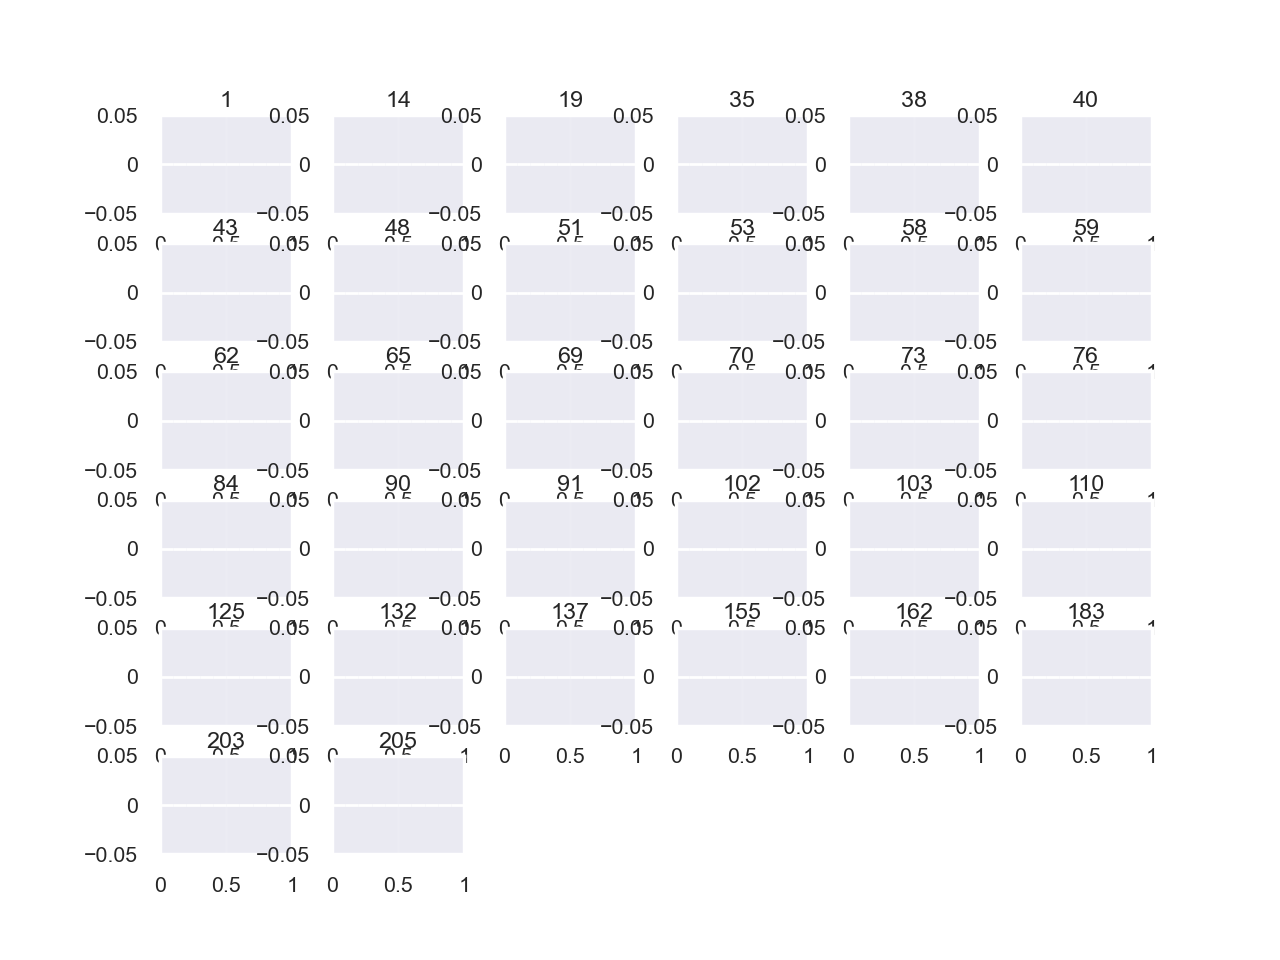

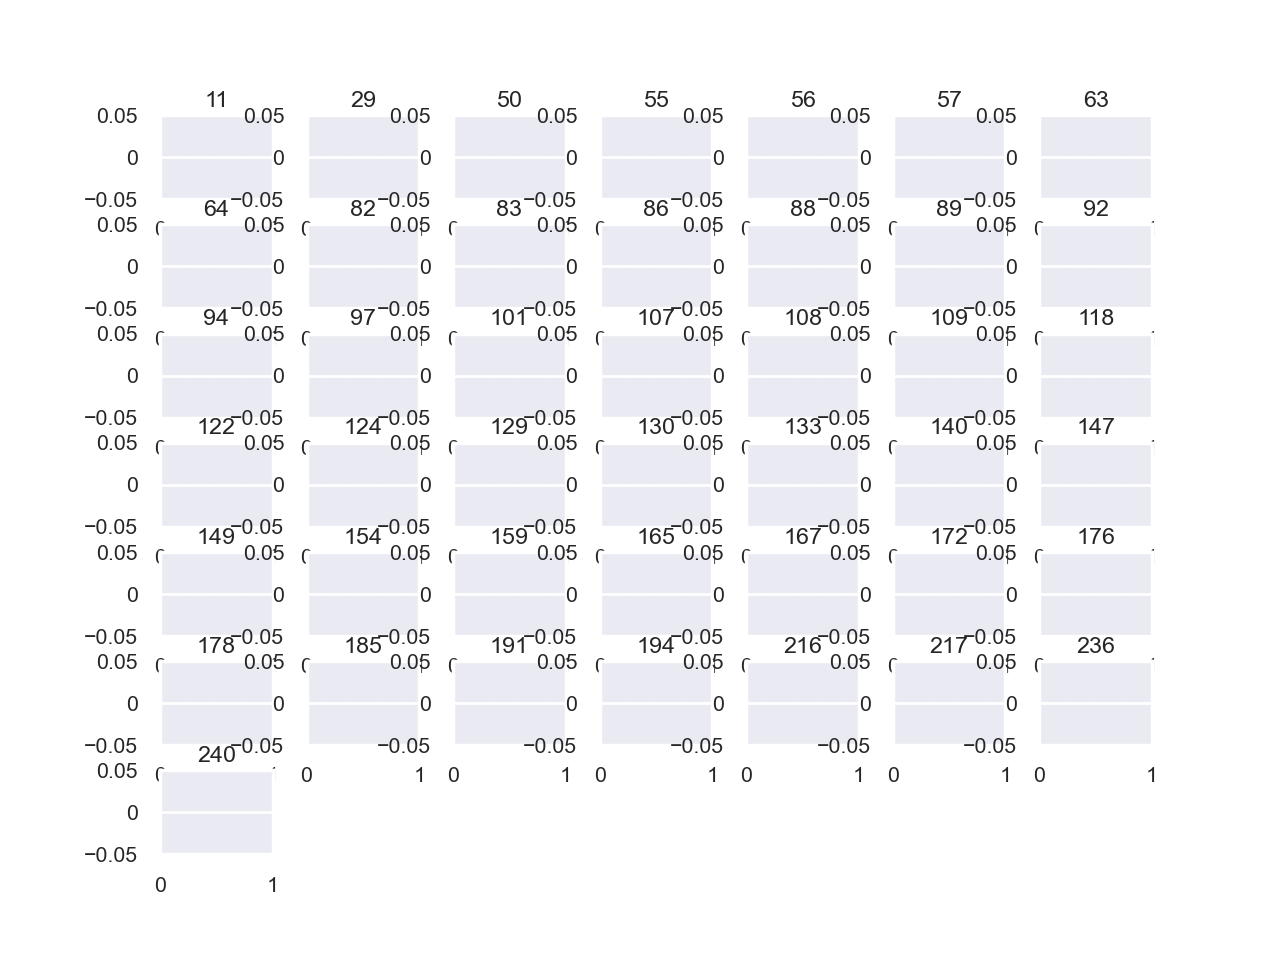

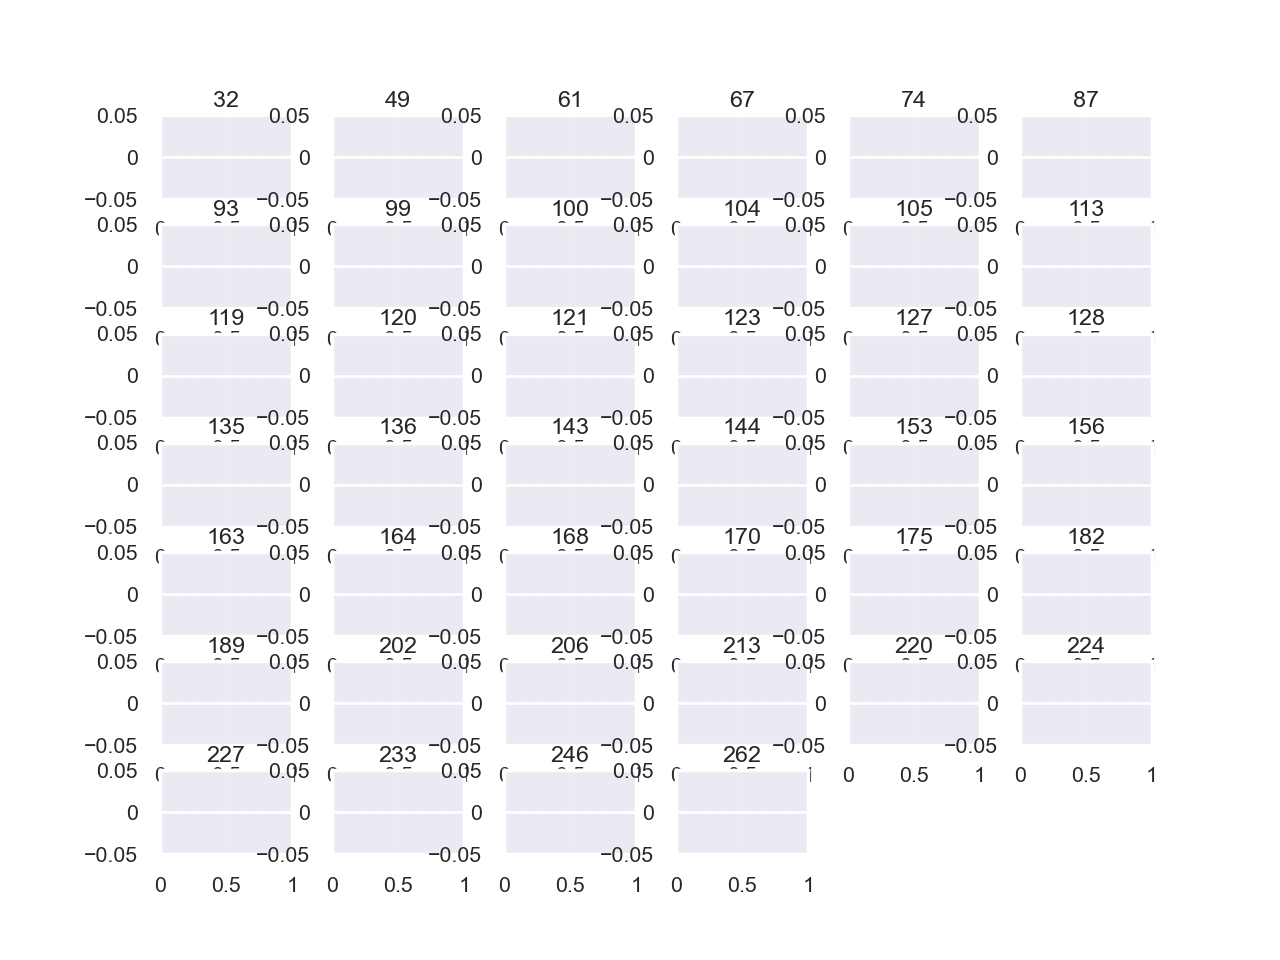

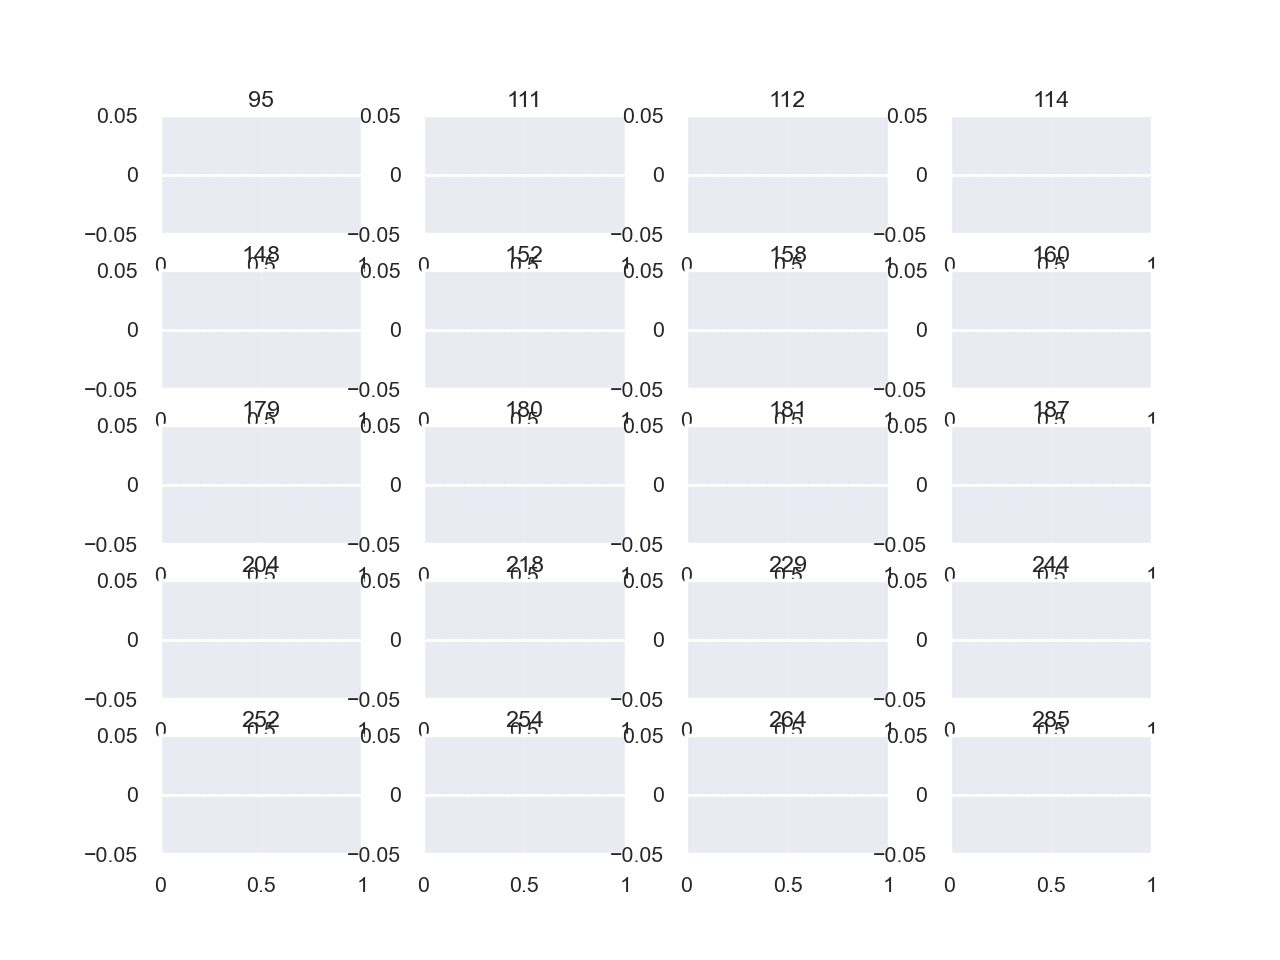

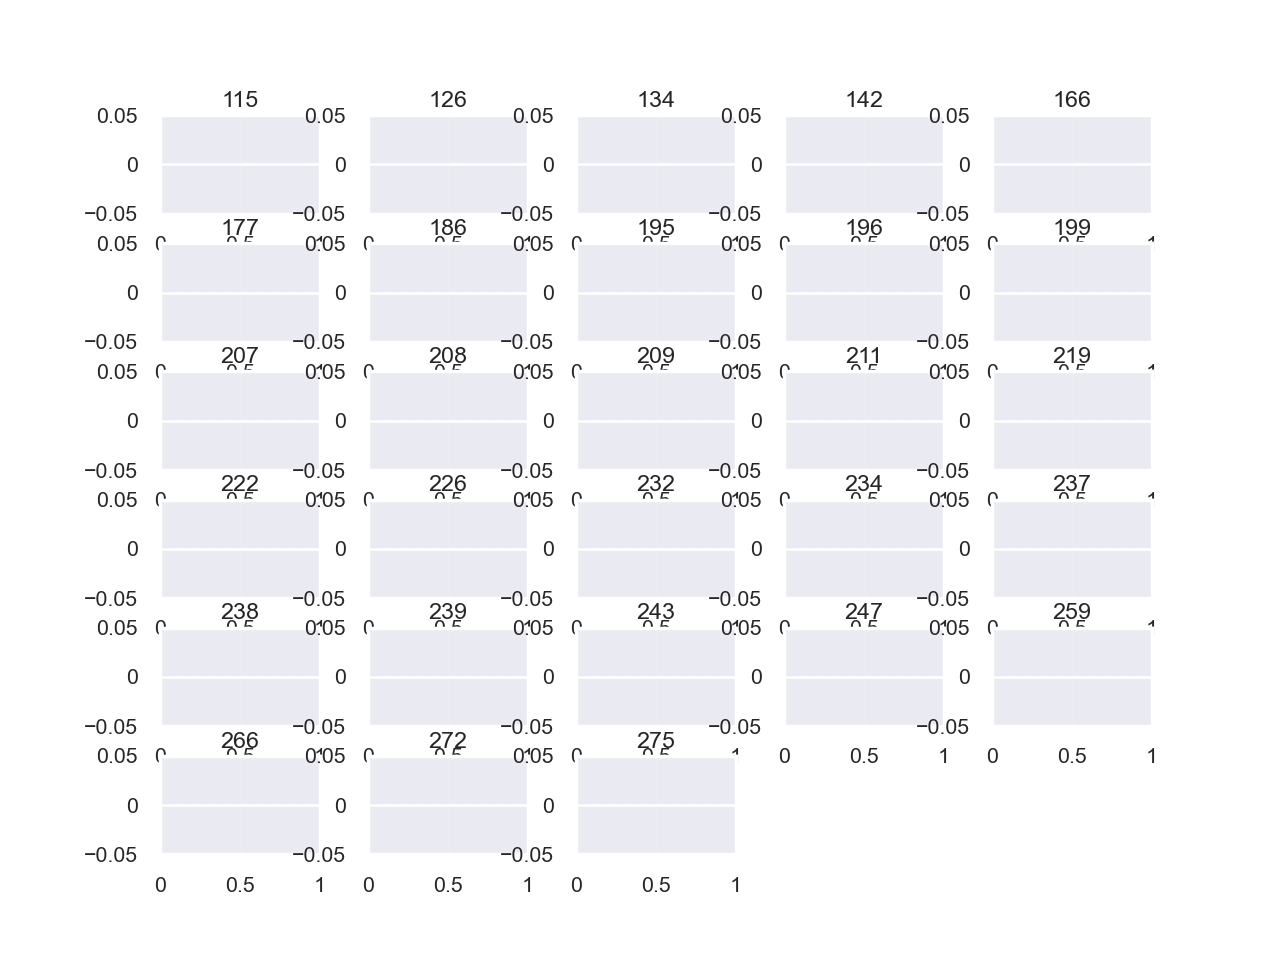

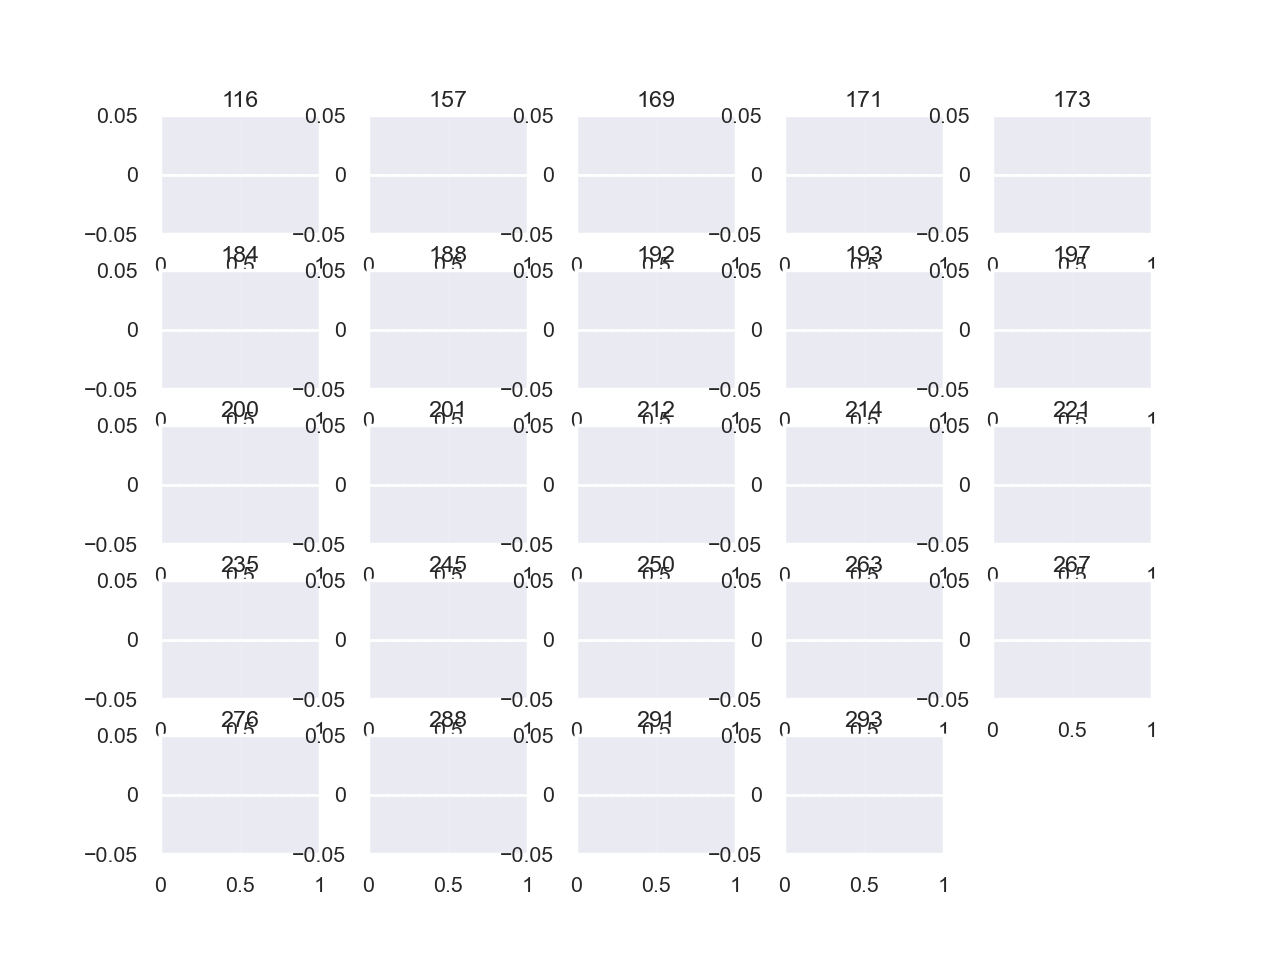

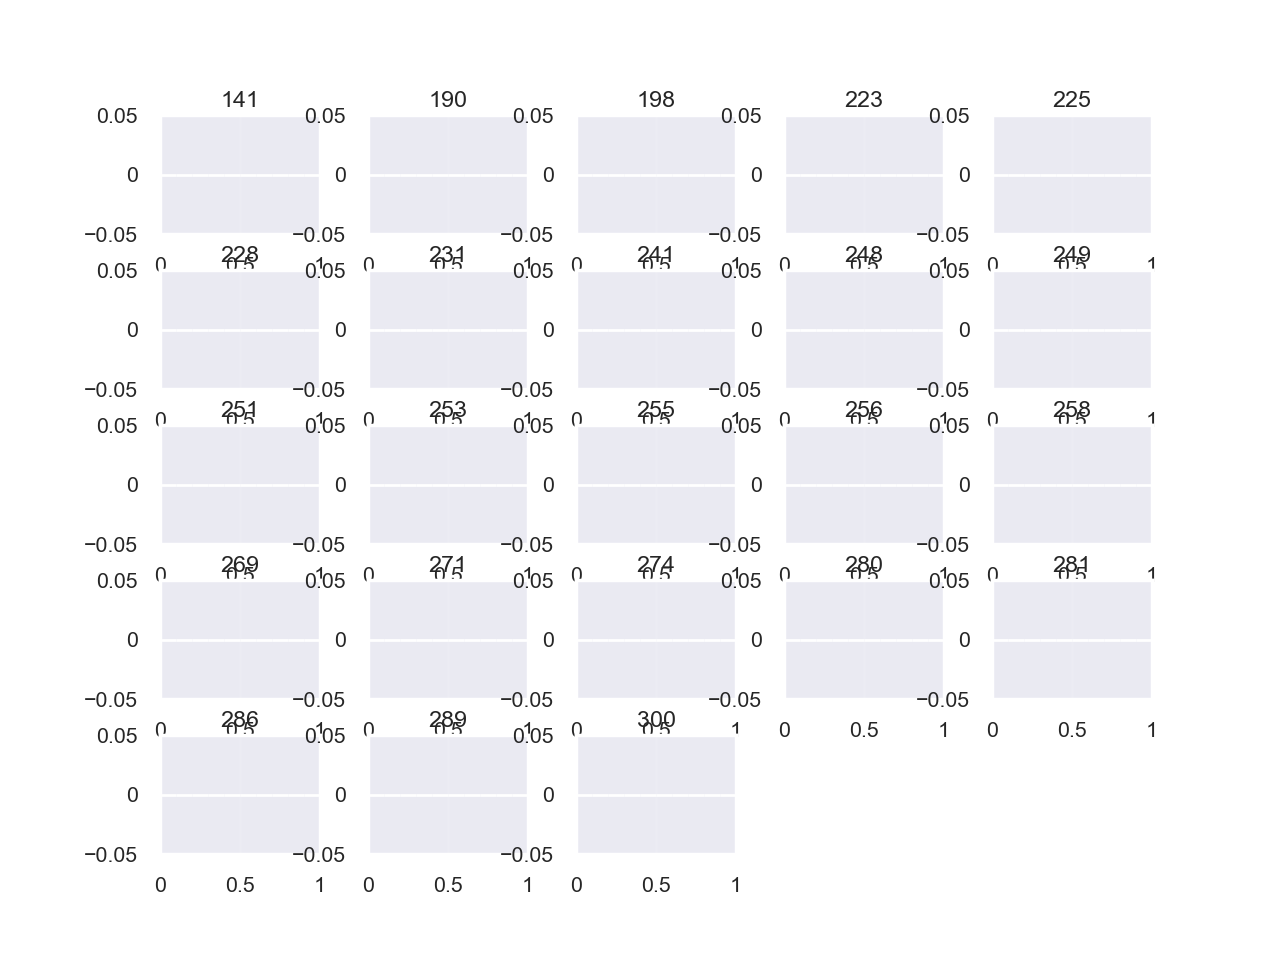

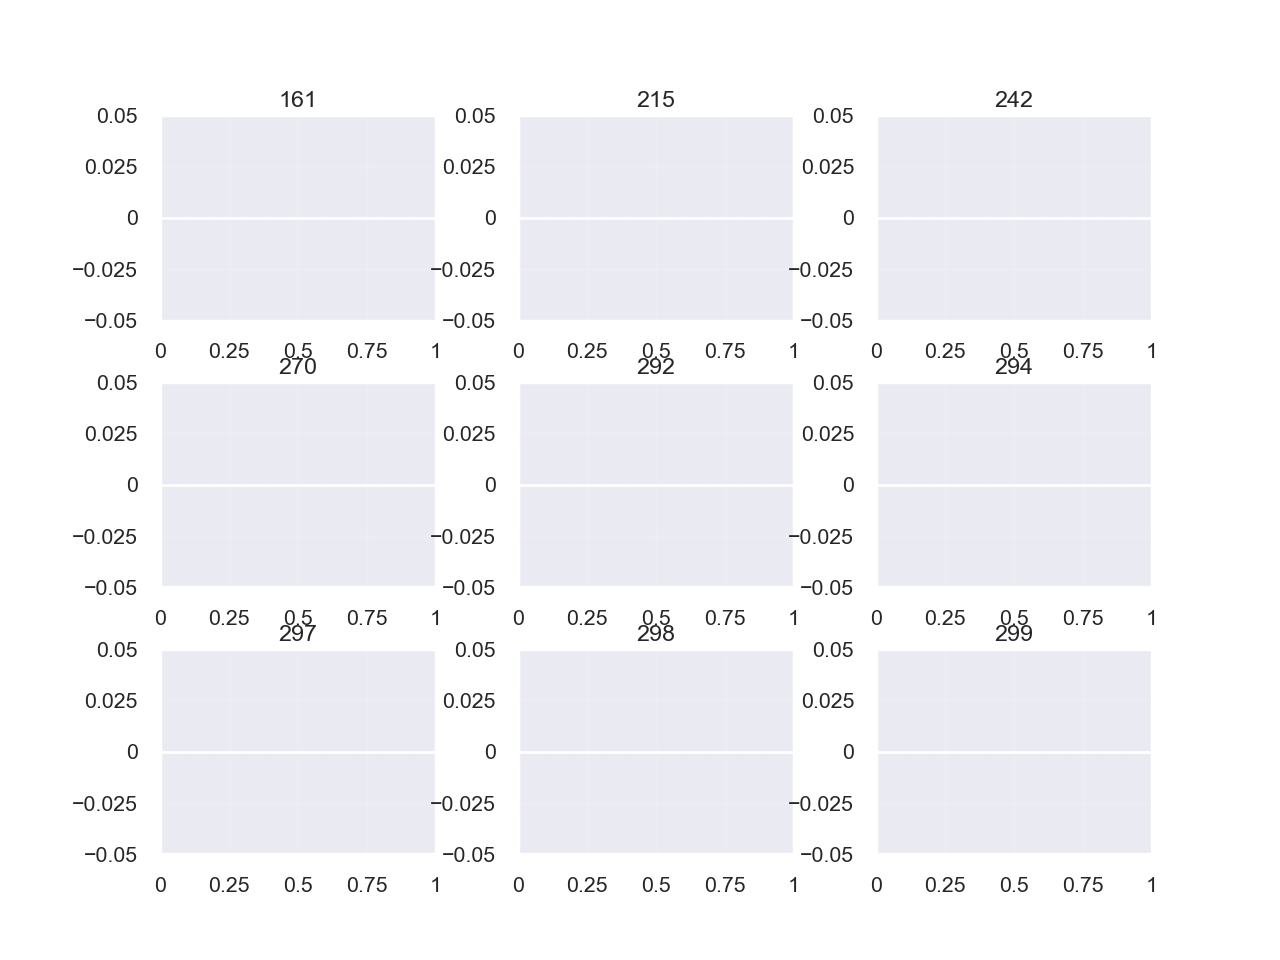

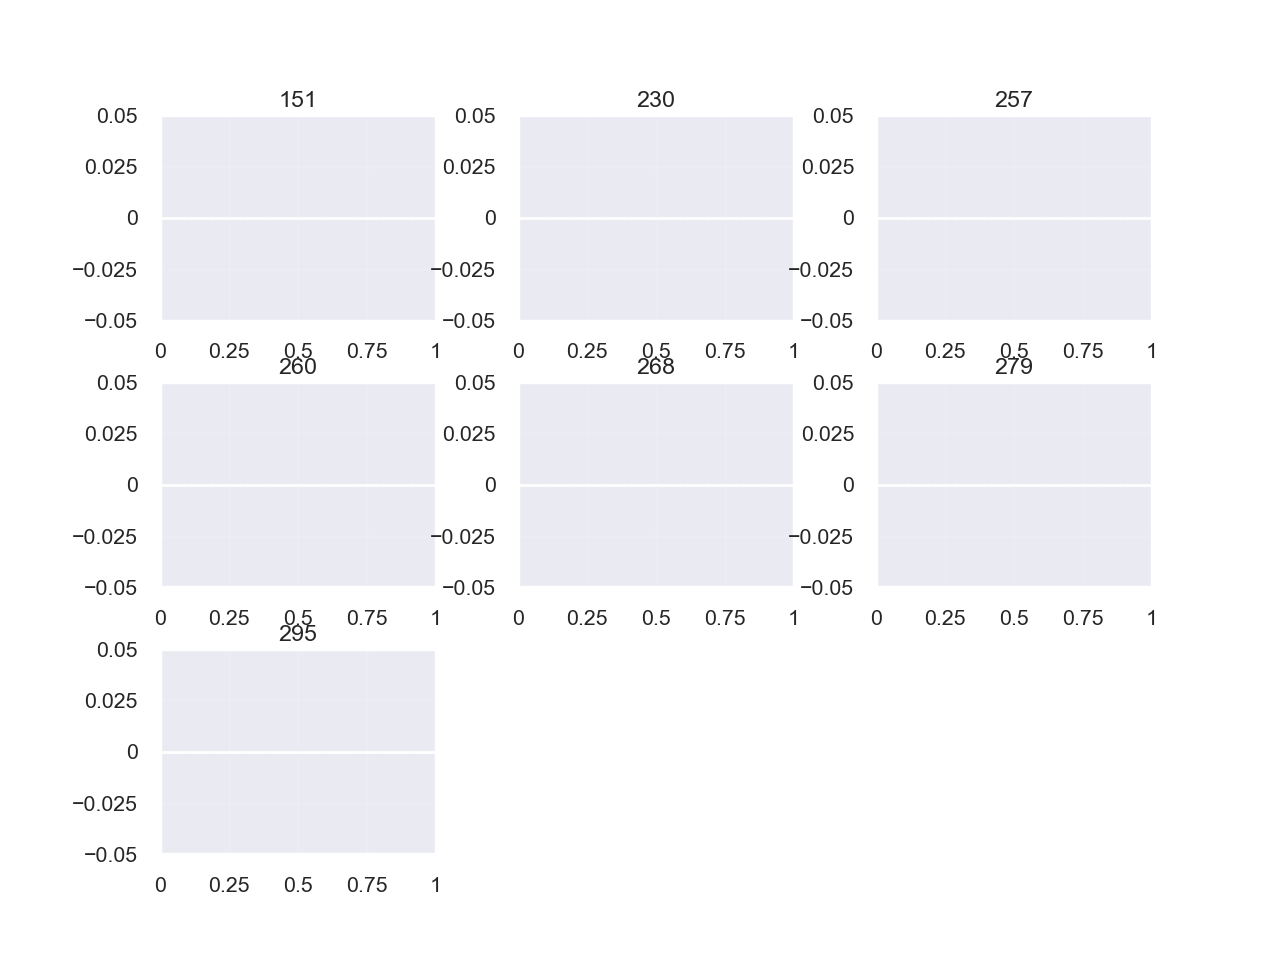

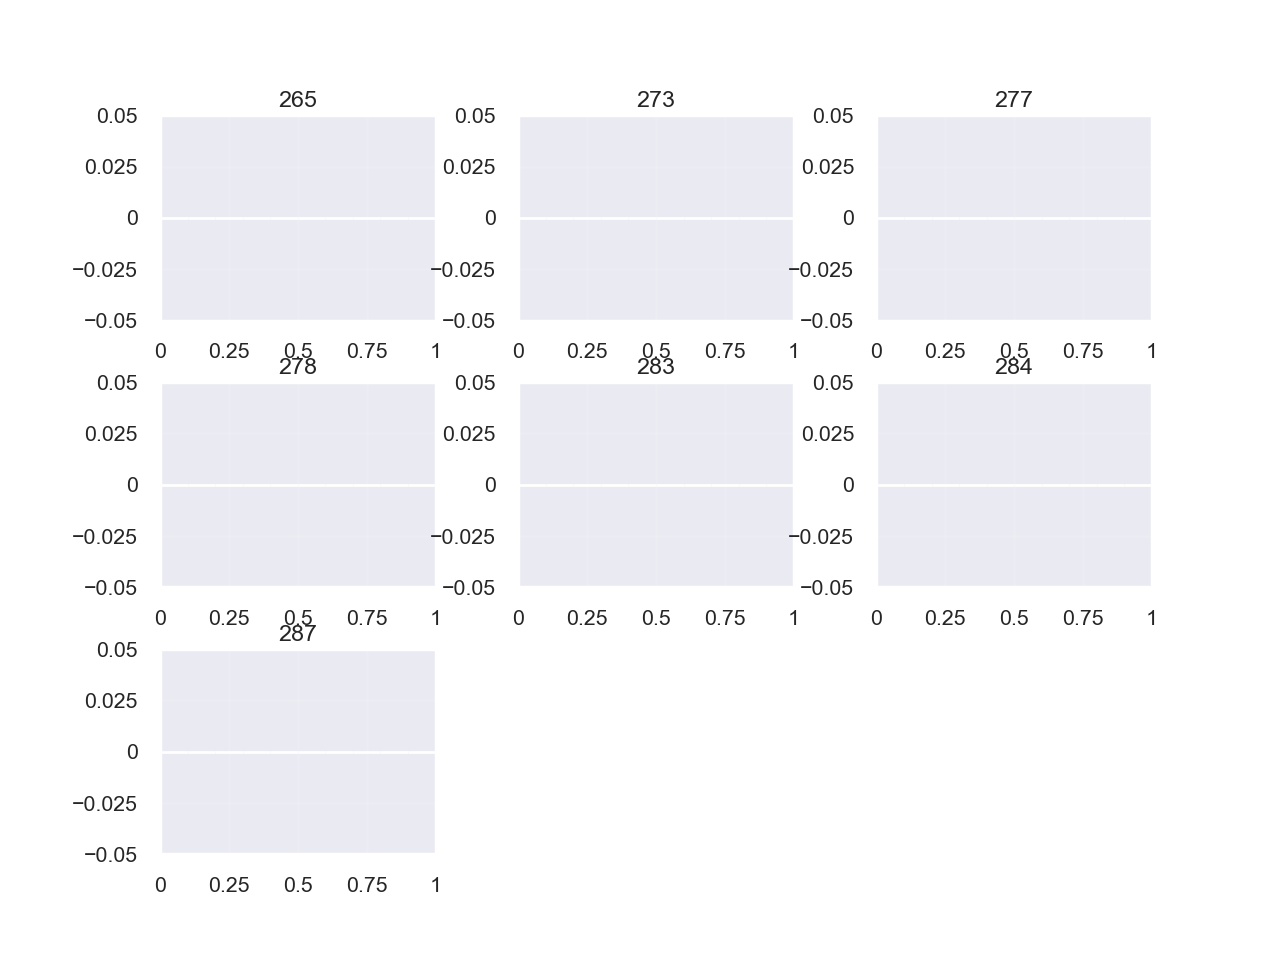

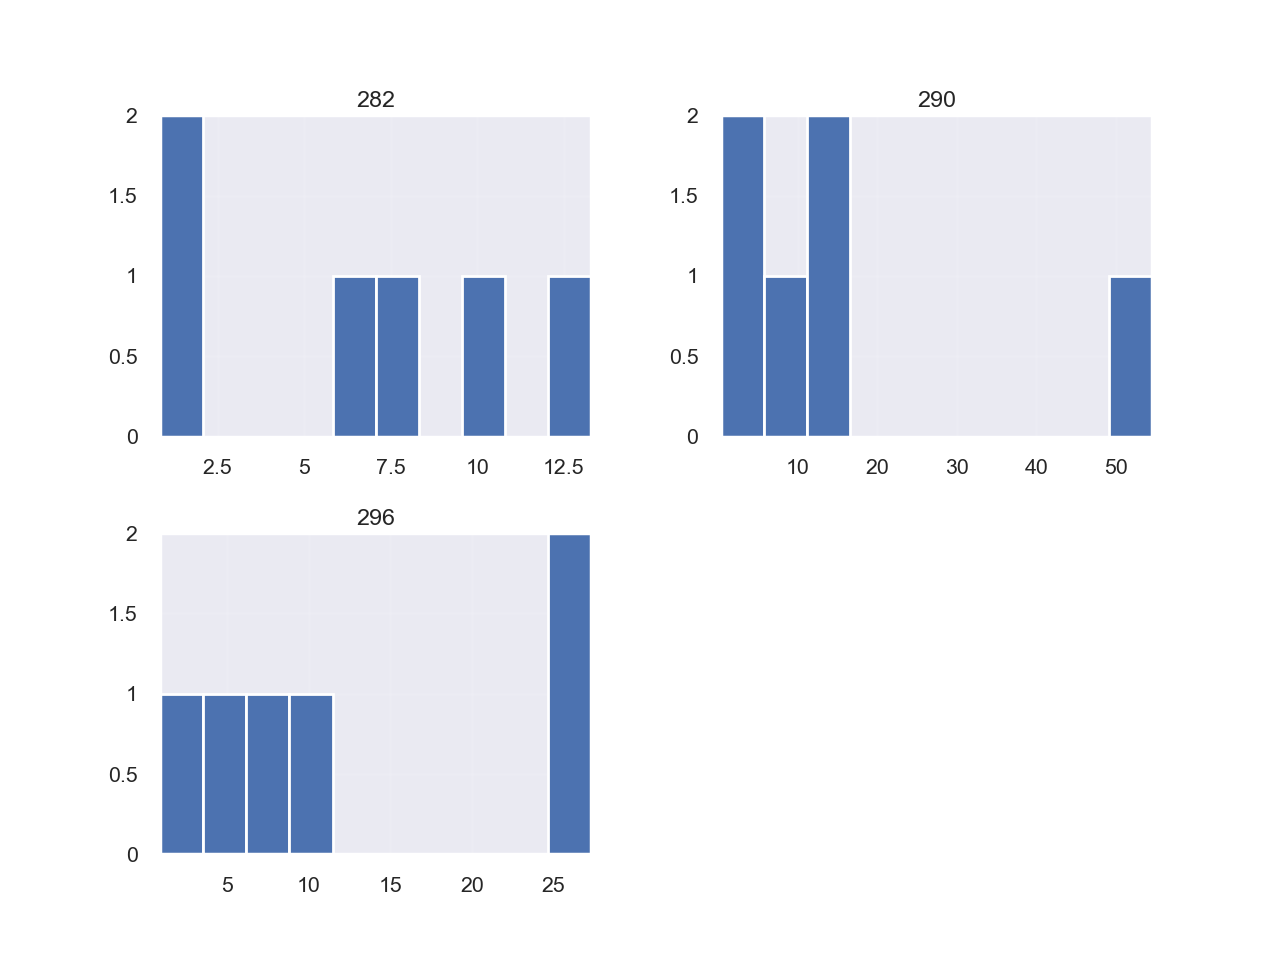

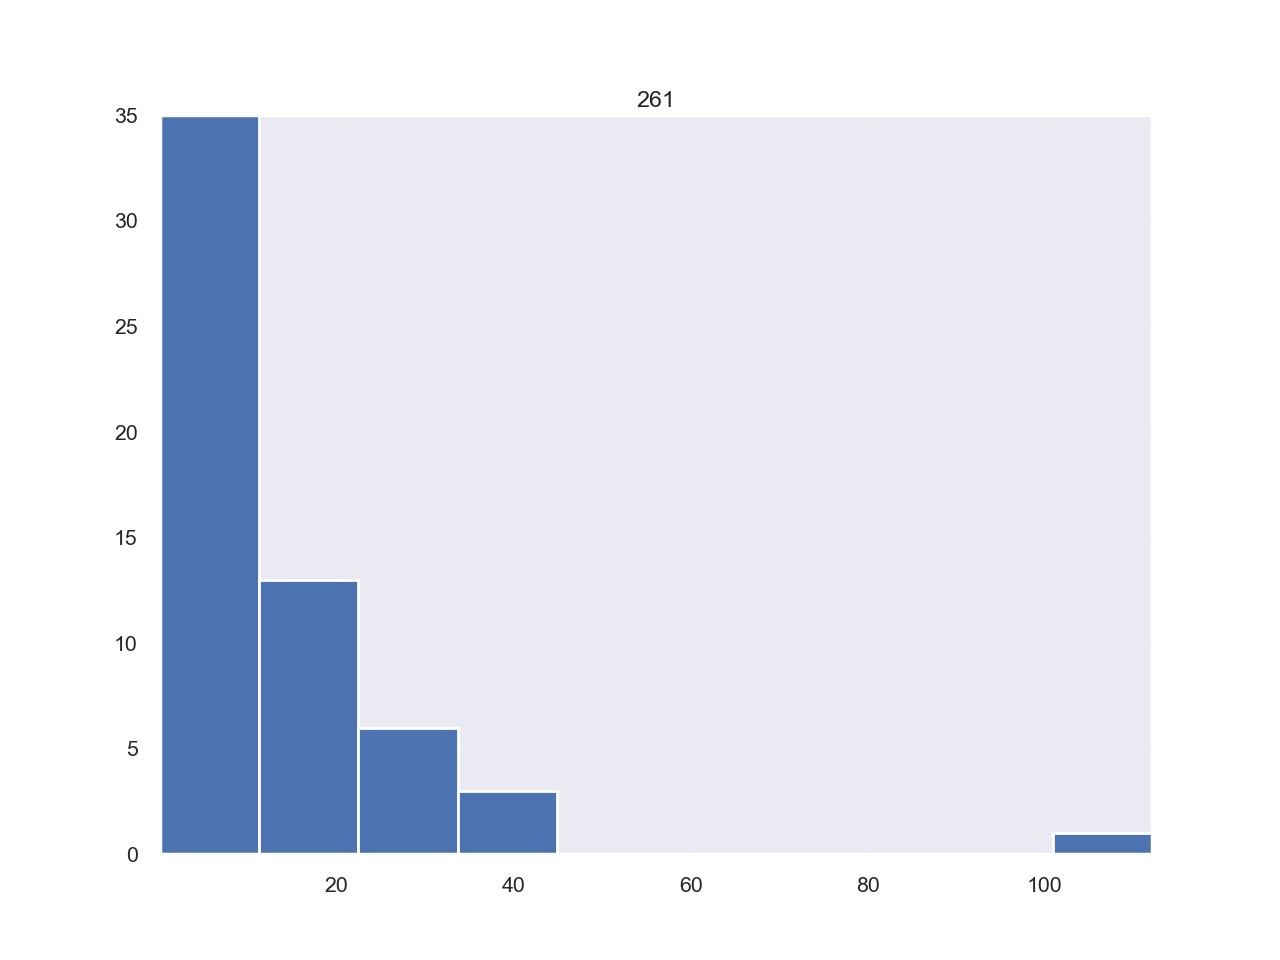

In [42]:
# what about if we remove zeroes from the dataset
# replace 0s with NaNs because don't want to plot those
_temp = temp.replace(0,np.nan)

for i in range(len(df2)):
    #print(i)
    # use this to select first row, first column (zero index)    
    # and # perform look up of dataframe for these columns; select those columns from temp 
    _temp[df2[0].iloc[i]]

    # plot distribution of these two columns together
    df = _temp[df2[0].iloc[i]]
    df.dropna().hist()
    
# this didnt exactly work


In [43]:
#plot as bar plot?
# this did not work
for i in range(len(df2)):
    #print(i)
    # use this to select first row, first column (zero index)    
    # and # perform look up of dataframe for these columns; select those columns from temp 
    temp[df2[0].iloc[i]]

    # plot distribution of these two columns together
    df = temp[df2[0].iloc[i]]
    #df.dropna().plot(kind='bar') #this looks really bad



In [44]:
# maybe there is a better way to plot this like using the time series in a single distribution or distributions plotted on top of each other
# but then again maybe rainfall can't really be plotted that way because it is not continious?

### Additional Plots

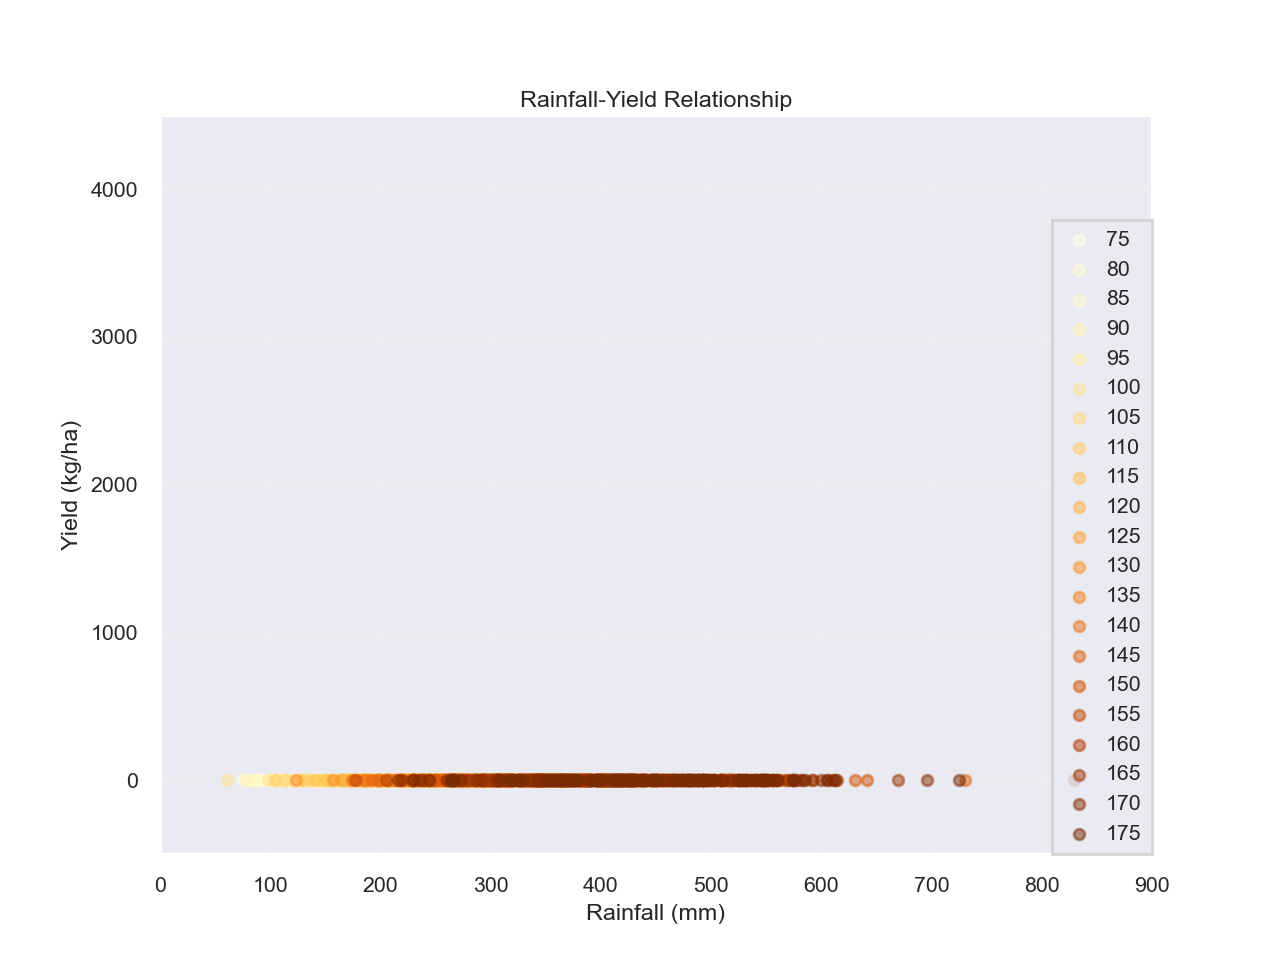

In [45]:
# Color scatter by cultivar

# Set up independent and dependent vars
x, y = result['RF'], result['Yield']

# Set the color map to match the number of species
z = range(1,len(varieties))
hot = plt.get_cmap('ylorbr')
cNorm  = colors.Normalize(vmin=0, vmax=len(varieties))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=hot)

# Plot each cultivar
for i in range(len(varieties)):
    indx = result['Cultivar'] == varieties[i]
    plt.scatter(x[indx], y[indx], s=15, alpha=0.5,
                color=scalarMap.to_rgba(i), label=varieties[i])

plt.ylim(-500,4500)
plt.xlim(0,900)
plt.title('Rainfall-Yield Relationship')
plt.ylabel('Yield (kg/ha)') # Could change to yield normalized by max. yield
plt.xlabel('Rainfall (mm)')
plt.legend(loc='lower right')

Text(0.5, 1.0, 'Relationship between rainfall vs. yield of early, medium, late varieties')

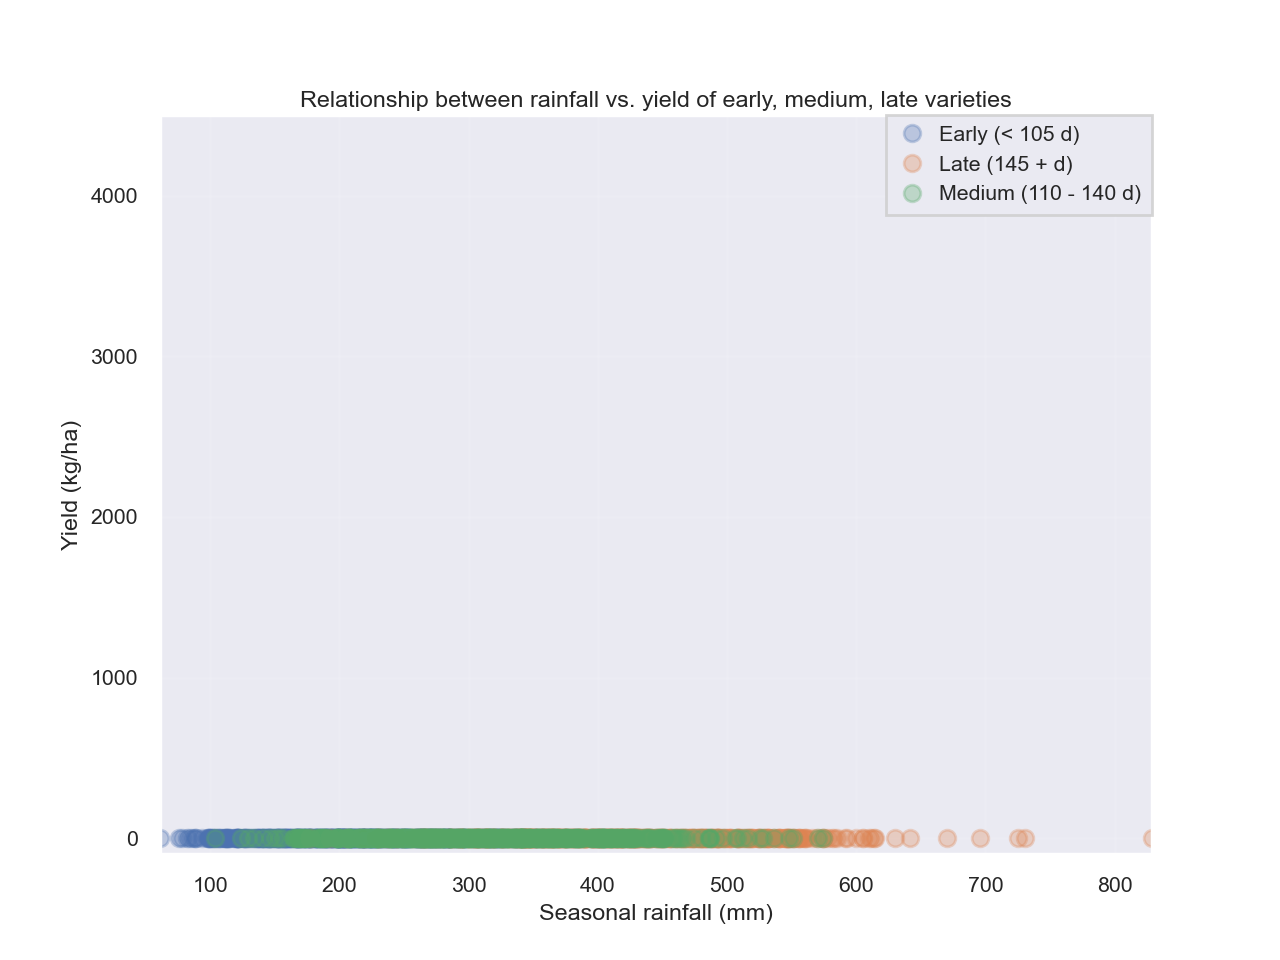

In [46]:
# Make another plot but based on categories
groups = result.groupby("Category")
for name, group in groups:
    plt.plot(group["RF"], group["Yield"], marker="o", linestyle="", label=name, alpha=0.3)
plt.legend()

plt.xlabel('Seasonal rainfall (mm)')
plt.ylabel('Yield (kg/ha)')
plt.ylim(-100,4500)
plt.title('Relationship between rainfall vs. yield of early, medium, late varieties')

(0.0, 4500.0)

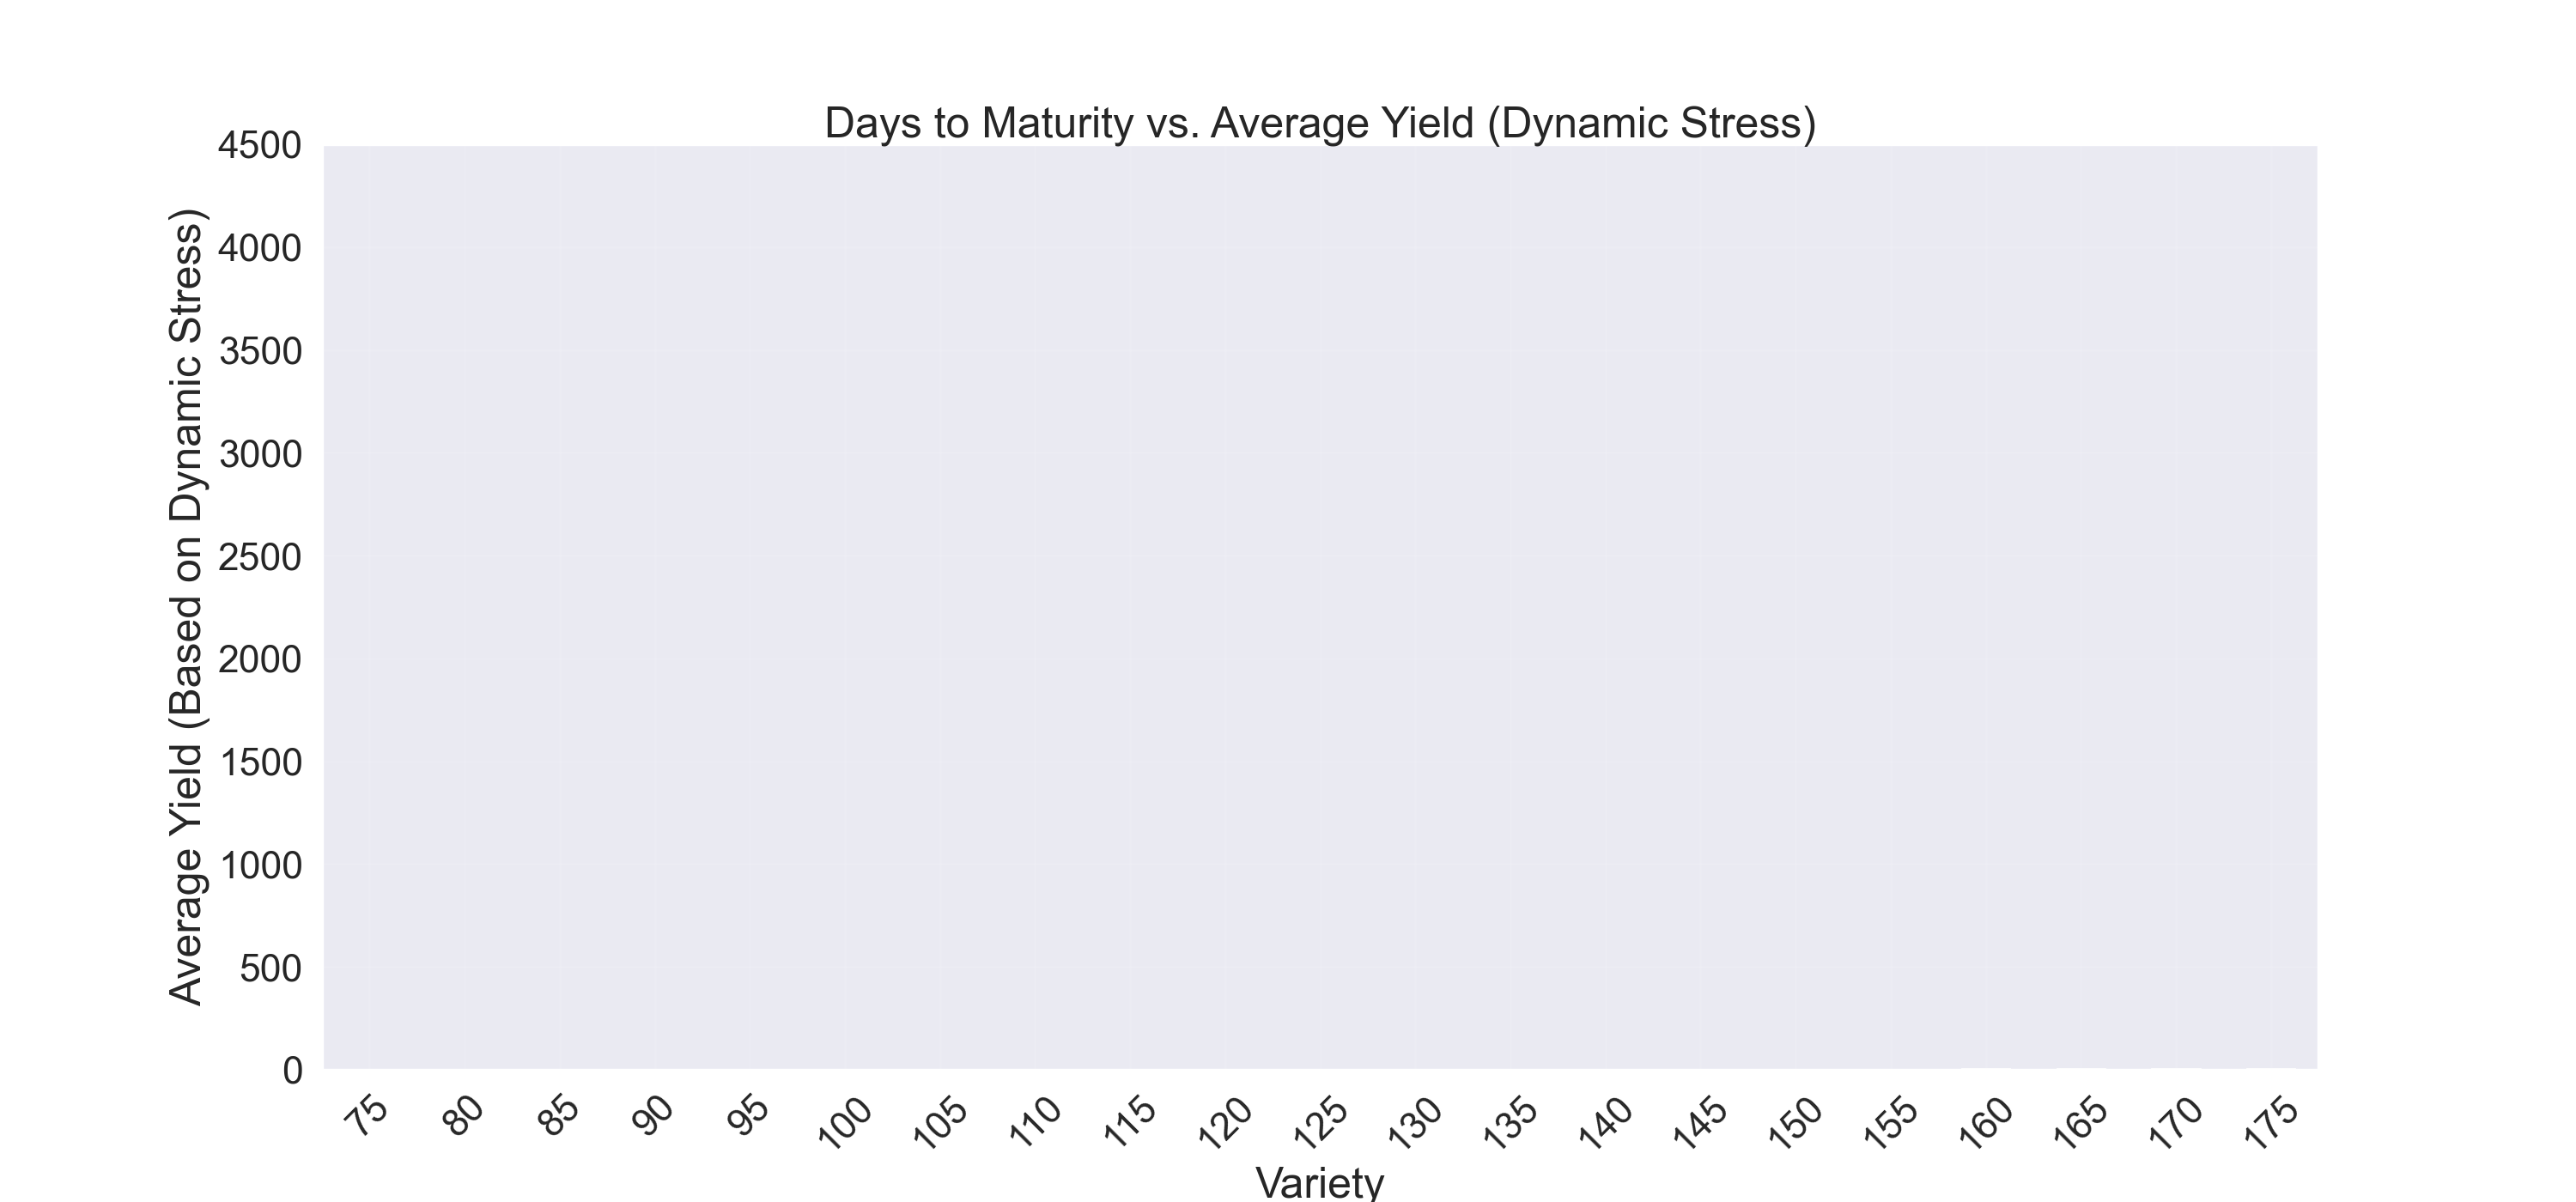

In [47]:
# Average yield per DTM

std = result.groupby('Cultivar')['Yield'].std()
result.groupby('Cultivar')['Yield'].mean().plot(figsize=(15,7),color='orange',legend=False,kind="bar",rot=45,fontsize=16,yerr=std) # color="blue",

plt.ylabel('Average Yield (Based on Dynamic Stress)', fontsize=18)
plt.xlabel('Variety', fontsize=18)
plt.title('Days to Maturity vs. Average Yield (Dynamic Stress)', fontsize=18)
plt.ylim((0,4500))

In [48]:
# groupby by RF_bins to get average

avg = result.groupby(['Category','RF_bins'])['Yield'].mean()
sd = result.groupby(['Category','RF_bins'])['Yield'].std()

avg.plot(figsize=(15,7),color='orange',legend=False,kind="bar",rot=45,fontsize=16,yerr=sd) # color="blue",

plt.ylabel('Average Yield (Based on Dynamic Stress)', fontsize=18)
plt.xlabel('Variety', fontsize=18)
plt.title('Days to Maturity vs. Average Yield (Dynamic Stress)', fontsize=18)
plt.ylim((0,4500))


KeyError: 'RF_bins'

In [ ]:
fig_dims = (15, 7)
fig, ax = plt.subplots(figsize=fig_dims)

ax = sns.boxplot(x="RF_bins_orig", y="Yield", hue="Category", data=result, ax=ax)
plt.ylabel('Average Yield kg/ha', fontsize=18)
plt.xlabel('Seasonal Rainfall Binned in 50 mm Increments', fontsize=18)
plt.title('Days to Maturity vs. Average Yield (Dynamic Stress)', fontsize=18)
plt.ylim((-100,4200))
plt.legend(loc='lower right')
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
#ax = sns.swarmplot(x="RF_bins", y="Yield", hue="Category", data=result, color=".25")

# add median value - couldnt get this to work: https://stackoverflow.com/questions/38649501/labeling-boxplot-in-seaborn-with-median-value
medians = result.groupby(['Category','RF_bins_orig'])['Yield'].mean().median()
vertical_offset = result['Yield'].median() * 0.05 # offset from median for display

In [ ]:
# Previous Joint PDF plots



In [ ]:
# Set up independent and dependent vars
x, y = result['RF'], result['Yield']

y_ = y.values.reshape(3000,1) 
x_ = x.values.reshape(3000,1)


In [ ]:
# Tutorial here: https://python-graph-gallery.com/86-avoid-overlapping-in-scatterplot-with-2d-density/

import scipy.stats as st

# set up data as a matrix
data = result[['RF','Yield']].values
x,y = data.T

# Custom colorscale for joint distribution
cubehelix_cs=[[0.0, '#fcf9f7'],
 [0.16666666666666666, '#edcfc9'],
 [0.3333333333333333, '#daa2ac'],
 [0.5, '#bc7897'],
 [0.6666666666666666, '#925684'],
 [0.8333333333333333, '#5f3868'],
 [1.0, '#2d1e3e']]

from scipy.stats import kde

# Create a figure with 6 plot areas
fig, ax = plt.subplots(ncols=6, nrows=1, figsize=(21, 5), sharex = True, sharey = True)

# add a big axes, hide frame
#a#xs = fig.add_subplot(161, frameon=False)

# Everything starts with a Scatterplot
ax[0].set_title('Scatterplot')
ax[0].plot(x, y, 'ko')
# As you can see there is a lot of overplottin here!
 
# Thus we can cut the plotting window in several hexbins
nbins = 20
ax[1].set_title('Hexbin')
ax[1].hexbin(x, y, gridsize=nbins, cmap=plt.cm.BuGn_r)

# 2D Histogram
ax[2].set_title('2D Histogram')
ax[2].hist2d(x, y, bins=nbins, cmap=plt.cm.BuGn_r)

# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
k = kde.gaussian_kde(data.T)
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

# plot a density
ax[3].set_title('Calculate Gaussian KDE')
ax[3].pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.BuGn_r)
 
# add shading
ax[4].set_title('2D Density with shading')
ax[4].pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.BuGn_r)
 
# contour
ax[5].set_title('Contour')
ax[5].pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.BuGn_r)
ax[5].contour(xi, yi, zi.reshape(xi.shape) )

for a in ax.flat:
    a.set(xlabel='Rainfall (mm)', ylabel='Yield (kg/ha)')
# Hide x labels and tick labels for top plots and y ticks for right plots.
for a in ax.flat:
    a.label_outer()

## Presentation Figures

In [4]:
# Uncomment for black background figure
plt.rcParams.update({
    "grid.color": "white",
    'hatch.color': 'k',
    "lines.color": "white",
    "patch.edgecolor": "white",
    'patch.facecolor': ([0, 1, 1]),
    'grid.alpha': 0.4,
    "text.color": "lightgray",
    "axes.facecolor": "black",
    "axes.edgecolor": "lightgray",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "lightgray",
    "figure.facecolor": "black",
    "figure.edgecolor": "black",
    "savefig.facecolor": "black",
    "savefig.edgecolor": "black"})

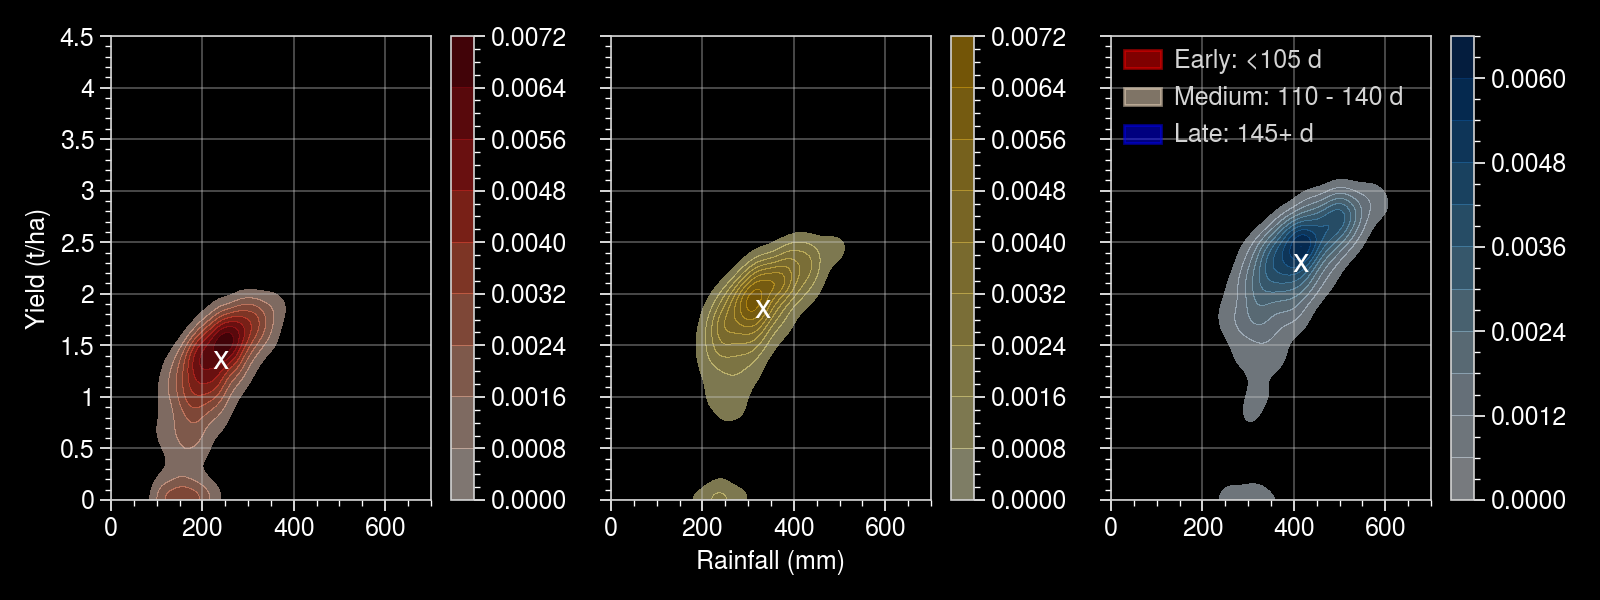

In [15]:
# Can I get these three on the same plot?

# I dont know how to do this with proplot - to get nice abcd, put in an issue
fig, axes = plt.subplots(ncols=3,nrows=1,figsize=(8,3), sharey=True, sharex=True) 


col='white'

# this is so janky
sns.kdeplot(early.RF, early.Yield, ylim=(0,4),alpha=0.5, kind='kde',cmap="reds", shade=True, cut=True,
                shade_lowest=False, cbar=True, ax=axes[0])
ax1 = axes[0]
ax1.text(e_rf,e_y, "x", size=12, color=col)
ax1.set(ylim=(0,4.5))
#ax1.set(xlim=(0,700))
ax1.set(ylabel='Yield (t/ha)')
ax1.set(xlabel='')

import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color='red', label='Early: <105 d', alpha=0.5)
orange_patch = mpatches.Patch(color='orange1', label='Medium: 110 - 140 d', alpha=0.5)
blue_patch = mpatches.Patch(color='blue', label='Late: 145+ d', alpha=0.5)
plt.legend(handles=[red_patch, orange_patch, blue_patch],loc='upper left', frameon=False) #,  bbox_to_anchor=(0.9, 0.9)


#plt.show()
ax2 = axes[1]
sns.kdeplot(med.RF, med.Yield, xlim=(0,700),ylim=(-0.5,4.5),alpha=0.5,kind='kde',cmap="orange1", cut=True,
                  shade=True, shade_lowest=False, cbar=True,ax=ax2)
ax2.text(m_rf,m_y,"x",size=12,color=col)
ax2.set(ylim=(0,4.5))
ax2.set(xlim=(0,700))
ax2.set(ylabel='')
ax2.set(xlabel='Rainfall (mm)')


ax3 = axes[2]
#plt.show()
sns.kdeplot(late.RF, late.Yield,xlim=(0,700),ylim=(-0.5,4.5), alpha=0.5,kind='kde',cmap="blues", shade=True, cut=True,
            shade_lowest=False, cbar=True, ax=ax3) #greens
ax3.text(l_rf,l_y, "x", size=12, color=col)
ax3.set(ylim=(0,4.5))
#ax3.set(xlim=(0,700))
ax3.set(ylabel='')
ax3.set(xlabel='')

fig.tight_layout()


plt.savefig('../output/4-cultivar-analysis/varietiesPDF_prez.png')

In [ ]:
axs.format(
        xlabel='Year', #ylabel='ylabel', suptitle='test',
        abc=True, abcloc='ur' #grid=False, xticks=25, yticks=5
    )

ALPHA = 0.05
col='white'